<a href="https://colab.research.google.com/github/suchith1012/Mitosis-detection-based-on-features-from-breast-cancer-histology-slide-images/blob/main/Code/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdution 

In this article we are going to extract the features from the images and use optimizer technique and classifer to classify the Mitosis and Non Mitosis

#### Extracting data from zip file

In [ ]:
!unzip "/content/MandNM.zip" -d "/content"

In [ ]:
!mkdir Final_Result

#### Installing Libraries

In [ ]:
!git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null
!git clone https://github.com/Ritam-Guha/Py_FS.git
!cp -r scikit-hyperband/* .
!python setup.py install 2>/dev/null 1>/dev/null
!pip install scikit-optimize
!pip install sklearn-deap
!pip install tpot

!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install ReliefF
!pip install -U Py_FS

!pip install scikit-fuzzy
!pip install FuzzyClassificator

Cloning into 'Py_FS'...
remote: Enumerating objects: 2159, done.
remote: Counting objects: 100% (1410/1410), done.
remote: Compressing objects: 100% (838/838), done.
remote: Total 2159 (delta 800), reused 1123 (delta 536), pack-reused 749
Receiving objects: 100% (2159/2159), 41.95 MiB | 34.50 MiB/s, done.
Resolving deltas: 100% (1278/1278), done.
     |████████████████████████████████| 100 kB 4.2 MB/s 
     |████████████████████████████████| 160 kB 5.3 MB/s 
     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 173.6 MB 10 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=ef564b4131943cb1196795fd2e49bce3a738475ccb138e8e5d59f54da79e57e2
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled 

In [ ]:
import matplotlib.pyplot as plt
from skimage import io,filters
import cv2
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import csv
import numpy as np
import os
from google.colab.patches import cv2_imshow
from os import path
from skimage.feature import hog,ORB, CENSURE, corner_peaks, corner_harris, BRIEF
from skimage import data, color, exposure
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from numpy import std
from skimage.util import img_as_ubyte
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn import svm
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
from hyperband import HyperbandSearchCV
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOTClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from Py_FS.wrapper.nature_inspired.BBA import BBA as FS
from sklearn.preprocessing import StandardScaler

In [ ]:
def normalize(data):
  x = data.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  return df

## Classification

In [ ]:
def results(tname,data):
  a=data.iloc[:,:-1]
  b=data.iloc[:,-1]
  data=[]
  print(" \033[94m results for gridsearch:")
  gresult=grid_search(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",gresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")

  print(" \033[94m results for random search")
  rresult=random_search(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",rresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")

  print("\033[94m results for Bayesian Optimization with Gaussian Process (BO-GP)")
  boreult=bogp(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",boreult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")

  print("\033[94m results for skopt")
  skresult=skopt_gp(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",skresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")

  print("\033[94m result for bo_tpe")
  botresult=bo_tpe(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",botresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")


  print("\033[94m result for genetic")
  geresult=genetic(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",geresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")


  print("\033[94m result for tpot")
  tpresult=tpot(a,b)
  print("\x1b[31m\"Results\"\x1b[0m",tpresult)
  print("\x1b[31m\"--------------------------------------------------------------------------------------------------\"\x1b[0m")


  data.append(gresult,rresult,boreult,skresult,botresult,geresult,tpresult)
  newcsvcres(tname,hdata)






## PCA 


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.manifold import Isomap

def pca_reduction(data,n):
  pca = PCA(n_components=n)
  reduced_features = pca.fit_transform(data)
  features = reduced_features.tolist()
  return features

In [ ]:
def ptoa(data):
  df = pd.DataFrame(data)
  df = df.astype(np.float32)
  df=df.replace(np.nan, 0)
  temp=df.to_numpy()
  return temp


## edge extract

In [ ]:
def edgeExtract(img, bins):
    retVal = []
    #apply vertical and horizontal sobel filters to get two histogramms, once of vertical and once of horizontal edges
    #vertical
    fs = filters.sobel_v(img)
    #horizontal
    angs = filters.sobel_h(img)
    #compute histograms
    lhist = np.histogram(fs,bins,normed=True,range=(0,1))
    ahist = np.histogram(angs, bins,normed=True,range=(-180,180))
    #fuse histograms into one list
    retVal.extend(lhist[0].tolist())
    retVal.extend(ahist[0].tolist())
    return retVal

## CSV

In [148]:
def diccreator(optname,classifier,accuracy,f1score,recall,precision,param):
  temp_result={}
  temp_result={"Optimizer":optname,"classifiermode":classifier,"acc":accuracy,"f1":f1score,"rec":recall,"prec":precision,"parameter":param}
  return temp_result


In [ ]:
import csv
def newcsvcres(name,data):
  new_dict=[]
  for i in range(len(data)):
    for j in range(list(data[i].values())):
      new_dict.append(j)
  fname="/content"+Final_Result+"/"+result"+name+".csv"
  fields = ["Optimizer",'classifiermode','acc','f1',"rec","prec","parameter"]
  with open(fname, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = fields)
    writer.writeheader()
    writer.writerows(new_dict)

## GridSearch

In [154]:
def grid_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"Gridsearch":[]}
  print('Splitted Successfully')
  def classify_svm(x_train,x_test,y_train,y_test):
    param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly','linear','sigmoid']}
    svc=svm.SVC(probability=True)
    model=GridSearchCV(svc,param_grid)
    model.fit(x_train,y_train)
    print('The svm Model is trained well with the given images',model.best_params_)
    y_pred=model.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(model, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    svmtemp=diccreator("Gridsearch","svm",str(accuracy_score(y_test, y_pred)*100),f1_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),model.best_params_)
    result["Gridsearch"].append(svmtemp)

  def classify_rf(x_train,x_test,y_train,y_test):
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 'n_estimators': [1,10, 100,200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [15,20,30,50],'criterion' :['gini', 'entropy']}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train,y_train)
    print('The rf Model is trained well with the given images',CV_rfc.best_params_)
    y_rf_pred=CV_rfc.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(CV_rfc, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    rftemp=diccreator("Gridsearch","RF",str(accuracy_score(y_test, y_rf_pred)*100),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),CV_rfc.best_params_)
    result["Gridsearch"].append(rftemp)

  def classify_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': [2, 3, 5,10,15,20]}
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
    grid.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",grid.best_params_)
    y_knn_pred=grid.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(grid, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    knntemp=diccreator("Gridsearch","KNN",str(accuracy_score(y_test, y_knn_pred)*100),f1_score(y_test, y_knn_pred),precision_score(y_test, y_knn_pred),recall_score(y_test, y_knn_pred),grid.best_params_)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    result["Gridsearch"].append(knntemp)


  
  classify_rf(x_train,x_test,y_train,y_test)
  classify_knn(x_train,x_test,y_train,y_test)
  classify_svm(x_train,x_test,y_train,y_test)
  # result.append({"Gridsearch":[svmtemp,rftemp,knntemp]})
  return result







## Random Search optmizer

In [ ]:
def random_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"random_search":[]}
  print('Splitted Successfully')
  def classify_rso_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid']}
    n_iter_search=20
    clf = svm.SVC(gamma='scale')
    Random_svm = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Random_svm.best_params_)
    y_pred=Random_svm.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Random_svm, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    svmtemp=diccreator("random_search","svm",str(accuracy_score(y_test, y_pred)*100),f1_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),Random_svm.best_params_)

    result["random_search"].append(svmtemp)

  def classify_rso_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    n_iter_search=20 
    clf_rf = RandomForestClassifier(random_state=0)
    Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Random_rf.best_params_)
    y_rf_pred=Random_rf.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Random_rf, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    rftemp=diccreator("random_search","RF",str(Random_rf.best_score_),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),Random_rf.best_params_)

    result["random_search"].append(rftemp)


  def classify_rso_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20)}
    n_iter_search=10
    clf_knn = KNeighborsClassifier()
    Random_knn = RandomizedSearchCV(clf_knn, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Random_knn.best_params_)
    y_knn_pred=Random_knn.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Random_knn, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
    knntemp=diccreator("random_search","KNN",str(Random_knn.best_score_),f1_score(y_test, y_knn_pred),precision_score(y_test, y_knn_pred),recall_score(y_test, y_knn_pred),Random_knn.best_params_)

    result["random_search"].append(knntemp)


  classify_rso_rf(x_train,x_test,y_train,y_test)
  classify_rso_knn(x_train,x_test,y_train,y_test)
  classify_rso_svm(x_train,x_test,y_train,y_test)
  # result.append({"Randomsearch":[svmtemp,rftemp,knntemp]})

  return result







## Hyperband

In [ ]:
def hyperband_opt(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_hb_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid'],'bootstrap': [True, False]}
    clf_hb_svm = svm.SVC(gamma='scale')
    hyper_hb_svm = HyperbandSearchCV(clf_hb_svm, param_distributions =rf_params,cv=3,min_iter=1,max_iter=50,scoring='roc_auc',resource_param='C')
    hyper_hb_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",hyper_hb_svm.best_params_)
    result.append("svm:"+str(hyper_hb_svm.best_score_))
  def classify_hb_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),'bootstrap': [True, False],"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    clf_hb_rf = RandomForestClassifier(random_state=0)
    hyper_rf = HyperbandSearchCV(clf_hb_rf, param_distributions =rf_params,cv=3,min_iter=10,max_iter=100,scoring='roc_auc')
    hyper_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",hyper_rf.best_params_)
    result.append("Random forest:"+str(hyper_rf.best_score_))
  def classify_hb_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),'bootstrap': [True, False]}
    clf_hb_knn = KNeighborsClassifier()
    hyper_knn = HyperbandSearchCV(clf_hb_knn, param_distributions =rf_params,cv=3,min_iter=1,max_iter=20,scoring='roc_auc',resource_param='n_neighbors')
    hyper_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",hyper_knn.best_params_)
    result.append("KNN:"+str(hyper_knn.best_score_))
  classify_hb_rf(x_train,x_test,y_train,y_test)
  classify_hb_knn(x_train,x_test,y_train,y_test)
  classify_hb_svm(x_train,x_test,y_train,y_test)
  return result







## Bayesian Optimization with Gaussian Process (BO-GP)

In [ ]:
def bogp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"bogp":[]}
  print('Splitted Successfully')
  def classify_bogp_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C':[0.1,1,10,100],"kernel":['linear','poly','rbf','sigmoid']}
    clf_svm = svm.SVC(gamma='scale')
    Bayes_svm = BayesSearchCV(clf_svm, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    y_pred=Bayes_svm.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Bayes_svm, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    svmtemp=diccreator("bogp","svm",str(Bayes_svm.best_score_),f1_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),Bayes_svm.best_params_)
    result['bogp'].append(svmtemp)

  def classify_bogp_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': Integer(10,100),"max_features":Integer(1,64),'max_depth': Integer(5,50),"min_samples_split":Integer(2,11),"min_samples_leaf":Integer(1,11),"criterion":['gini','entropy']}
    clf_bogp_rf = RandomForestClassifier(random_state=0)
    Bayes_rf = BayesSearchCV(clf_bogp_rf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Bayes_rf.best_params_)
    y_rf_pred=Bayes_rf.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
     # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Bayes_rf, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    # result.append("Random forest:"+str(Bayes_rf.best_score_))
    rftemp=diccreator("bogp","RF",str(Bayes_rf.best_score_),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),Bayes_rf.best_params_)
    result['bogp'].append(rftemp)

  def classify_bogp_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': Integer(1,20)}
    clf_bogp_knn = KNeighborsClassifier()
    Bayes_knn = BayesSearchCV(clf_bogp_knn, rf_params,cv=3,n_iter=10, n_jobs=-1,scoring='accuracy')
    Bayes_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    y_knn_pred=Bayes_knn.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
    # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(Bayes_knn, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    # result.append("KNN:"+str(Bayes_knn.best_score_))
    knntemp=diccreator("bogp","KNN",str(Bayes_knn.best_score_),f1_score(y_test, y_knn_pred),precision_score(y_test, y_knn_pred),recall_score(y_test, y_knn_pred),Bayes_knn.best_params_)
    result['bogp'].append(knntemp)


  classify_bogp_rf(x_train,x_test,y_train,y_test)
  classify_bogp_knn(x_train,x_test,y_train,y_test)
  classify_bogp_svm(x_train,x_test,y_train,y_test)
  return result

## skopt.gp_minimize

In [ ]:


def skopt_gp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"skopt_gp":[]}
  print('Splitted Successfully')
  def classify_skgp_svm(x_train,x_test,y_train,y_test):
    reg = svm.SVC(gamma='scale')
    space  = [Real(0.01, 50, name='C'),Categorical(['linear','poly','rbf','sigmoid'], name='kernel')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_svm = gp_minimize(objective, space, n_calls=20, random_state=0)
    # print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    # y_pred=-res_svm.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    svmtemp=diccreator("skopt_gp","svm",str(-res_svm.fun),0,0,0,0)
    result['skopt_gp'].append(svmtemp)
    # result.append("svm:"+str(-res_svm.fun))
  def classify_skgp_rf(x_train,x_test,y_train,y_test):
    reg = RandomForestClassifier()
    space  = [Integer(10, 100, name='n_estimators'),Integer(5, 50, name='max_depth'),Integer(1, 64, name='max_features'),Integer(2, 11, name='min_samples_split'),Integer(1, 11, name='min_samples_leaf'),Categorical(['gini', 'entropy'], name='criterion'),]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    # y_rf_pred=-res_gp.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    rftemp=diccreator("skopt_gp","RF",str(-res_gp.fun),0,0,0,0)
    result['skopt_gp'].append(rftemp)
    
    # result.append("Random forest:"+str(-res_gp.fun))
  def classify_skgp_knn(x_train,x_test,y_train,y_test):
    reg = KNeighborsClassifier()
    space  = [Integer(1, 20, name='n_neighbors')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_knn = gp_minimize(objective, space, n_calls=10, random_state=0)
    # print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    # y_knn_pred=res_knn.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
    knntemp=diccreator("skopt_gp","KNN",str(-res_knn.fun),0,0,0,0)
    result['skopt_gp'].append(knntemp)
    # result.append("KNN:"+str(-res_knn.fun))
  classify_skgp_rf(x_train,x_test,y_train,y_test)
  classify_skgp_knn(x_train,x_test,y_train,y_test)
  classify_skgp_svm(x_train,x_test,y_train,y_test)
  return result

## Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

In [ ]:
def bo_tpe(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"bo_tpe":[]}
  print('Splitted Successfully')
  def classify_botpe_svm(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'C': abs(float(params['C'])), "kernel":str(params['kernel'])}
      clf = svm.SVC(gamma='scale', **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'C': hp.normal('C', 0, 50),"kernel":hp.choice('kernel',['linear','poly','rbf','sigmoid'])}
    best_svm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    # y_pred=best_svm.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    svmtemp=diccreator("bo_tpe","svm",str(best_svm),0,0,0,0)
    result['bo_tpe'].append(svmtemp)
    # result.append("svm:"+str(best_svm))

  def classify_botpe_rf(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth']),'max_features': int(params['max_features']),"min_samples_split":int(params['min_samples_split']),"min_samples_leaf":int(params['min_samples_leaf']),"criterion":str(params['criterion'])}
      clf = RandomForestClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_estimators': hp.quniform('n_estimators', 10, 100, 1),'max_depth': hp.quniform('max_depth', 5, 50, 1),"max_features":hp.quniform('max_features', 1, 64, 1),"min_samples_split":hp.quniform('min_samples_split',2,11,1),"min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),"criterion":hp.choice('criterion',['gini','entropy'])}
    best_rf = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    # y_rf_pred=best_rf.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    rftemp=diccreator("bo_tpe","RF",str(best_rf),0,0,0,0)
    result['bo_tpe'].append(rftemp)
    # result.append("Random forest:"+str(best_rf))


  def classify_botpe_knn(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_neighbors': abs(int(params['n_neighbors']))}
      clf = KNeighborsClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),}
    best_knn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
    # y_knn_pred=best_knn.predict(x_test)
    # print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    # print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    # print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
    knntemp=diccreator("bo_tpe","KNN",str(best_knn),0,0,0,0)
    result['bo_tpe'].append(knntemp)
    # result.append("KNN:"+str(best_knn))
  classify_botpe_rf(x_train,x_test,y_train,y_test)
  classify_botpe_knn(x_train,x_test,y_train,y_test)
  classify_botpe_svm(x_train,x_test,y_train,y_test)
  return result

## Genetic Algorithm

In [ ]:
def genetic(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"genetic":[]}
  print('Splitted Successfully')
  def classify_g_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    clf_g_svm = svm.SVC(gamma='scale')
    ga1_svm = EvolutionaryAlgorithmSearchCV(estimator=clf_g_svm,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_svm.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_svm.best_params_)
    y_pred=ga1_svm.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga1_svm, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    svmtemp=diccreator("genetic","svm",str(ga1_svm.best_score_),f1_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),ga1_svm.best_params_)
    result['genetic'].append(svmtemp)
    # result.append("svm:"+str(ga1_svm.best_score_))
  def classify_g_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': np.logspace(1,1.8,num = 10 ,base=20,dtype='int'),'max_depth': np.logspace(1,2,num = 10 ,base=10,dtype='int'),"max_features":np.logspace(0.2,1,num = 5 ,base=8,dtype='int'),"min_samples_split":np.logspace(0.4, 1, num=5, base=10, dtype='int'),"min_samples_leaf":np.logspace(0.1,1,num = 5 ,base=11,dtype='int'),"criterion":['gini','entropy']}
    rf_params = {'n_estimators': range(10,100),"max_features":range(1,64),'max_depth': range(5,50),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    clf_g_rf = RandomForestClassifier(random_state=0)
    ga1_rf = EvolutionaryAlgorithmSearchCV(estimator=clf_g_rf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_rf.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_rf.best_params_)
    y_rf_pred=ga1_rf.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
     # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga1_rf, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    rftemp=diccreator("genetic","RF",str(ga1_rf.best_score_),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),ga1_rf.best_params_)
    result['genetic'].append(rftemp)
    # result.append("Random forest:"+str(ga1_rf.best_score_))
  def classify_g_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),}
    clf_g_knn = KNeighborsClassifier()
    ga1_knn = EvolutionaryAlgorithmSearchCV(estimator=clf_g_knn,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_knn.fit(x_train, y_train)
    print('The knn Model is trained well with the given images',ga1_knn.best_params_)
    y_knn_pred=ga1_knn.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_knn_pred))
    print('Recall: %.3f' % recall_score(y_test, y_knn_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_knn_pred))
     # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga1_knn, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    knntemp=diccreator("genetic","KNN",str(ga1_knn.best_score_),f1_score(y_test, y_knn_pred),precision_score(y_test, y_knn_pred),recall_score(y_test, y_knn_pred),ga1_knn.best_params_)
    result['bogp'].append(knntemp)
    # result.append("KNN:"+str(ga1_knn.best_score_))
  classify_g_rf(x_train,x_test,y_train,y_test)
  classify_g_knn(x_train,x_test,y_train,y_test)
  classify_g_svm(x_train,x_test,y_train,y_test)
  return result

## TPOT

In [ ]:
def tpot(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result={"tpot":[]}

  print('Splitted Successfully')
  def classify_tpot_svm(x_train,x_test,y_train,y_test):
    parameters = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    ga2_svm = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_svm.fit(x_train, y_train)
    y_rf_pred=ga2_svm.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga2_svm, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    svmtemp=diccreator("tpot","svm",str(accuracy_score(y_test, y_rf_pred)*100),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),0)
    result['tpot'].append(svmtemp)
    # result.append("svm:"+str(accuracy_score(y_test, y_rf_pred)*100))

  def classify_tpot_rf(x_train,x_test,y_train,y_test):
    parameters = {'n_estimators': range(20,200),"max_features":range(1,64),'max_depth': range(10,100),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    ga2_rf = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_rf.fit(x_train, y_train)
    y_rf_pred=ga2_rf.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
    # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga2_rf, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    rftemp=diccreator("tpot","RF",str(accuracy_score(y_test, y_rf_pred)*100),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),0)
    result['tpot'].append(rftemp)
    # result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))

  def classify_tpot_knn(x_train,x_test,y_train,y_test):
    parameters = {'n_neighbors': range(1,20),}
    ga2_knn = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_knn.fit(x_train, y_train)
    y_rf_pred=ga2_knn.predict(x_test)
    print('Precision: %.3f' % precision_score(y_test, y_rf_pred))
    print('Recall: %.3f' % recall_score(y_test, y_rf_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_rf_pred))
        # ----------------------------------------------------------
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    scores = cross_val_score(ga2_knn, x,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy 2 folds: %.3f (%.3f)' % (mean(scores), std(scores)))
     # ----------------------------------------------------------
    knntemp=diccreator("tpot","RF",str(accuracy_score(y_test, y_rf_pred)*100),f1_score(y_test, y_rf_pred),precision_score(y_test, y_rf_pred),recall_score(y_test, y_rf_pred),0)
    result['tpot'].append(knntemp)
    # result.append("knn:"+str(accuracy_score(y_rf_pred,y_test)*100))

  classify_tpot_rf(x_train,x_test,y_train,y_test)
  classify_tpot_knn(x_train,x_test,y_train,y_test)
  classify_tpot_svm(x_train,x_test,y_train,y_test)
  return result

In [ ]:
numbervalue=400

## Feature extraction

## Histogram of Oriented Gradients(HOG) 


*   HOG descriptor focuses on the structure or the shape of an object
*   HOG would generate a Histogram for each  regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’

### Extracting hog features

[0.13967154 0.07405471 0.00404335 ... 0.0584853  0.0459223  0.03301468]


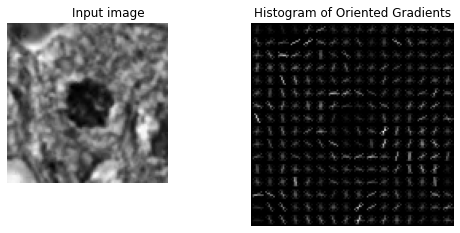

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

(15876,)


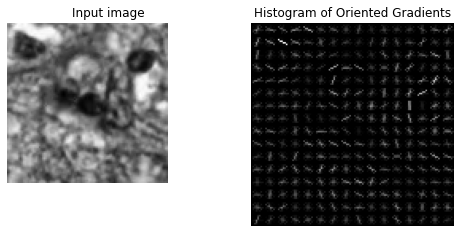

In [ ]:
img = io.imread(r"/content/MandNM/nonmitosis/A00_01_01_VX9XQ1HO9-c9862dc6a1df71ff47c2f543a819cffe.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

In [ ]:
category = []
hogArray = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = cv2.imread(image)
            image_grey = color.rgb2gray(img)

            # Resize the image to (64, 128)
            # Default for hog
            resized = cv2.resize(image_grey, (128, 128), interpolation=cv2.INTER_AREA)

            # Compute the Hog Features
            fd, hog_image = hog(resized,visualize=True)
            
            category.append(folder)
            hogArray.append(fd)



# convert the extracted features
# from array to vector
hogArray_np = np.array(hogArray)


print("Total feature extracted from the each image",len(hogArray_np[0]))

Total feature extracted from the each image 15876


In [ ]:
hog_df = pd.DataFrame(hogArray_np)
hog_df

0         1         2         3         4         5         6      \
0    0.065271  0.060419  0.073369  0.069159  0.126205  0.022763  0.016372   
1    0.050460  0.000000  0.015055  0.019182  0.095482  0.097984  0.083186   
2    0.207576  0.072076  0.044470  0.035890  0.038515  0.018976  0.032627   
3    0.087588  0.030684  0.002529  0.007331  0.051322  0.000000  0.012871   
4    0.074213  0.058557  0.018364  0.218638  0.218638  0.067073  0.218638   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.205091  0.230075  0.105902  0.228347  0.085009  0.040514  0.036706   
428  0.107235  0.040051  0.000000  0.031771  0.065204  0.030679  0.118637   
429  0.073774  0.038426  0.017928  0.013627  0.150593  0.185222  0.166245   
430  0.046163  0.066062  0.227172  0.024650  0.035130  0.003538  0.012574   
431  0.131220  0.037409  0.054016  0.037374  0.032485  0.058846  0.018014   

        7         8         9      ...     15866     15867     15868  \
0    0.000000  0.068486  0.210967  ...  0.088477  0.116311  0.063753   
1    0.074277  0.114012  0.240514  ...  0.206588  0.120764  0.099197   
2    0.018221  0.016939  0.258056  ...  0.003982  0.052591  0.000000   
3    0.068512  0.132098  0.195536  ...  0.024603  0.178391  0.072631   
4    0.045377  0.012457  0.064751  ...  0.087242  0.019536  0.029958   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.104375  0.082528  0.158053  ...  0.063542  0.231317  0.114515   
428  0.209062  0.058639  0.115080  ...  0.112328  0.127548  0.039110   
429  0.074106  0.009206  0.149028  ...  0.011527  0.071076  0.000000   
430  0.009217  0.000000  0.227172  ...  0.057142  0.174117  0.015974   
431  0.046060  0.085966  0.052387  ...  0.162458  0.126990  0.030010   

        15869     15870     15871     15872     15873     15874     15875  
0    0.048956  0.030840  0.079612  0.023628  0.021234  0.003663  0.006520  
1    0.099129  0.092678  0.160933  0.104739  0.068069  0.200371  0.039077  
2    0.052874  0.215309  0.165175  0.227425  0.021410  0.005222  0.022455  
3    0.022273  0.017795  0.071473  0.022679  0.143259  0.239190  0.043577  
4    0.022078  0.012709  0.031882  0.018896  0.007119  0.008593  0.012491  
..        ...       ...       ...       ...       ...       ...       ...  
427  0.000000  0.022655  0.058304  0.000000  0.003749  0.019741  0.231317  
428  0.079490  0.040167  0.230102  0.144977  0.106465  0.029232  0.048511  
429  0.033364  0.268177  0.268177  0.095487  0.000000  0.002153  0.012821  
430  0.046934  0.049573  0.100285  0.047926  0.071000  0.123493  0.216809  
431  0.208042  0.243952  0.243952  0.003818  0.002000  0.003455  0.003060  

[432 rows x 15876 columns]

In [ ]:
hog_features=pca_reduction(hogArray_np,numbervalue)

In [ ]:
csvData = []
for id, line in enumerate(hog_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_hog_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_hog=pd.read_csv("result_hog_data.csv")
feature_hog['label'] = feature_hog['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_hog

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...  value391  value392  value393  \
0   -0.268069 -0.931471 -1.355695  ...  0.024063 -0.353254 -0.021248   
1    0.050257  0.107054  1.126562  ...  0.561358 -0.108341  0.080742   
2    0.477479 -0.698468 -0.307454  ... -0.241582 -0.059190 -0.111274   
3    0.170025 -1.146832 -0.008905  ... -0.153428  0.062869  0.152043   
4   -0.435782 -0.520119 -0.396920  ...  0.244421 -0.135089 -0.035010   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.322701  0.006529 -0.051505  ...  0.366410 -0.284376 -0.022834   
428  0.236099  0.507987  0.185405  ... -0.297113  0.199259 -0.414239   
429  0.612595 -0.685094 -0.556020  ...  0.012431 -0.247337  0.821951   
430 -0.707209  0.809177 -0.119798  ... -0.405510 -0.354407  0.187399   
431 -0.578040 -0.462534 -1.077838  ...  0.239133  0.066091 -0.052041   

     value394  value395  value396  value397  value398  value399  label  
0   -0.029010 -0.396667  0.073812  0.445683 -0.031501  0.139262      1  
1   -0.188517  0.411136  0.073315 -0.201603  0.437930 -0.422032      1  
2    0.187281  0.195997 -0.408598 -0.018854  0.056705 -0.160048      1  
3    0.445871 -0.103868  0.060864 -0.178517  0.062032  0.297134      1  
4   -0.165525 -0.530256  0.348886 -0.117684 -0.181661 -0.012190      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.119404  0.465454  0.172539  0.425999  0.318594  0.365696      0  
428  0.468318  0.159306 -0.034153 -0.422007 -0.184357 -0.033423      0  
429 -0.080852 -0.021301 -0.274436 -0.049266  0.239487 -0.130485      0  
430 -0.008237 -0.041299 -0.148583  0.027733 -0.242442 -0.016676      0  
431  0.064705 -0.177038  0.261467 -0.042455 -0.061892  0.088965      0  

[432 rows x 401 columns]

### classification based on features

In [ ]:
hdata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])


In [ ]:
hdata.append(grid_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])


In [ ]:
hdata.append(random_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])


In [ ]:
hdata.append(bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])


In [ ]:
hdata.append(bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
hdata.append(bo_tpe(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
hdata.append(genetic(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
hdata.append(tpot(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1]))

In [ ]:
newcsvcres("HOG",hdata)

## ORB(Oriented FAST and Rotated BRIEF)
ORB is an efficient open source alternative to SIFT and SURF. Even though it computes less key points when compared to SIFT and SURF yet they are effective. It uses FAST and BRIEF techniques to detect the key points and compute the image descriptors respectively.

### Extracting orb features

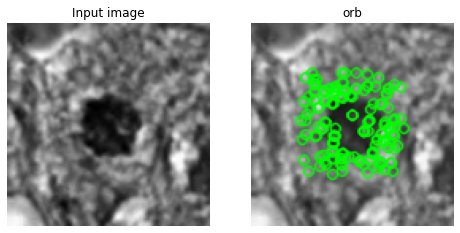

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)


orb = cv2.ORB_create(nfeatures=2000)
kp, des = orb.detectAndCompute(img3, None)

kp_img = cv2.drawKeypoints(img3, kp, None, color=(0, 255, 0), flags=0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(resized, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')
# hog_image_rescaled = exposure.rescale_intensity(img2, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(kp_img, cmap=plt.cm.gray)
ax2.set_title('orb')
ax1.set_adjustable('box')
plt.show()

In [ ]:
category_orb = []
Array_orb = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            orb = cv2.ORB_create(nfeatures=2000)
            kp, des = orb.detectAndCompute(img3, None)
            x_image_features = np.vstack(np.array(des))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_orb.append(folder)
            Array_orb.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
orbArray_np = np.array(Array_orb)


print("Total feature extracted from the each image",len(orbArray_np[0]))

Total feature extracted from the each image 3968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
orb_df = pd.DataFrame(Array_orb)
orb_df

0         1         2         3         4         5         6     \
0    0.198413  0.325397  0.854902  0.669388  0.080321  0.382470  0.300000   
1    0.021097  0.987500  0.602564  0.991561  0.979339  0.991266  0.173554   
2    0.596078  0.619048  0.185185  1.000000  0.221311  0.772908  0.079365   
3    0.721569  0.984127  0.204000  0.996047  0.486056  0.760163  0.831933   
4    0.901575  0.924303  0.616034  0.603922  0.096000  0.872000  0.543933   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.280632  0.650980  0.531496  0.634538  0.690476  0.654902  0.204819   
428  0.968627  0.896414  0.662698  0.000000  0.545817  0.332016  0.257028   
429  0.678431  0.329317  0.519685  0.615385  0.288000  0.865079  0.885714   
430  0.658824  0.745020  0.103175  0.475410  1.000000  0.739130  0.278970   
431  0.129412  0.872000  0.434599  0.867470  0.450413  0.766393  0.331933   

         7         8         9     ...  8214  8215  8216  8217  8218  8219  \
0    0.971774  0.578313  0.769231  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1    0.812749  0.000000  0.495968  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2    0.200803  0.675889  0.345098  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3    0.923387  0.796078  0.047244  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4    0.908730  0.795276  0.850980  ...   NaN   NaN   NaN   NaN   NaN   NaN   
..        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
427  0.145161  0.208835  0.972112  ...   NaN   NaN   NaN   NaN   NaN   NaN   
428  0.928854  0.318898  0.952756  ...   NaN   NaN   NaN   NaN   NaN   NaN   
429  0.752941  0.864542  0.322835  ...   NaN   NaN   NaN   NaN   NaN   NaN   
430  0.756000  0.854839  0.043825  ...   NaN   NaN   NaN   NaN   NaN   NaN   
431  0.737903  0.114035  0.283465  ...   NaN   NaN   NaN   NaN   NaN   NaN   

     8220  8221  8222  8223  
0     NaN   NaN   NaN   NaN  
1     NaN   NaN   NaN   NaN  
2     NaN   NaN   NaN   NaN  
3     NaN   NaN   NaN   NaN  
4     NaN   NaN   NaN   NaN  
..    ...   ...   ...   ...  
427   NaN   NaN   NaN   NaN  
428   NaN   NaN   NaN   NaN  
429   NaN   NaN   NaN   NaN  
430   NaN   NaN   NaN   NaN  
431   NaN   NaN   NaN   NaN  

[432 rows x 8224 columns]

In [ ]:
orb_df.dropna(thresh=len(orb_df) - 3, axis=1)

0         1         2         3         4         5         6     \
0    0.198413  0.325397  0.854902  0.669388  0.080321  0.382470  0.300000   
1    0.021097  0.987500  0.602564  0.991561  0.979339  0.991266  0.173554   
2    0.596078  0.619048  0.185185  1.000000  0.221311  0.772908  0.079365   
3    0.721569  0.984127  0.204000  0.996047  0.486056  0.760163  0.831933   
4    0.901575  0.924303  0.616034  0.603922  0.096000  0.872000  0.543933   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.280632  0.650980  0.531496  0.634538  0.690476  0.654902  0.204819   
428  0.968627  0.896414  0.662698  0.000000  0.545817  0.332016  0.257028   
429  0.678431  0.329317  0.519685  0.615385  0.288000  0.865079  0.885714   
430  0.658824  0.745020  0.103175  0.475410  1.000000  0.739130  0.278970   
431  0.129412  0.872000  0.434599  0.867470  0.450413  0.766393  0.331933   

         7         8         9     ...      1430      1431      1432  \
0    0.971774  0.578313  0.769231  ...  0.750988  0.564000  0.208835   
1    0.812749  0.000000  0.495968  ...  0.169565  0.749020  0.373444   
2    0.200803  0.675889  0.345098  ...  0.145669  1.000000  0.163265   
3    0.923387  0.796078  0.047244  ...  0.603922  0.945098  0.711934   
4    0.908730  0.795276  0.850980  ...  0.692000  0.882353  0.861789   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.145161  0.208835  0.972112  ...  0.670683  0.935223  0.163180   
428  0.928854  0.318898  0.952756  ...  0.102362  0.747036  0.996016   
429  0.752941  0.864542  0.322835  ...  0.980392  0.819608  0.368421   
430  0.756000  0.854839  0.043825  ...  0.729412  0.952941  0.598394   
431  0.737903  0.114035  0.283465  ...  0.796078  0.692308  0.794355   

         1433      1434      1435      1436      1437      1438      1439  
0    0.844622  0.060241  0.498039  0.871486  0.000000  0.858268  0.553360  
1    0.135802  0.635294  0.000000  0.497908  0.600823  1.000000  0.936508  
2    0.460630  0.622047  0.764706  0.252066  0.360784  0.706827  0.884000  
3    0.580000  0.371542  0.482353  0.564706  0.317647  0.653386  0.126482  
4    0.992032  0.578740  0.921569  0.392405  0.525490  1.000000  0.413386  
..        ...       ...       ...       ...       ...       ...       ...  
427  0.406375  0.996063  0.501961  0.422764  0.956863  0.478261  0.992157  
428  0.270588  0.554217  0.796078  0.573770  0.305882  0.726531  0.852590  
429  0.356863  0.313725  0.498039  0.822134  0.047059  0.880952  0.901961  
430  0.874510  0.370079  0.478431  0.860558  0.345098  0.788000  0.346614  
431  0.829787  0.321285  0.498039  0.817814  0.326772  0.561265  0.039370  

[432 rows x 1440 columns]

In [ ]:
temp=ptoa(Array_orb)
orb_features=pca_reduction(temp,numbervalue)

In [ ]:
csvData = []
for id, line in enumerate(orb_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_orb_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_orb=pd.read_csv("result_orb_data.csv")
feature_orb['label'] = feature_orb['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_orb

value0     value1     value2    value3    value4    value5    value6  \
0    -9.428937  -2.680817  -6.847563 -3.703102 -0.195570  2.463924 -0.553940   
1   -17.867825  11.533050  10.338498  7.432687  5.192900  6.495459 -4.386913   
2    -5.603446  -4.991922  -3.552224  2.403152  3.131538  0.405759  1.662263   
3     4.364200  -5.650557   4.032535  0.075465 -3.151016  1.544191 -1.570315   
4    -2.116558  -7.551803  -2.826291  3.326630  1.515992 -2.907041  1.491393   
..         ...        ...        ...       ...       ...       ...       ...   
427   9.938236  -2.853084   4.772931 -3.734164  0.746291  1.068727  3.916517   
428  10.253557  -0.114625   3.319892 -3.658585  2.619110 -0.971751  1.129324   
429  15.618765   9.719361  -5.548385  3.921858 -2.141642  1.327133  1.112908   
430  -4.985594  -5.963516  -4.674801  2.012129  3.314960  0.443798  2.575538   
431  -9.335450  -2.442459  -5.737391 -2.702708  1.073609  2.691196 -0.390983   

       value7    value8    value9  ...  value391  value392  value393  \
0   -1.082205  2.908219 -2.497401  ... -0.986797  0.281501 -0.334993   
1    3.398158 -2.792660  0.909624  ...  1.016338 -0.642708 -1.279205   
2   -1.476440 -1.318576  2.081625  ...  0.181919 -0.030068 -0.254081   
3   -1.711708  0.669692 -0.577477  ...  0.706525 -0.229333  0.254524   
4    0.944797 -1.973264  1.403547  ...  0.223127 -0.131747 -0.067467   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.503832 -1.864159 -2.195061  ... -0.322991  0.166123 -0.098312   
428  2.400915  1.391151 -0.620774  ...  0.004106 -0.192792  0.148853   
429  0.047233 -1.309628 -2.018835  ... -0.025657 -0.077088 -0.185637   
430 -1.731873 -0.572997  1.855378  ...  0.667899  0.085605 -0.562579   
431 -1.025147  2.817886 -3.017595  ... -0.307389  0.464692  0.293698   

     value394  value395  value396  value397  value398  value399  label  
0    1.140175  0.302814  0.398777  0.609049  1.426366 -0.143779      1  
1    0.043575 -0.536392 -0.771609 -0.288752 -0.794938 -0.227900      1  
2   -0.045656 -0.102376 -0.200113 -1.236775  0.293823 -0.333931      1  
3   -0.083757  0.056025 -0.231124 -0.312433  0.751222  0.259065      1  
4   -0.268562 -0.091154  0.220023 -0.764322  0.706177  0.079960      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.108794  0.217688 -0.050442  0.191920  0.566219  0.218882      0  
428  0.935001  0.007038 -0.220344 -0.329273 -0.382322 -0.503089      0  
429 -0.187347 -0.146179  0.114220 -0.032537  0.398514  0.039176      0  
430 -0.865997 -0.817307 -0.495948  0.816698 -0.624745  0.325984      0  
431  0.710835  0.158823 -0.332908  2.477256  1.479964 -0.260107      0  

[432 rows x 401 columns]

In [ ]:
# feature_orb=normalize(feature_orb)

In [ ]:
feature_orb

value0     value1     value2    value3    value4    value5    value6  \
0    -9.428937  -2.680817  -6.847563 -3.703102 -0.195570  2.463924 -0.553940   
1   -17.867825  11.533050  10.338498  7.432687  5.192900  6.495459 -4.386913   
2    -5.603446  -4.991922  -3.552224  2.403152  3.131538  0.405759  1.662263   
3     4.364200  -5.650557   4.032535  0.075465 -3.151016  1.544191 -1.570315   
4    -2.116558  -7.551803  -2.826291  3.326630  1.515992 -2.907041  1.491393   
..         ...        ...        ...       ...       ...       ...       ...   
427   9.938236  -2.853084   4.772931 -3.734164  0.746291  1.068727  3.916517   
428  10.253557  -0.114625   3.319892 -3.658585  2.619110 -0.971751  1.129324   
429  15.618765   9.719361  -5.548385  3.921858 -2.141642  1.327133  1.112908   
430  -4.985594  -5.963516  -4.674801  2.012129  3.314960  0.443798  2.575538   
431  -9.335450  -2.442459  -5.737391 -2.702708  1.073609  2.691196 -0.390983   

       value7    value8    value9  ...  value391  value392  value393  \
0   -1.082205  2.908219 -2.497401  ... -0.986797  0.281501 -0.334993   
1    3.398158 -2.792660  0.909624  ...  1.016338 -0.642708 -1.279205   
2   -1.476440 -1.318576  2.081625  ...  0.181919 -0.030068 -0.254081   
3   -1.711708  0.669692 -0.577477  ...  0.706525 -0.229333  0.254524   
4    0.944797 -1.973264  1.403547  ...  0.223127 -0.131747 -0.067467   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.503832 -1.864159 -2.195061  ... -0.322991  0.166123 -0.098312   
428  2.400915  1.391151 -0.620774  ...  0.004106 -0.192792  0.148853   
429  0.047233 -1.309628 -2.018835  ... -0.025657 -0.077088 -0.185637   
430 -1.731873 -0.572997  1.855378  ...  0.667899  0.085605 -0.562579   
431 -1.025147  2.817886 -3.017595  ... -0.307389  0.464692  0.293698   

     value394  value395  value396  value397  value398  value399  label  
0    1.140175  0.302814  0.398777  0.609049  1.426366 -0.143779      1  
1    0.043575 -0.536392 -0.771609 -0.288752 -0.794938 -0.227900      1  
2   -0.045656 -0.102376 -0.200113 -1.236775  0.293823 -0.333931      1  
3   -0.083757  0.056025 -0.231124 -0.312433  0.751222  0.259065      1  
4   -0.268562 -0.091154  0.220023 -0.764322  0.706177  0.079960      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.108794  0.217688 -0.050442  0.191920  0.566219  0.218882      0  
428  0.935001  0.007038 -0.220344 -0.329273 -0.382322 -0.503089      0  
429 -0.187347 -0.146179  0.114220 -0.032537  0.398514  0.039176      0  
430 -0.865997 -0.817307 -0.495948  0.816698 -0.624745  0.325984      0  
431  0.710835  0.158823 -0.332908  2.477256  1.479964 -0.260107      0  

[432 rows x 401 columns]

### classification based on orb features

In [ ]:
orbdata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(grid_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(random_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(bogp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(skopt_gp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(bo_tpe(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(genetic(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

In [ ]:
orbdata.append(tpot(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]))

In [ ]:
newcsvcres("ORB",orbdata)

### combining hog and orb

In [ ]:
orbhog_temp=[feature_hog.iloc[:,:-1],feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]]

In [ ]:
orb_hog=pd.concat(orbhog_temp, axis=1)

In [ ]:
orb_hog

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...  value391  value392  value393  \
0   -0.268069 -0.931471 -1.355695  ... -0.986797  0.281501 -0.334993   
1    0.050257  0.107054  1.126562  ...  1.016338 -0.642708 -1.279205   
2    0.477479 -0.698468 -0.307454  ...  0.181919 -0.030068 -0.254081   
3    0.170025 -1.146832 -0.008905  ...  0.706525 -0.229333  0.254524   
4   -0.435782 -0.520119 -0.396920  ...  0.223127 -0.131747 -0.067467   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.322701  0.006529 -0.051505  ... -0.322991  0.166123 -0.098312   
428  0.236099  0.507987  0.185405  ...  0.004106 -0.192792  0.148853   
429  0.612595 -0.685094 -0.556020  ... -0.025657 -0.077088 -0.185637   
430 -0.707209  0.809177 -0.119798  ...  0.667899  0.085605 -0.562579   
431 -0.578040 -0.462534 -1.077838  ... -0.307389  0.464692  0.293698   

     value394  value395  value396  value397  value398  value399  label  
0    1.140175  0.302814  0.398777  0.609049  1.426366 -0.143779      1  
1    0.043575 -0.536392 -0.771609 -0.288752 -0.794938 -0.227900      1  
2   -0.045656 -0.102376 -0.200113 -1.236775  0.293823 -0.333931      1  
3   -0.083757  0.056025 -0.231124 -0.312433  0.751222  0.259065      1  
4   -0.268562 -0.091154  0.220023 -0.764322  0.706177  0.079960      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.108794  0.217688 -0.050442  0.191920  0.566219  0.218882      0  
428  0.935001  0.007038 -0.220344 -0.329273 -0.382322 -0.503089      0  
429 -0.187347 -0.146179  0.114220 -0.032537  0.398514  0.039176      0  
430 -0.865997 -0.817307 -0.495948  0.816698 -0.624745  0.325984      0  
431  0.710835  0.158823 -0.332908  2.477256  1.479964 -0.260107      0  

[432 rows x 801 columns]

### classification based on orb and hog features

In [ ]:
hog_orb=[]

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(grid_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(random_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(bogp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(skopt_gp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(bo_tpe(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(genetic(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

In [ ]:
hog_orb.append(tpot(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1]))

In [ ]:
newcsvcres("HogORB",hog_orb)

## Censure extractor

### extracting censure extractor

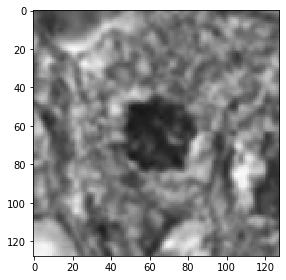

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)

detector = CENSURE()
detector.detect(resized)
a=detector.keypoints

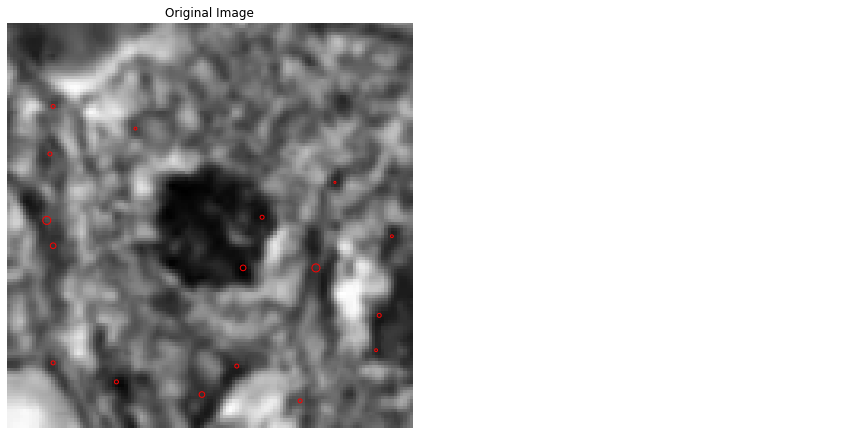

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(img3, cmap=plt.cm.gray)
ax[0].scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')
ax[0].set_title("Original Image")


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
category_censure = []
Array_censure = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            detector = CENSURE()
            detector.detect(img3)
            x_image_features = np.vstack(np.array(detector.keypoints))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            # temp=detector.keypoints.flatten()
            
            category_censure.append(folder)
            Array_censure.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
censureArray_np = np.array(Array_censure)


print("Total feature extracted from the each image",len(censureArray_np[0]))



Total feature extracted from the each image 34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
cen_df = pd.DataFrame(Array_censure)
cen_df

0         1         2         3         4         5         6    \
0    0.0  0.800000  0.038462  0.782609  0.105769  0.373913  0.201923   
1    0.0  0.418605  0.000000  0.860465  0.512195  1.000000  1.000000   
2    0.0  0.272727  0.012500  0.318182  0.025000  0.690909  0.050000   
3    0.0  0.917526  0.020202  0.948454  0.050505  0.989691  0.181818   
4    0.0  0.792453  0.010000  0.764151  0.250000  0.330189  0.460000   
..   ...       ...       ...       ...       ...       ...       ...   
427  0.0  1.000000  0.200000  0.988889  0.266667  0.344444  0.453333   
428  0.0  0.589286  0.035398  0.107143  0.035398  0.776786  0.079646   
429  0.0  0.000000  0.100000  0.368421  0.111111  0.394737  0.155556   
430  0.0  1.000000  0.037736  0.168224  0.037736  0.588785  0.094340   
431  0.0  0.480000  0.055556  0.050000  0.266667  0.120000  0.288889   

          7         8         9    ...  104  105  106  107  108  109  110  \
0    0.060870  0.201923  0.252174  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1    0.000000       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2    0.045455  0.050000  0.281818  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3    0.123711  0.191919  0.536082  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4    1.000000  0.470000  0.773585  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
427  0.477778  0.506667  0.288889  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
428  0.312500  0.123894  0.214286  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
429  0.807018  0.177778  0.912281  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
430  0.897196  0.122642  0.317757  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
431  0.040000  0.377778  0.780000  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     111  112  113  
0    NaN  NaN  NaN  
1    NaN  NaN  NaN  
2    NaN  NaN  NaN  
3    NaN  NaN  NaN  
4    NaN  NaN  NaN  
..   ...  ...  ...  
427  NaN  NaN  NaN  
428  NaN  NaN  NaN  
429  NaN  NaN  NaN  
430  NaN  NaN  NaN  
431  NaN  NaN  NaN  

[432 rows x 114 columns]

In [ ]:
cen_df.dropna(thresh=len(cen_df) - 3, axis=1)

0         1         2         3
0    0.0  0.800000  0.038462  0.782609
1    0.0  0.418605  0.000000  0.860465
2    0.0  0.272727  0.012500  0.318182
3    0.0  0.917526  0.020202  0.948454
4    0.0  0.792453  0.010000  0.764151
..   ...       ...       ...       ...
427  0.0  1.000000  0.200000  0.988889
428  0.0  0.589286  0.035398  0.107143
429  0.0  0.000000  0.100000  0.368421
430  0.0  1.000000  0.037736  0.168224
431  0.0  0.480000  0.055556  0.050000

[432 rows x 4 columns]

In [ ]:
print("Total feature extracted from the each image",len(censureArray_np[0]))


Total feature extracted from the each image 34


In [ ]:
temp=ptoa(Array_censure)
cen_features=pca_reduction(temp,100)

In [ ]:
csvData = []
for id, line in enumerate(cen_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cen_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_cen=pd.read_csv("result_cen_data.csv")
feature_cen['label'] = feature_cen['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cen

value0    value1    value2    value3    value4    value5    value6  \
0   -1.008080 -0.555505  0.781723  0.234697 -0.702935  0.448738 -0.430941   
1   -1.535711  1.086410 -0.995361  0.614014 -0.636794  0.653177  0.401013   
2    0.146133 -0.783515 -0.670874  0.914608  0.110870 -0.180701  0.926629   
3   -0.521018 -1.082259  0.647329  0.504286 -0.649422  0.118109 -0.025770   
4   -1.560821 -0.055491  0.835581 -0.865421  0.445265  0.053180 -0.053856   
..        ...       ...       ...       ...       ...       ...       ...   
427 -1.719939  0.463040  0.182086 -0.589792  0.595652 -0.201730  0.128486   
428  1.908918 -0.310381 -0.884136 -0.672342 -0.259266  0.136410  0.037184   
429  1.558256 -1.394958 -0.810913 -0.032557  0.626107  0.150195 -0.265342   
430  1.161060 -1.107429 -0.890180  0.076387  0.586650  0.517883  0.083487   
431 -0.634113 -1.389286  1.044550  0.302384 -0.472479 -0.429926 -0.952214   

       value7    value8    value9  ...   value91   value92   value93  \
0    0.182880  0.460615 -0.224025  ...  0.012071 -0.003984 -0.025978   
1    0.020290  0.459990 -0.015719  ... -0.007721 -0.008994 -0.005973   
2   -0.489643 -0.088188 -0.151506  ... -0.011553 -0.013902  0.043777   
3   -0.061456  0.305874 -0.642878  ... -0.011049  0.003034  0.014585   
4    0.477713 -0.656232 -0.305388  ...  0.002920  0.008624 -0.003662   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.103274  0.122172 -0.943404  ... -0.002662  0.012039  0.007549   
428 -0.263102  0.113285  0.035484  ...  0.048342 -0.001546 -0.020907   
429  0.378525  0.020947  0.715058  ...  0.012134  0.025532  0.034166   
430  0.410830  0.204732  0.446988  ... -0.018822  0.008297  0.007900   
431 -0.225043 -0.151684 -0.361156  ... -0.009469  0.012838 -0.012092   

      value94   value95   value96   value97   value98   value99  label  
0    0.009923 -0.004747  0.004929  0.003422  0.003101 -0.001340      1  
1   -0.002338  0.002929 -0.009388 -0.006022 -0.000527  0.004929      1  
2   -0.036878  0.016656 -0.029793  0.000305  0.010120 -0.009813      1  
3   -0.018335  0.008262  0.022597  0.007513  0.001954 -0.001485      1  
4    0.008573 -0.021788  0.013786  0.002877 -0.004487  0.006925      1  
..        ...       ...       ...       ...       ...       ...    ...  
427 -0.003076 -0.010199  0.009815  0.000988 -0.003098  0.003499      0  
428  0.081382 -0.061375  0.041498  0.039656 -0.018031 -0.005727      0  
429 -0.000790 -0.004476 -0.015572  0.005617 -0.000370  0.016681      0  
430 -0.033326  0.073306 -0.009637 -0.020349  0.021806  0.007183      0  
431  0.006916 -0.003733 -0.012387 -0.001767 -0.003662 -0.000185      0  

[432 rows x 101 columns]

In [ ]:
# feature_cen=normalize(feature_cen)

### classification based on cen features

In [ ]:
cendata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(grid_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(random_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(bogp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(skopt_gp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(bo_tpe(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(genetic(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
cendata.append(tpot(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]))

In [ ]:
newcsvcres("Cen",cendata)

### combining hog and orb and cen

In [ ]:
orbhogcen_temp=[orb_hog.iloc[:,:-1],feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]]
orb_hog_cen=pd.concat(orbhogcen_temp, axis=1)
orb_hog_cen

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...   value91   value92   value93  \
0   -0.268069 -0.931471 -1.355695  ...  0.012071 -0.003984 -0.025978   
1    0.050257  0.107054  1.126562  ... -0.007721 -0.008994 -0.005973   
2    0.477479 -0.698468 -0.307454  ... -0.011553 -0.013902  0.043777   
3    0.170025 -1.146832 -0.008905  ... -0.011049  0.003034  0.014585   
4   -0.435782 -0.520119 -0.396920  ...  0.002920  0.008624 -0.003662   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.322701  0.006529 -0.051505  ... -0.002662  0.012039  0.007549   
428  0.236099  0.507987  0.185405  ...  0.048342 -0.001546 -0.020907   
429  0.612595 -0.685094 -0.556020  ...  0.012134  0.025532  0.034166   
430 -0.707209  0.809177 -0.119798  ... -0.018822  0.008297  0.007900   
431 -0.578040 -0.462534 -1.077838  ... -0.009469  0.012838 -0.012092   

      value94   value95   value96   value97   value98   value99  label  
0    0.009923 -0.004747  0.004929  0.003422  0.003101 -0.001340      1  
1   -0.002338  0.002929 -0.009388 -0.006022 -0.000527  0.004929      1  
2   -0.036878  0.016656 -0.029793  0.000305  0.010120 -0.009813      1  
3   -0.018335  0.008262  0.022597  0.007513  0.001954 -0.001485      1  
4    0.008573 -0.021788  0.013786  0.002877 -0.004487  0.006925      1  
..        ...       ...       ...       ...       ...       ...    ...  
427 -0.003076 -0.010199  0.009815  0.000988 -0.003098  0.003499      0  
428  0.081382 -0.061375  0.041498  0.039656 -0.018031 -0.005727      0  
429 -0.000790 -0.004476 -0.015572  0.005617 -0.000370  0.016681      0  
430 -0.033326  0.073306 -0.009637 -0.020349  0.021806  0.007183      0  
431  0.006916 -0.003733 -0.012387 -0.001767 -0.003662 -0.000185      0  

[432 rows x 901 columns]

### classification based on orb,cen,hog features

In [ ]:
hog_orb_cen=[]

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(grid_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(random_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(bogp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(skopt_gp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(bo_tpe(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(genetic(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
hog_orb_cen.append(tpot(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1]))

In [ ]:
newcsvcres("HOGORBCEN",hog_orb_cen)

## corner peaks 

### Extrction 

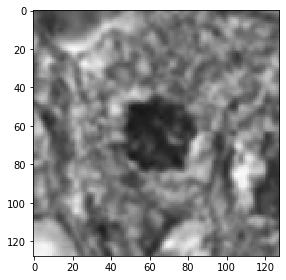

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
corners =  corner_peaks(corner_harris(img3),min_distance=1)

In [ ]:
corners.flatten()

array([126,   1,   1, ...,  55,  73,   9])

In [ ]:
category_corner = []
Array_corner = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            corners =  corner_peaks(corner_harris(img3),min_distance=1)
            x_image_features = np.vstack(np.array(corners))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_corner.append(folder)
            Array_corner.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
cornerArray_np = np.array(Array_corner)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
cor_df = pd.DataFrame(Array_corner)
cor_df

0     1      2      3      4      5      6      7      8      9     ...  \
0     0.0   1.0  0.208  0.000  0.384  0.000  0.488  1.000  0.624  0.000  ...   
1     1.0   0.0  1.000  1.000  0.000  0.144  0.000  0.320  0.000  0.000  ...   
2     0.0   0.0  0.000  1.000  0.000  0.344  1.000  1.000  0.208  1.000  ...   
3     0.0   1.0  1.000  0.000  0.000  0.000  1.000  1.000  0.000  0.824  ...   
4     1.0   1.0  1.000  0.912  0.704  1.000  0.816  0.000  0.000  1.000  ...   
..    ...   ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
427   1.0   0.0  0.080  1.000  0.048  1.000  1.000  0.504  0.000  0.000  ...   
428   1.0   0.0  1.000  1.000  0.688  1.000  0.000  0.000  0.816  0.000  ...   
429   0.0   1.0  0.944  1.000  0.568  0.000  0.000  0.000  0.584  1.000  ...   
430   1.0   0.0  0.000  1.000  1.000  0.488  1.000  1.000  0.648  0.000  ...   
431   0.0   1.0  1.000  0.928  0.984  1.000  1.000  0.648  0.376  1.000  ...   

     1096  1097  1098  1099  1100  1101  1102  1103  1104  1105  
0     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
427   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
428   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
429   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
430   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
431   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[432 rows x 1106 columns]

In [ ]:
cor_df.dropna(thresh=len(cor_df) - 3, axis=1)

0    1      2      3      4      5      6      7      8      9    ...  \
0    0.0  1.0  0.208  0.000  0.384  0.000  0.488  1.000  0.624  0.000  ...   
1    1.0  0.0  1.000  1.000  0.000  0.144  0.000  0.320  0.000  0.000  ...   
2    0.0  0.0  0.000  1.000  0.000  0.344  1.000  1.000  0.208  1.000  ...   
3    0.0  1.0  1.000  0.000  0.000  0.000  1.000  1.000  0.000  0.824  ...   
4    1.0  1.0  1.000  0.912  0.704  1.000  0.816  0.000  0.000  1.000  ...   
..   ...  ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
427  1.0  0.0  0.080  1.000  0.048  1.000  1.000  0.504  0.000  0.000  ...   
428  1.0  0.0  1.000  1.000  0.688  1.000  0.000  0.000  0.816  0.000  ...   
429  0.0  1.0  0.944  1.000  0.568  0.000  0.000  0.000  0.584  1.000  ...   
430  1.0  0.0  0.000  1.000  1.000  0.488  1.000  1.000  0.648  0.000  ...   
431  0.0  1.0  1.000  0.928  0.984  1.000  1.000  0.648  0.376  1.000  ...   

       828    829    830    831    832    833    834    835    836    837  
0    0.040  0.576  0.568  0.552  0.352  0.720  0.200  0.696  0.680  0.352  
1    0.944  0.280  0.480  0.936  0.336  0.952  0.656  0.184  0.480  0.216  
2    0.880  0.768  0.448  0.896  0.488  0.552  0.280  0.848  0.728  0.256  
3    0.088  0.472  0.048  0.336  0.104  0.424  0.496  0.632  0.328  0.976  
4    0.464  0.664  0.080  0.160  0.928  0.528  0.368  0.256  0.120  0.816  
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
427  0.104  0.168  0.328  0.648  0.528  0.808  0.328  0.320  0.136  0.424  
428  0.280  0.584  0.600  0.848  0.112  0.768  0.232  0.592  0.432  0.912  
429  0.760  0.304  0.472  0.232  0.952  0.224  0.128  0.832  0.048  0.632  
430  0.360  0.456  0.216  0.944  0.880  0.120  0.696  0.784  0.752  0.640  
431  0.048  0.944  0.248  0.920  0.024  0.400  0.136  0.624  0.136  0.888  

[432 rows x 838 columns]

In [ ]:
print("Total feature extracted from the each image",len(cornerArray_np[0]))


Total feature extracted from the each image 1004


In [ ]:
temp_corner=ptoa(Array_corner)
corner_features=pca_reduction(temp_corner,numbervalue)

In [ ]:
csvData = []
for id, line in enumerate(corner_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cor_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_cor=pd.read_csv("result_cor_data.csv")
feature_cor['label'] = feature_cor['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cor

value0    value1    value2    value3    value4    value5    value6  \
0   -0.921807 -0.685185 -0.923883 -0.041639  0.979698  0.175086  0.287079   
1   -1.090450 -1.156337  0.243382 -1.210814  0.385794 -0.706903  0.348700   
2    0.167500 -2.217859  0.902868  0.303351  1.001431  0.290424 -1.373801   
3    3.291016  1.365806 -0.162697  1.066267  0.731112 -0.698327  1.302755   
4   -1.874978  1.600937 -0.955266  0.046867 -0.059141 -0.727374  0.203803   
..        ...       ...       ...       ...       ...       ...       ...   
427 -1.341567  1.213123 -0.153142 -0.052046 -0.603036  0.285485 -0.911071   
428 -0.901285 -1.847873 -0.315917  0.400057 -0.192290 -0.252579  0.620717   
429 -3.067234  1.871354  2.083780  0.524498 -1.101017  2.546035  0.269387   
430  0.169840 -1.357641 -0.832887 -0.232182 -0.290667  0.852991 -0.491520   
431  3.680253  1.836804 -2.791618  2.652433  0.810377  0.936245 -0.100575   

       value7    value8    value9  ...  value391  value392  value393  \
0   -1.448572  1.016490  0.915460  ... -0.088750  0.339210  0.287830   
1   -0.992059  0.979166 -0.659813  ... -0.264805 -0.097249 -0.170693   
2   -0.340598  0.083879 -0.520651  ...  0.029872 -0.543512  0.476012   
3    0.053857  0.498261 -0.209370  ...  0.265468  0.060311  0.421770   
4    1.223494 -0.879437 -0.041966  ...  0.138110 -0.215743  0.262200   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.009297 -0.780380 -1.272973  ... -0.039676  0.322114  0.047564   
428  0.560390  0.817967 -0.053671  ...  0.298076 -0.206655 -0.079507   
429 -1.162869  0.401207 -0.840225  ... -0.073563  0.046788 -0.029722   
430  0.467202 -0.815863 -0.888803  ... -0.114261 -0.121971 -0.267751   
431  0.969231 -0.063438 -0.389501  ...  0.370693  0.414266 -0.450978   

     value394  value395  value396  value397  value398  value399  label  
0   -0.456592  0.105733  0.130016  0.159176 -0.298361 -0.057105      1  
1    0.154772  0.098351 -0.216870  0.144650  0.232746  0.043955      1  
2    0.186260  0.004013 -0.085879 -0.016036 -0.469265  0.024637      1  
3    0.141273  0.181854  0.207721 -0.269103  0.130992  0.341607      1  
4    0.006913  0.049804 -0.093671  0.050664  0.080864 -0.220990      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.074036  0.177049  0.177860  0.142156  0.199782 -0.413034      0  
428 -0.226576  0.020439 -0.178122  0.042696 -0.240144 -0.220959      0  
429 -0.244140 -0.121084  0.058129  0.078214  0.397415  0.037048      0  
430 -0.231409 -0.127615  0.263589 -0.166297 -0.236256 -0.043955      0  
431  0.212872 -0.476148 -0.327172  0.108052  0.187491 -0.432664      0  

[432 rows x 401 columns]

In [ ]:
# feature_cor=normalize(feature_cor)

In [ ]:
feature_cor

value0    value1    value2    value3    value4    value5    value6  \
0   -0.921807 -0.685185 -0.923883 -0.041639  0.979698  0.175086  0.287079   
1   -1.090450 -1.156337  0.243382 -1.210814  0.385794 -0.706903  0.348700   
2    0.167500 -2.217859  0.902868  0.303351  1.001431  0.290424 -1.373801   
3    3.291016  1.365806 -0.162697  1.066267  0.731112 -0.698327  1.302755   
4   -1.874978  1.600937 -0.955266  0.046867 -0.059141 -0.727374  0.203803   
..        ...       ...       ...       ...       ...       ...       ...   
427 -1.341567  1.213123 -0.153142 -0.052046 -0.603036  0.285485 -0.911071   
428 -0.901285 -1.847873 -0.315917  0.400057 -0.192290 -0.252579  0.620717   
429 -3.067234  1.871354  2.083780  0.524498 -1.101017  2.546035  0.269387   
430  0.169840 -1.357641 -0.832887 -0.232182 -0.290667  0.852991 -0.491520   
431  3.680253  1.836804 -2.791618  2.652433  0.810377  0.936245 -0.100575   

       value7    value8    value9  ...  value391  value392  value393  \
0   -1.448572  1.016490  0.915460  ... -0.088750  0.339210  0.287830   
1   -0.992059  0.979166 -0.659813  ... -0.264805 -0.097249 -0.170693   
2   -0.340598  0.083879 -0.520651  ...  0.029872 -0.543512  0.476012   
3    0.053857  0.498261 -0.209370  ...  0.265468  0.060311  0.421770   
4    1.223494 -0.879437 -0.041966  ...  0.138110 -0.215743  0.262200   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.009297 -0.780380 -1.272973  ... -0.039676  0.322114  0.047564   
428  0.560390  0.817967 -0.053671  ...  0.298076 -0.206655 -0.079507   
429 -1.162869  0.401207 -0.840225  ... -0.073563  0.046788 -0.029722   
430  0.467202 -0.815863 -0.888803  ... -0.114261 -0.121971 -0.267751   
431  0.969231 -0.063438 -0.389501  ...  0.370693  0.414266 -0.450978   

     value394  value395  value396  value397  value398  value399  label  
0   -0.456592  0.105733  0.130016  0.159176 -0.298361 -0.057105      1  
1    0.154772  0.098351 -0.216870  0.144650  0.232746  0.043955      1  
2    0.186260  0.004013 -0.085879 -0.016036 -0.469265  0.024637      1  
3    0.141273  0.181854  0.207721 -0.269103  0.130992  0.341607      1  
4    0.006913  0.049804 -0.093671  0.050664  0.080864 -0.220990      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.074036  0.177049  0.177860  0.142156  0.199782 -0.413034      0  
428 -0.226576  0.020439 -0.178122  0.042696 -0.240144 -0.220959      0  
429 -0.244140 -0.121084  0.058129  0.078214  0.397415  0.037048      0  
430 -0.231409 -0.127615  0.263589 -0.166297 -0.236256 -0.043955      0  
431  0.212872 -0.476148 -0.327172  0.108052  0.187491 -0.432664      0  

[432 rows x 401 columns]

### classification based on corner features

In [ ]:
cordata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(grid_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(random_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(bogp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(skopt_gp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(bo_tpe(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(genetic(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

In [ ]:
cordata.append(tpot(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]))

In [ ]:
newcsvcres("cor",cordata)

### combining hog and orb and cen

In [ ]:
orbhogcencor_temp=[orb_hog_cen.iloc[:,:-1],feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]]
orb_hog_cen_cor=pd.concat(orbhogcencor_temp, axis=1)
orb_hog_cen_cor

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...  value391  value392  value393  \
0   -0.268069 -0.931471 -1.355695  ... -0.088750  0.339210  0.287830   
1    0.050257  0.107054  1.126562  ... -0.264805 -0.097249 -0.170693   
2    0.477479 -0.698468 -0.307454  ...  0.029872 -0.543512  0.476012   
3    0.170025 -1.146832 -0.008905  ...  0.265468  0.060311  0.421770   
4   -0.435782 -0.520119 -0.396920  ...  0.138110 -0.215743  0.262200   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.322701  0.006529 -0.051505  ... -0.039676  0.322114  0.047564   
428  0.236099  0.507987  0.185405  ...  0.298076 -0.206655 -0.079507   
429  0.612595 -0.685094 -0.556020  ... -0.073563  0.046788 -0.029722   
430 -0.707209  0.809177 -0.119798  ... -0.114261 -0.121971 -0.267751   
431 -0.578040 -0.462534 -1.077838  ...  0.370693  0.414266 -0.450978   

     value394  value395  value396  value397  value398  value399  label  
0   -0.456592  0.105733  0.130016  0.159176 -0.298361 -0.057105      1  
1    0.154772  0.098351 -0.216870  0.144650  0.232746  0.043955      1  
2    0.186260  0.004013 -0.085879 -0.016036 -0.469265  0.024637      1  
3    0.141273  0.181854  0.207721 -0.269103  0.130992  0.341607      1  
4    0.006913  0.049804 -0.093671  0.050664  0.080864 -0.220990      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.074036  0.177049  0.177860  0.142156  0.199782 -0.413034      0  
428 -0.226576  0.020439 -0.178122  0.042696 -0.240144 -0.220959      0  
429 -0.244140 -0.121084  0.058129  0.078214  0.397415  0.037048      0  
430 -0.231409 -0.127615  0.263589 -0.166297 -0.236256 -0.043955      0  
431  0.212872 -0.476148 -0.327172  0.108052  0.187491 -0.432664      0  

[432 rows x 1301 columns]

### classification based on hog,censure,orb corner features

In [ ]:
hog_cen_orb_cordata=[]

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(grid_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(random_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(bogp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(skopt_gp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(bo_tpe(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(genetic(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

In [ ]:
hog_cen_orb_cordata.append(tpot(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1]))

In [ ]:
newcsvcres("hog_cen_orb_cor",hog_cen_orb_cordata)

## edgeExtract 

### extraction 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


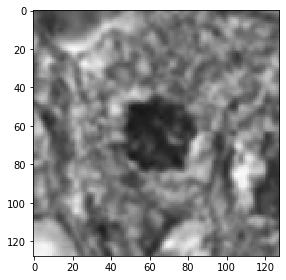

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
edge =  edgeExtract(resized, 100)

In [ ]:
category_edge = []
Array_edge = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            edge =  edgeExtract(img, 100)
            
            category_edge.append(folder)
            Array_edge.append(edge)



# convert the extracted features
# from array to vector
edgeArray_np = np.array(Array_edge)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
edg_df = pd.DataFrame(Array_edge)
edg_df

0          1          2         3         4         5         6    \
0    11.709602  10.206870   9.172521  8.274785  7.864949  7.220921  6.323185   
1    11.361391   9.938747  10.274649  9.306461  8.377791  7.468880  6.579727   
2    11.753145  10.927673   9.787736  8.942610  8.647799  6.505503  5.955189   
3     9.763432   9.422614   8.620690  6.595830  5.813953  5.553328  4.931836   
4     9.204368   8.326833   8.209828  8.424337  6.864275  6.903276  6.337754   
..         ...        ...        ...       ...       ...       ...       ...   
427  11.019671  10.537937   9.433962  9.213167  8.149338  6.884785  7.507025   
428   9.735909   9.499409   7.863618  7.134411  7.252661  6.444620  6.109578   
429   9.029968   8.024448   8.517350  7.314669  6.604890  6.703470  6.644322   
430   9.277943  10.425321   9.713155  8.051434  7.774481  6.646884  5.756677   
431  20.018622  10.875233   8.044693  7.113594  5.567970  5.716946  5.027933   

          7         8         9    ...  190  191  192  193  194  195  196  \
0    5.932865  4.859485  4.274005  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    5.848647  4.900217  4.623592  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    4.697327  4.166667  3.950472  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    4.911788  4.069767  4.310345  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    5.811232  4.972699  4.465679  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
427  5.660377  5.258932  4.315536  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
428  5.636579  5.735120  4.572330  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
429  5.126183  4.909306  4.455836  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
430  4.807122  4.411474  4.411474  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
431  4.599628  3.500931  3.538175  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     197  198  199  
0    0.0  0.0  0.0  
1    0.0  0.0  0.0  
2    0.0  0.0  0.0  
3    0.0  0.0  0.0  
4    0.0  0.0  0.0  
..   ...  ...  ...  
427  0.0  0.0  0.0  
428  0.0  0.0  0.0  
429  0.0  0.0  0.0  
430  0.0  0.0  0.0  
431  0.0  0.0  0.0  

[432 rows x 200 columns]

In [ ]:
edg_df.dropna(thresh=len(edg_df) - 3, axis=1)

0          1          2         3         4         5         6    \
0    11.709602  10.206870   9.172521  8.274785  7.864949  7.220921  6.323185   
1    11.361391   9.938747  10.274649  9.306461  8.377791  7.468880  6.579727   
2    11.753145  10.927673   9.787736  8.942610  8.647799  6.505503  5.955189   
3     9.763432   9.422614   8.620690  6.595830  5.813953  5.553328  4.931836   
4     9.204368   8.326833   8.209828  8.424337  6.864275  6.903276  6.337754   
..         ...        ...        ...       ...       ...       ...       ...   
427  11.019671  10.537937   9.433962  9.213167  8.149338  6.884785  7.507025   
428   9.735909   9.499409   7.863618  7.134411  7.252661  6.444620  6.109578   
429   9.029968   8.024448   8.517350  7.314669  6.604890  6.703470  6.644322   
430   9.277943  10.425321   9.713155  8.051434  7.774481  6.646884  5.756677   
431  20.018622  10.875233   8.044693  7.113594  5.567970  5.716946  5.027933   

          7         8         9    ...  190  191  192  193  194  195  196  \
0    5.932865  4.859485  4.274005  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    5.848647  4.900217  4.623592  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    4.697327  4.166667  3.950472  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    4.911788  4.069767  4.310345  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    5.811232  4.972699  4.465679  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
427  5.660377  5.258932  4.315536  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
428  5.636579  5.735120  4.572330  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
429  5.126183  4.909306  4.455836  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
430  4.807122  4.411474  4.411474  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
431  4.599628  3.500931  3.538175  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     197  198  199  
0    0.0  0.0  0.0  
1    0.0  0.0  0.0  
2    0.0  0.0  0.0  
3    0.0  0.0  0.0  
4    0.0  0.0  0.0  
..   ...  ...  ...  
427  0.0  0.0  0.0  
428  0.0  0.0  0.0  
429  0.0  0.0  0.0  
430  0.0  0.0  0.0  
431  0.0  0.0  0.0  

[432 rows x 200 columns]

In [ ]:
edge_features=pca_reduction(edgeArray_np,n=100)

In [ ]:
csvData = []
for id, line in enumerate(edge_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_edge=pd.read_csv("result_edge_data.csv")
feature_edge['label'] = feature_edge['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_edge

value0    value1    value2    value3    value4    value5    value6  \
0    0.924504 -1.045696  0.815872  0.070452  0.122985  0.300962 -0.331148   
1    0.993885 -2.571283  1.001174 -0.295706 -0.535553 -0.143465  0.149225   
2    1.744107 -1.538597 -0.593783 -0.829227  0.089699 -0.353560 -0.138179   
3   -1.760480  2.119008 -1.506651  0.516974 -0.425867 -0.051162 -0.070315   
4   -2.450275 -0.165029  0.788835 -0.317274 -0.108781  0.584046  0.646159   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.557643 -2.329037  1.032784  0.603338  0.008927  0.004789  0.512853   
428 -1.908065  0.324883  0.744620  1.107976  0.608806 -0.312258 -0.423766   
429 -2.892561  0.591639  0.538522  0.158708 -0.987430  0.414209  0.068137   
430 -1.152057 -1.203838 -1.068634  0.282293 -0.177194 -0.547686 -0.426208   
431  8.036283  4.703912  1.628034  0.265467  0.119261  0.276137  0.222581   

       value7    value8    value9  ...       value91       value92  \
0    0.007597  0.445465  0.088730  ... -5.319749e-17 -3.247614e-17   
1   -0.184846  0.227098  0.047976  ... -4.952672e-17  3.541438e-16   
2    0.657282  0.086669 -0.137419  ... -1.127620e-16  2.598685e-16   
3   -0.552220  0.155346 -0.252317  ...  2.889669e-16  4.065873e-16   
4   -0.203210  0.164662  0.071898  ...  6.309277e-17  1.408438e-16   
..        ...       ...       ...  ...           ...           ...   
427  0.834516 -0.013268 -0.045268  ... -1.359726e-16 -7.500893e-17   
428  0.267061 -0.065914  0.379524  ... -1.999778e-17 -8.883434e-18   
429  0.218759 -0.295033 -0.048123  ...  1.055934e-16 -7.699120e-17   
430  0.028746 -0.429236 -0.410716  ...  5.225318e-17  1.535205e-16   
431 -0.301242 -0.120892 -0.579735  ... -2.508712e-17  7.335257e-17   

          value93       value94       value95       value96       value97  \
0   -3.695536e-16 -2.935367e-16 -5.810539e-16 -2.075891e-16 -2.330630e-16   
1    2.601954e-16 -1.064690e-16  2.388842e-16  2.206653e-16  1.470321e-16   
2    3.748989e-17 -4.294025e-17  1.888108e-16  1.015647e-17 -1.250759e-16   
3    2.001264e-16  3.093396e-16  4.475993e-17  2.032211e-16  3.738902e-16   
4   -2.072182e-16  9.263271e-17 -2.271533e-16  8.854751e-17 -1.936571e-17   
..            ...           ...           ...           ...           ...   
427 -1.827062e-16 -6.842187e-17  2.001673e-17 -1.186626e-16 -1.022206e-16   
428  1.710831e-17  1.378745e-16  1.862957e-16  1.421920e-16 -1.262573e-16   
429 -2.423142e-16  7.982174e-17 -8.689085e-17  1.247345e-16 -1.837256e-16   
430 -2.762464e-18 -4.574507e-17  7.718818e-17 -1.046868e-16  1.003077e-16   
431 -7.107386e-17 -1.973593e-16  1.915876e-18  1.718377e-17  2.873722e-17   

          value98       value99  label  
0   -2.811557e-16  2.845103e-16      1  
1    4.871924e-16 -1.715860e-16      1  
2    2.755961e-16 -2.667369e-16      1  
3    9.937863e-17  2.156126e-16      1  
4   -4.322712e-17  4.763481e-16      1  
..            ...           ...    ...  
427 -4.815537e-17  8.308922e-17      0  
428 -2.475074e-16 -4.452649e-17      0  
429  1.686609e-17 -4.695776e-17      0  
430 -8.088856e-17  3.204807e-17      0  
431 -4.663075e-17 -9.436633e-18      0  

[432 rows x 101 columns]

In [ ]:
feature_edge

value0    value1    value2    value3    value4    value5    value6  \
0    0.924504 -1.045696  0.815872  0.070452  0.122985  0.300962 -0.331148   
1    0.993885 -2.571283  1.001174 -0.295706 -0.535553 -0.143465  0.149225   
2    1.744107 -1.538597 -0.593783 -0.829227  0.089699 -0.353560 -0.138179   
3   -1.760480  2.119008 -1.506651  0.516974 -0.425867 -0.051162 -0.070315   
4   -2.450275 -0.165029  0.788835 -0.317274 -0.108781  0.584046  0.646159   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.557643 -2.329037  1.032784  0.603338  0.008927  0.004789  0.512853   
428 -1.908065  0.324883  0.744620  1.107976  0.608806 -0.312258 -0.423766   
429 -2.892561  0.591639  0.538522  0.158708 -0.987430  0.414209  0.068137   
430 -1.152057 -1.203838 -1.068634  0.282293 -0.177194 -0.547686 -0.426208   
431  8.036283  4.703912  1.628034  0.265467  0.119261  0.276137  0.222581   

       value7    value8    value9  ...       value91       value92  \
0    0.007597  0.445465  0.088730  ... -5.319749e-17 -3.247614e-17   
1   -0.184846  0.227098  0.047976  ... -4.952672e-17  3.541438e-16   
2    0.657282  0.086669 -0.137419  ... -1.127620e-16  2.598685e-16   
3   -0.552220  0.155346 -0.252317  ...  2.889669e-16  4.065873e-16   
4   -0.203210  0.164662  0.071898  ...  6.309277e-17  1.408438e-16   
..        ...       ...       ...  ...           ...           ...   
427  0.834516 -0.013268 -0.045268  ... -1.359726e-16 -7.500893e-17   
428  0.267061 -0.065914  0.379524  ... -1.999778e-17 -8.883434e-18   
429  0.218759 -0.295033 -0.048123  ...  1.055934e-16 -7.699120e-17   
430  0.028746 -0.429236 -0.410716  ...  5.225318e-17  1.535205e-16   
431 -0.301242 -0.120892 -0.579735  ... -2.508712e-17  7.335257e-17   

          value93       value94       value95       value96       value97  \
0   -3.695536e-16 -2.935367e-16 -5.810539e-16 -2.075891e-16 -2.330630e-16   
1    2.601954e-16 -1.064690e-16  2.388842e-16  2.206653e-16  1.470321e-16   
2    3.748989e-17 -4.294025e-17  1.888108e-16  1.015647e-17 -1.250759e-16   
3    2.001264e-16  3.093396e-16  4.475993e-17  2.032211e-16  3.738902e-16   
4   -2.072182e-16  9.263271e-17 -2.271533e-16  8.854751e-17 -1.936571e-17   
..            ...           ...           ...           ...           ...   
427 -1.827062e-16 -6.842187e-17  2.001673e-17 -1.186626e-16 -1.022206e-16   
428  1.710831e-17  1.378745e-16  1.862957e-16  1.421920e-16 -1.262573e-16   
429 -2.423142e-16  7.982174e-17 -8.689085e-17  1.247345e-16 -1.837256e-16   
430 -2.762464e-18 -4.574507e-17  7.718818e-17 -1.046868e-16  1.003077e-16   
431 -7.107386e-17 -1.973593e-16  1.915876e-18  1.718377e-17  2.873722e-17   

          value98       value99  label  
0   -2.811557e-16  2.845103e-16      1  
1    4.871924e-16 -1.715860e-16      1  
2    2.755961e-16 -2.667369e-16      1  
3    9.937863e-17  2.156126e-16      1  
4   -4.322712e-17  4.763481e-16      1  
..            ...           ...    ...  
427 -4.815537e-17  8.308922e-17      0  
428 -2.475074e-16 -4.452649e-17      0  
429  1.686609e-17 -4.695776e-17      0  
430 -8.088856e-17  3.204807e-17      0  
431 -4.663075e-17 -9.436633e-18      0  

[432 rows x 101 columns]

### classification based on edge features

In [ ]:
edgdata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(grid_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(random_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(bogp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(skopt_gp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(bo_tpe(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(genetic(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

In [ ]:
edgdata.append(tpot(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]))

In [ ]:
newcsvcres("Edge",edgdata)

### combining hog and orb and cen

In [ ]:
orbhogcencoredg_temp=[orb_hog_cen_cor.iloc[:,:-1],feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]]
orb_hog_cen_cor_edge=pd.concat(orbhogcencoredg_temp, axis=1)
orb_hog_cen_cor_edge

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...       value91       value92  \
0   -0.268069 -0.931471 -1.355695  ... -5.319749e-17 -3.247614e-17   
1    0.050257  0.107054  1.126562  ... -4.952672e-17  3.541438e-16   
2    0.477479 -0.698468 -0.307454  ... -1.127620e-16  2.598685e-16   
3    0.170025 -1.146832 -0.008905  ...  2.889669e-16  4.065873e-16   
4   -0.435782 -0.520119 -0.396920  ...  6.309277e-17  1.408438e-16   
..        ...       ...       ...  ...           ...           ...   
427  1.322701  0.006529 -0.051505  ... -1.359726e-16 -7.500893e-17   
428  0.236099  0.507987  0.185405  ... -1.999778e-17 -8.883434e-18   
429  0.612595 -0.685094 -0.556020  ...  1.055934e-16 -7.699120e-17   
430 -0.707209  0.809177 -0.119798  ...  5.225318e-17  1.535205e-16   
431 -0.578040 -0.462534 -1.077838  ... -2.508712e-17  7.335257e-17   

          value93       value94       value95       value96       value97  \
0   -3.695536e-16 -2.935367e-16 -5.810539e-16 -2.075891e-16 -2.330630e-16   
1    2.601954e-16 -1.064690e-16  2.388842e-16  2.206653e-16  1.470321e-16   
2    3.748989e-17 -4.294025e-17  1.888108e-16  1.015647e-17 -1.250759e-16   
3    2.001264e-16  3.093396e-16  4.475993e-17  2.032211e-16  3.738902e-16   
4   -2.072182e-16  9.263271e-17 -2.271533e-16  8.854751e-17 -1.936571e-17   
..            ...           ...           ...           ...           ...   
427 -1.827062e-16 -6.842187e-17  2.001673e-17 -1.186626e-16 -1.022206e-16   
428  1.710831e-17  1.378745e-16  1.862957e-16  1.421920e-16 -1.262573e-16   
429 -2.423142e-16  7.982174e-17 -8.689085e-17  1.247345e-16 -1.837256e-16   
430 -2.762464e-18 -4.574507e-17  7.718818e-17 -1.046868e-16  1.003077e-16   
431 -7.107386e-17 -1.973593e-16  1.915876e-18  1.718377e-17  2.873722e-17   

          value98       value99  label  
0   -2.811557e-16  2.845103e-16      1  
1    4.871924e-16 -1.715860e-16      1  
2    2.755961e-16 -2.667369e-16      1  
3    9.937863e-17  2.156126e-16      1  
4   -4.322712e-17  4.763481e-16      1  
..            ...           ...    ...  
427 -4.815537e-17  8.308922e-17      0  
428 -2.475074e-16 -4.452649e-17      0  
429  1.686609e-17 -4.695776e-17      0  
430 -8.088856e-17  3.204807e-17      0  
431 -4.663075e-17 -9.436633e-18      0  

[432 rows x 1401 columns]

### classification based on hog,censure,orb corner and edge features

In [ ]:
hog_cen_ord_cen_edgdata=[]

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(grid_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(random_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(bogp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(skopt_gp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(bo_tpe(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(genetic(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

In [ ]:
hog_cen_ord_cen_edgdata.append(tpot(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1]))

In [ ]:
newcsvcres("hog_cen_ord_cen_edg",hog_cen_ord_cen_edgdata)

## Grayscale Pixel Values as Features

### extraction 

In [ ]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

features = np.reshape(resized, (128*128))

features.shape, features

((16384,),
 array([0.33283936, 0.31625192, 0.29820142, ..., 0.44413873, 0.48544846,
        0.51618594]))

In [ ]:
category_pixel = []
Array_pixel = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            features = np.reshape(resized, (128*128))
            
            category_pixel.append(folder)
            Array_pixel.append(features)



# convert the extracted features
# from array to vector
pixelArray_np = np.array(Array_pixel)

In [ ]:
gry_df = pd.DataFrame(Array_censure)
gry_df

0         1         2         3         4         5         6    \
0    0.0  0.800000  0.038462  0.782609  0.105769  0.373913  0.201923   
1    0.0  0.418605  0.000000  0.860465  0.512195  1.000000  1.000000   
2    0.0  0.272727  0.012500  0.318182  0.025000  0.690909  0.050000   
3    0.0  0.917526  0.020202  0.948454  0.050505  0.989691  0.181818   
4    0.0  0.792453  0.010000  0.764151  0.250000  0.330189  0.460000   
..   ...       ...       ...       ...       ...       ...       ...   
427  0.0  1.000000  0.200000  0.988889  0.266667  0.344444  0.453333   
428  0.0  0.589286  0.035398  0.107143  0.035398  0.776786  0.079646   
429  0.0  0.000000  0.100000  0.368421  0.111111  0.394737  0.155556   
430  0.0  1.000000  0.037736  0.168224  0.037736  0.588785  0.094340   
431  0.0  0.480000  0.055556  0.050000  0.266667  0.120000  0.288889   

          7         8         9    ...  104  105  106  107  108  109  110  \
0    0.060870  0.201923  0.252174  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1    0.000000       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2    0.045455  0.050000  0.281818  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3    0.123711  0.191919  0.536082  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4    1.000000  0.470000  0.773585  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
427  0.477778  0.506667  0.288889  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
428  0.312500  0.123894  0.214286  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
429  0.807018  0.177778  0.912281  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
430  0.897196  0.122642  0.317757  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
431  0.040000  0.377778  0.780000  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     111  112  113  
0    NaN  NaN  NaN  
1    NaN  NaN  NaN  
2    NaN  NaN  NaN  
3    NaN  NaN  NaN  
4    NaN  NaN  NaN  
..   ...  ...  ...  
427  NaN  NaN  NaN  
428  NaN  NaN  NaN  
429  NaN  NaN  NaN  
430  NaN  NaN  NaN  
431  NaN  NaN  NaN  

[432 rows x 114 columns]

In [ ]:
gry_df.dropna(thresh=len(gry_df) - 3, axis=1)

0         1         2         3
0    0.0  0.800000  0.038462  0.782609
1    0.0  0.418605  0.000000  0.860465
2    0.0  0.272727  0.012500  0.318182
3    0.0  0.917526  0.020202  0.948454
4    0.0  0.792453  0.010000  0.764151
..   ...       ...       ...       ...
427  0.0  1.000000  0.200000  0.988889
428  0.0  0.589286  0.035398  0.107143
429  0.0  0.000000  0.100000  0.368421
430  0.0  1.000000  0.037736  0.168224
431  0.0  0.480000  0.055556  0.050000

[432 rows x 4 columns]

In [ ]:
pixel_features=pca_reduction(pixelArray_np,n=numbervalue)

In [ ]:
type(pixel_features)

list

In [ ]:
csvData = []
for id, line in enumerate(pixel_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_pixel=pd.read_csv("result_edge_data.csv")
feature_pixel['label'] = feature_pixel['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_pixel

value0     value1     value2     value3    value4    value5    value6  \
0    -0.969456  11.249387   2.004838   5.490912 -4.593779 -0.103227 -0.011629   
1    17.427956   1.805354   1.966297  -2.477400 -1.916479 -1.146562  0.211015   
2   -10.544874  -2.084153  -2.141705  -2.859729  3.797163 -3.166905 -1.780016   
3   -16.625631   0.200712  -3.051498  -0.026410  4.147573 -6.833697  0.033249   
4     7.115932   0.765389   0.350827  -1.967588 -4.440222  2.491099 -0.204077   
..         ...        ...        ...        ...       ...       ...       ...   
427  -0.338124  -2.080741  -0.209902   1.593416 -0.546175  0.067732  2.082173   
428  -7.169273  -2.937789   4.680328  -0.279130  1.347355 -3.119119 -0.342452   
429  -7.610643   0.755179   2.584787  -1.454055  0.454507 -0.637945 -0.878978   
430  -5.888627   3.771801  13.058457  11.390268  1.356636 -0.678442  1.337216   
431  -8.571829   8.632674   8.362891  -5.234887 -3.353188  6.387384 -5.571810   

       value7    value8    value9  ...  value391  value392  value393  \
0   -8.138519 -3.209910  0.765517  ...  0.041435  0.408607  0.395496   
1    2.163338  3.604239  0.761645  ... -0.694256 -0.910823 -0.001450   
2   -1.652388  0.575118 -3.629712  ... -0.079377  0.215154 -0.243253   
3    1.993286 -2.950230  1.369199  ... -0.010659 -0.320684 -0.243015   
4   -2.361111  1.702021 -1.623247  ...  0.343451 -0.446998  0.289107   
..        ...       ...       ...  ...       ...       ...       ...   
427  2.191925  2.174838 -0.196857  ...  0.451600  0.125889  0.201451   
428 -5.710495 -0.243322  0.143634  ...  0.053138 -0.470090 -0.066337   
429 -0.290145  0.786567 -1.684418  ... -0.022782  0.172951  0.446838   
430  0.284958 -1.683948 -0.341770  ... -0.092332 -0.058818  0.239847   
431 -5.254926 -8.247543 -1.164136  ... -0.007245 -0.287734 -0.205917   

     value394  value395  value396  value397  value398  value399  label  
0   -0.863279 -0.202418  0.579678 -0.585590 -0.083342 -0.129845      1  
1    0.033886 -0.321337 -0.266382  0.187104 -0.445876  0.307566      1  
2    0.098588  0.257130  0.098149 -0.014245  0.146024  0.213376      1  
3   -0.206818 -0.011306  0.085237 -0.115233 -0.028357  0.140062      1  
4   -0.164526 -0.262673  0.076843  0.229891  0.333411  0.108274      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.325286 -0.367590 -0.260102  0.196180 -0.724235 -0.599357      0  
428  0.434064 -0.238256  0.061615 -0.579791 -0.067943  0.431309      0  
429  0.455127  0.434621  0.039109  0.101559  0.152017 -0.022208      0  
430  0.568914 -0.142389 -0.299286 -0.254822  0.020620 -0.041678      0  
431  0.247410  0.408903 -0.398715 -0.022657 -0.476017  0.314411      0  

[432 rows x 401 columns]

### classification based on Pixel  features

In [ ]:
pixdata=[]

In [ ]:
print("results for gridsearch:")
grid_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(grid_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
print("results for random search")
random_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(random_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(bogp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
print("results for skopt")
skopt_gp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(skopt_gp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(bo_tpe(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
print("result for genetic")
genetic(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(genetic(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
print("result for tpot")
tpot(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

In [ ]:
pixdata.append(tpot(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]))

In [ ]:
newcsvcres("Pixel",pixdata)

### combining hog and orb and cen

In [ ]:
temp_comb=[orb_hog_cen_cor_edge.iloc[:,:-1],feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]]
orb_hog_cen_cor_edge_pixel=pd.concat(temp_comb, axis=1)
orb_hog_cen_cor_edge_pixel

value0    value1    value2    value3    value4    value5    value6  \
0    0.091398 -1.866258 -0.959078 -0.155070 -0.226483  0.654383 -1.300899   
1    2.032042 -0.865652  1.518259 -0.022535  0.590447 -0.708745 -0.888726   
2   -2.332667 -1.213420 -1.622251  0.571152 -0.185054  0.558806  0.983400   
3    3.717893  1.374543 -0.014806 -2.116262  0.842313  1.155703 -0.928384   
4    0.055533 -3.661652 -0.023340 -0.432073 -0.541497 -0.466471 -0.572776   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.143495  0.331721  0.089933 -0.984879 -0.509749 -0.359210 -0.194121   
428 -1.582816  0.257961 -1.174752 -0.628018  0.682884 -0.863396 -1.380732   
429 -1.457038 -0.217978  0.038469 -1.979522 -0.516276  0.399855  0.585007   
430 -1.101421  0.894990 -0.027255 -1.021129  0.095558 -0.469776 -0.502372   
431 -1.011871  2.222237  1.390636  1.836484  1.850584 -0.264991 -0.871682   

       value7    value8    value9  ...  value391  value392  value393  \
0   -0.268069 -0.931471 -1.355695  ...  0.041435  0.408607  0.395496   
1    0.050257  0.107054  1.126562  ... -0.694256 -0.910823 -0.001450   
2    0.477479 -0.698468 -0.307454  ... -0.079377  0.215154 -0.243253   
3    0.170025 -1.146832 -0.008905  ... -0.010659 -0.320684 -0.243015   
4   -0.435782 -0.520119 -0.396920  ...  0.343451 -0.446998  0.289107   
..        ...       ...       ...  ...       ...       ...       ...   
427  1.322701  0.006529 -0.051505  ...  0.451600  0.125889  0.201451   
428  0.236099  0.507987  0.185405  ...  0.053138 -0.470090 -0.066337   
429  0.612595 -0.685094 -0.556020  ... -0.022782  0.172951  0.446838   
430 -0.707209  0.809177 -0.119798  ... -0.092332 -0.058818  0.239847   
431 -0.578040 -0.462534 -1.077838  ... -0.007245 -0.287734 -0.205917   

     value394  value395  value396  value397  value398  value399  label  
0   -0.863279 -0.202418  0.579678 -0.585590 -0.083342 -0.129845      1  
1    0.033886 -0.321337 -0.266382  0.187104 -0.445876  0.307566      1  
2    0.098588  0.257130  0.098149 -0.014245  0.146024  0.213376      1  
3   -0.206818 -0.011306  0.085237 -0.115233 -0.028357  0.140062      1  
4   -0.164526 -0.262673  0.076843  0.229891  0.333411  0.108274      1  
..        ...       ...       ...       ...       ...       ...    ...  
427  0.325286 -0.367590 -0.260102  0.196180 -0.724235 -0.599357      0  
428  0.434064 -0.238256  0.061615 -0.579791 -0.067943  0.431309      0  
429  0.455127  0.434621  0.039109  0.101559  0.152017 -0.022208      0  
430  0.568914 -0.142389 -0.299286 -0.254822  0.020620 -0.041678      0  
431  0.247410  0.408903 -0.398715 -0.022657 -0.476017  0.314411      0  

[432 rows x 1801 columns]

### classification based on hog,censure,orb corner and edge  pixel features

In [ ]:
results("orb_hog_cen_cor_edge_pixel,"orb_hog_cen_cor_edge_pixel)

## Combine without pca

### extraction

In [139]:
temp_comb=[hog_df,orb_df,cen_df,cor_df,edg_df,gry_df]
combo_df=pd.concat(temp_comb, axis=1)
combo_df

0         1         2         3         4         5         6    \
0    0.065271  0.060419  0.073369  0.069159  0.126205  0.022763  0.016372   
1    0.050460  0.000000  0.015055  0.019182  0.095482  0.097984  0.083186   
2    0.207576  0.072076  0.044470  0.035890  0.038515  0.018976  0.032627   
3    0.087588  0.030684  0.002529  0.007331  0.051322  0.000000  0.012871   
4    0.074213  0.058557  0.018364  0.218638  0.218638  0.067073  0.218638   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.205091  0.230075  0.105902  0.228347  0.085009  0.040514  0.036706   
428  0.107235  0.040051  0.000000  0.031771  0.065204  0.030679  0.118637   
429  0.073774  0.038426  0.017928  0.013627  0.150593  0.185222  0.166245   
430  0.046163  0.066062  0.227172  0.024650  0.035130  0.003538  0.012574   
431  0.131220  0.037409  0.054016  0.037374  0.032485  0.058846  0.018014   

          7         8         9    ...  104  105  106  107  108  109  110  \
0    0.000000  0.068486  0.210967  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1    0.074277  0.114012  0.240514  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2    0.018221  0.016939  0.258056  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3    0.068512  0.132098  0.195536  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4    0.045377  0.012457  0.064751  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
427  0.104375  0.082528  0.158053  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
428  0.209062  0.058639  0.115080  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
429  0.074106  0.009206  0.149028  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
430  0.009217  0.000000  0.227172  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
431  0.046060  0.085966  0.052387  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     111  112  113  
0    NaN  NaN  NaN  
1    NaN  NaN  NaN  
2    NaN  NaN  NaN  
3    NaN  NaN  NaN  
4    NaN  NaN  NaN  
..   ...  ...  ...  
427  NaN  NaN  NaN  
428  NaN  NaN  NaN  
429  NaN  NaN  NaN  
430  NaN  NaN  NaN  
431  NaN  NaN  NaN  

[432 rows x 25634 columns]

In [140]:
combo_df = combo_df.astype(np.float32)
combo_df=combo_df.replace(np.nan, 0)
temp=combo_df.to_numpy()

In [141]:
combo_features=pca_reduction(temp,n=400)

In [142]:
csvData = []
for id, line in enumerate(combo_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_combo.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [143]:
import pandas as pd

feature_combo=pd.read_csv("result_combo.csv")
feature_combo['label'] = feature_combo['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_combo

value0     value1    value2    value3    value4    value5    value6  \
0     9.452084  -2.748204 -7.091635 -3.643074 -1.364053  0.866628  0.764127   
1    17.907368  11.595326  9.522483  8.674325 -4.538246  4.258720 -2.426168   
2     5.830530  -5.001963 -3.416644  2.166659  1.186122  2.196702 -2.668711   
3    -4.240960  -5.785855  4.082942 -0.350710  0.676577 -4.260595  0.250336   
4     1.705898  -7.681905 -3.390545  3.990727 -1.730136  1.638345 -0.371950   
..         ...        ...       ...       ...       ...       ...       ...   
427  -9.092612  -3.139688  5.418900 -3.529135 -0.500034  4.250584  3.247241   
428 -10.715126  -0.111037  3.281852 -3.509758 -1.657010  1.271942 -2.371342   
429 -16.324404   9.568795 -5.318974  3.861451  1.276591 -0.383384  2.753678   
430   4.464657  -5.957727 -5.057019  2.177815 -0.977078  0.983598 -4.077554   
431  10.663325  -2.410624 -4.703060 -4.634342  8.681586 -0.638986 -2.936915   

       value7    value8    value9  ...  value391  value392  value393  \
0    2.341177 -0.530180 -1.416083  ... -0.039546 -0.496296 -1.474494   
1    6.406745 -4.501707  4.019873  ... -0.341807  0.142787 -0.163536   
2    0.758894  1.437675 -2.024621  ...  0.753724  1.081704 -0.145716   
3    1.686052 -1.558596 -1.726437  ...  0.432461  0.377879  0.437653   
4   -3.152520  1.620144  0.990774  ... -0.411496  0.954946 -0.020211   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.953784  4.826461  0.610136  ...  0.336292 -0.575041  0.144734   
428 -1.022270  0.936655  2.739248  ...  0.825265  0.121147  0.045673   
429  0.870779  1.717960 -0.886496  ... -0.516870  0.113032 -0.088605   
430  0.504373  2.284876 -1.992096  ... -0.321227 -0.196518  1.752729   
431  2.654584  0.064077 -0.481493  ...  0.289144 -1.855137  0.152506   

     value394  value395  value396  value397  value398  value399  label  
0   -2.570699 -0.821953  1.137723  1.857346  1.056028 -0.454148      1  
1    1.598770  1.694222  0.886656  0.224652 -1.267876 -0.434344      1  
2    0.502668  0.242320  0.334140 -1.008101  0.507226  0.774124      1  
3   -0.176518  0.289838  0.057634 -0.478360 -0.124153  0.148290      1  
4   -0.186591  0.811229  0.471076  0.741092 -0.638955 -0.601853      1  
..        ...       ...       ...       ...       ...       ...    ...  
427 -0.483232  0.131274 -0.279329 -0.713351  0.550573  0.130884      0  
428 -0.850362 -0.635921  0.243997 -0.488969 -0.615834  0.182726      0  
429 -0.263630 -0.021639 -0.021465  0.188807  0.140581  0.050591      0  
430  0.186908  1.179091 -0.057877 -0.376799  1.027466  0.611088      0  
431  2.036593 -1.677882 -2.746034  0.754876  0.806967 -0.931654      0  

[432 rows x 401 columns]

### Classification

In [ ]:
results("pca after combine",feature_combo)

## without pca

### extraction data

In [ ]:
temp_comb=[hog_df,orb_df,cen_df,cor_df,edg_df,gry_df]
combo_df=pd.concat(temp_comb, axis=1)
combo_df = combo_df.astype(np.float32)
combo_df=combo_df.replace(np.nan, 0)
temp_pca=combo_df.to_numpy()

In [ ]:
temp_pca_1=temp_pca.tolist()
combo_features=pca_reduction(temp_pca_1,n=200)

In [ ]:
csvData = []
for id, line in enumerate(temp_pca_1):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_combo.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_combo_nopca=pd.read_csv("result_combo.csv")
feature_combo_nopca['label'] = feature_combo_nopca['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_combo_nopca

value0    value1    value2    value3    value4    value5    value6  \
0    0.065271  0.060419  0.073369  0.069159  0.126205  0.022763  0.016372   
1    0.050460  0.000000  0.015055  0.019182  0.095482  0.097984  0.083186   
2    0.207576  0.072076  0.044470  0.035890  0.038515  0.018976  0.032627   
3    0.087588  0.030684  0.002529  0.007331  0.051322  0.000000  0.012871   
4    0.074213  0.058557  0.018364  0.218638  0.218638  0.067074  0.218638   
..        ...       ...       ...       ...       ...       ...       ...   
427  0.205091  0.230075  0.105902  0.228347  0.085009  0.040514  0.036706   
428  0.107235  0.040051  0.000000  0.031771  0.065204  0.030679  0.118637   
429  0.073774  0.038426  0.017928  0.013627  0.150593  0.185222  0.166245   
430  0.046163  0.066062  0.227172  0.024650  0.035130  0.003538  0.012574   
431  0.131220  0.037409  0.054016  0.037374  0.032485  0.058846  0.018014   

       value7    value8    value9  ...  value25625  value25626  value25627  \
0    0.000000  0.068486  0.210967  ...         0.0         0.0         0.0   
1    0.074277  0.114012  0.240514  ...         0.0         0.0         0.0   
2    0.018221  0.016939  0.258056  ...         0.0         0.0         0.0   
3    0.068512  0.132098  0.195536  ...         0.0         0.0         0.0   
4    0.045377  0.012457  0.064751  ...         0.0         0.0         0.0   
..        ...       ...       ...  ...         ...         ...         ...   
427  0.104375  0.082528  0.158053  ...         0.0         0.0         0.0   
428  0.209062  0.058639  0.115080  ...         0.0         0.0         0.0   
429  0.074106  0.009206  0.149028  ...         0.0         0.0         0.0   
430  0.009217  0.000000  0.227172  ...         0.0         0.0         0.0   
431  0.046060  0.085966  0.052387  ...         0.0         0.0         0.0   

     value25628  value25629  value25630  value25631  value25632  value25633  \
0           0.0         0.0         0.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
427         0.0         0.0         0.0         0.0         0.0         0.0   
428         0.0         0.0         0.0         0.0         0.0         0.0   
429         0.0         0.0         0.0         0.0         0.0         0.0   
430         0.0         0.0         0.0         0.0         0.0         0.0   
431         0.0         0.0         0.0         0.0         0.0         0.0   

     label  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
427      0  
428      0  
429      0  
430      0  
431      0  

[432 rows x 25635 columns]

In [ ]:
feature_combo_nopca = feature_combo.loc[:, (feature_combo==0).mean() < .2]
feature_combo_nopca

value0     value1    value2    value3    value4    value5    value6  \
0     9.452084  -2.748204 -7.091635 -3.643074 -1.364053  0.866628  0.764127   
1    17.907368  11.595326  9.522483  8.674325 -4.538246  4.258720 -2.426168   
2     5.830530  -5.001963 -3.416644  2.166659  1.186122  2.196702 -2.668711   
3    -4.240960  -5.785855  4.082942 -0.350710  0.676577 -4.260595  0.250336   
4     1.705898  -7.681905 -3.390545  3.990727 -1.730136  1.638345 -0.371950   
..         ...        ...       ...       ...       ...       ...       ...   
427  -9.092612  -3.139688  5.418900 -3.529135 -0.500034  4.250584  3.247241   
428 -10.715126  -0.111037  3.281852 -3.509758 -1.657010  1.271942 -2.371342   
429 -16.324404   9.568795 -5.318974  3.861451  1.276591 -0.383384  2.753678   
430   4.464657  -5.957727 -5.057019  2.177815 -0.977078  0.983598 -4.077554   
431  10.663325  -2.410624 -4.703060 -4.634342  8.681586 -0.638986 -2.936915   

       value7    value8    value9  ...  value390  value391  value392  \
0    2.341177 -0.530180 -1.416083  ...  0.256818 -0.039546 -0.496296   
1    6.406745 -4.501707  4.019873  ...  0.315698 -0.341807  0.142787   
2    0.758894  1.437675 -2.024621  ... -0.886428  0.753724  1.081704   
3    1.686052 -1.558596 -1.726437  ... -0.770896  0.432461  0.377879   
4   -3.152520  1.620144  0.990774  ... -0.689506 -0.411496  0.954946   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.953784  4.826461  0.610136  ...  0.702450  0.336292 -0.575041   
428 -1.022270  0.936655  2.739248  ... -0.651115  0.825265  0.121147   
429  0.870779  1.717960 -0.886496  ... -0.126208 -0.516870  0.113032   
430  0.504373  2.284876 -1.992096  ... -0.239725 -0.321227 -0.196518   
431  2.654584  0.064077 -0.481493  ...  1.282333  0.289144 -1.855137   

     value393  value394  value395  value396  value397  value398  value399  
0   -1.474494 -2.570699 -0.821953  1.137723  1.857346  1.056028 -0.454148  
1   -0.163536  1.598770  1.694222  0.886656  0.224652 -1.267876 -0.434344  
2   -0.145716  0.502668  0.242320  0.334140 -1.008101  0.507226  0.774124  
3    0.437653 -0.176518  0.289838  0.057634 -0.478360 -0.124153  0.148290  
4   -0.020211 -0.186591  0.811229  0.471076  0.741092 -0.638955 -0.601853  
..        ...       ...       ...       ...       ...       ...       ...  
427  0.144734 -0.483232  0.131274 -0.279329 -0.713351  0.550573  0.130884  
428  0.045673 -0.850362 -0.635921  0.243997 -0.488969 -0.615834  0.182726  
429 -0.088605 -0.263630 -0.021639 -0.021465  0.188807  0.140581  0.050591  
430  1.752729  0.186908  1.179091 -0.057877 -0.376799  1.027466  0.611088  
431  0.152506  2.036593 -1.677882 -2.746034  0.754876  0.806967 -0.931654  

[432 rows x 400 columns]

In [ ]:
feature_combo_nopca

value0     value1    value2    value3    value4    value5    value6  \
0     9.452084  -2.748204 -7.091635 -3.643074 -1.364053  0.866628  0.764127   
1    17.907368  11.595326  9.522483  8.674325 -4.538246  4.258720 -2.426168   
2     5.830530  -5.001963 -3.416644  2.166659  1.186122  2.196702 -2.668711   
3    -4.240960  -5.785855  4.082942 -0.350710  0.676577 -4.260595  0.250336   
4     1.705898  -7.681905 -3.390545  3.990727 -1.730136  1.638345 -0.371950   
..         ...        ...       ...       ...       ...       ...       ...   
427  -9.092612  -3.139688  5.418900 -3.529135 -0.500034  4.250584  3.247241   
428 -10.715126  -0.111037  3.281852 -3.509758 -1.657010  1.271942 -2.371342   
429 -16.324404   9.568795 -5.318974  3.861451  1.276591 -0.383384  2.753678   
430   4.464657  -5.957727 -5.057019  2.177815 -0.977078  0.983598 -4.077554   
431  10.663325  -2.410624 -4.703060 -4.634342  8.681586 -0.638986 -2.936915   

       value7    value8    value9  ...  value390  value391  value392  \
0    2.341177 -0.530180 -1.416083  ...  0.256818 -0.039546 -0.496296   
1    6.406745 -4.501707  4.019873  ...  0.315698 -0.341807  0.142787   
2    0.758894  1.437675 -2.024621  ... -0.886428  0.753724  1.081704   
3    1.686052 -1.558596 -1.726437  ... -0.770896  0.432461  0.377879   
4   -3.152520  1.620144  0.990774  ... -0.689506 -0.411496  0.954946   
..        ...       ...       ...  ...       ...       ...       ...   
427  0.953784  4.826461  0.610136  ...  0.702450  0.336292 -0.575041   
428 -1.022270  0.936655  2.739248  ... -0.651115  0.825265  0.121147   
429  0.870779  1.717960 -0.886496  ... -0.126208 -0.516870  0.113032   
430  0.504373  2.284876 -1.992096  ... -0.239725 -0.321227 -0.196518   
431  2.654584  0.064077 -0.481493  ...  1.282333  0.289144 -1.855137   

     value393  value394  value395  value396  value397  value398  value399  
0   -1.474494 -2.570699 -0.821953  1.137723  1.857346  1.056028 -0.454148  
1   -0.163536  1.598770  1.694222  0.886656  0.224652 -1.267876 -0.434344  
2   -0.145716  0.502668  0.242320  0.334140 -1.008101  0.507226  0.774124  
3    0.437653 -0.176518  0.289838  0.057634 -0.478360 -0.124153  0.148290  
4   -0.020211 -0.186591  0.811229  0.471076  0.741092 -0.638955 -0.601853  
..        ...       ...       ...       ...       ...       ...       ...  
427  0.144734 -0.483232  0.131274 -0.279329 -0.713351  0.550573  0.130884  
428  0.045673 -0.850362 -0.635921  0.243997 -0.488969 -0.615834  0.182726  
429 -0.088605 -0.263630 -0.021639 -0.021465  0.188807  0.140581  0.050591  
430  1.752729  0.186908  1.179091 -0.057877 -0.376799  1.027466  0.611088  
431  0.152506  2.036593 -1.677882 -2.746034  0.754876  0.806967 -0.931654  

[432 rows x 400 columns]

In [ ]:
x=feature_combo_nopca.iloc[:,:-1]
y=feature_combo_nopca.iloc[:,-1]
train_X, test_X, train_Y, test_Y = train_test_split(x, y, stratify=y, test_size=0.2, random_state=2)


In [ ]:
!mkdir matlabdata200

In [ ]:
train_X.to_csv('matlabdata200/input.csv', encoding='utf-8', index=False)
test_X.to_csv('matlabdata200/test.csv', encoding='utf-8', index=False)
train_Y.to_csv('matlabdata200/target_tr.csv', encoding='utf-8', index=False)
test_Y.to_csv('matlabdata200/target_te.csv', encoding='utf-8', index=False)

In [ ]:
feature_combo.to_csv('matlabdata200/feature_combo.csv', encoding='utf-8', index=False)

In [ ]:
!zip -r /content/matlabdata200.zip /content/matlabdata200


In [ ]:
dataset = feature_combo.values
dataset = dataset.astype('float32')
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

### without feature selection

In [130]:
results("No PCA",feature_combo_nopca)

  results for gridsearch:
Splitted Successfully


KeyboardInterrupt: ignored

### Feature selection

In [ ]:
from  Py_FS.evaluation import evaluate

In [ ]:
def evaluate_feature_selection(x,y,solution_agent):
  final_result={"acc":"","recall":"","precision":"","f1_score":""}
  train_X, test_X, train_Y, test_Y = train_test_split(x, y, stratify=y, test_size=0.2, random_state=2)
  result = evaluate(train_X, test_X, train_Y, test_Y, agent=solution_agent, classifier='svm', save_conf_mat=True)
  print("confusion_matrix",result.confusion_matrix)
  final_result["acc"]=result.accuracy
  final_result["recall"]=result.recall
  final_result["precision"]=result.precision
  final_result["f1_score"]=result.f1_score
  return final_result




In [ ]:
def evaluate_feature_selection_knn(x,y,solution_agent):
  final_result={"acc":"","recall":"","precision":"","f1_score":""}
  train_X, test_X, train_Y, test_Y = train_test_split(x, y, stratify=y, test_size=0.2, random_state=2)
  result = evaluate(train_X, test_X, train_Y, test_Y, agent=solution_agent, classifier='knn', save_conf_mat=True)
  print("confusion_matrix",result.confusion_matrix)
  final_result["acc"]=result.accuracy
  final_result["recall"]=result.recall
  final_result["precision"]=result.precision
  final_result["f1_score"]=result.f1_score
  return final_result

#### Cuckoo Search Algorithm (CS)

In [ ]:
from Py_FS.wrapper.nature_inspired.CS import CS as FS

solution_CS = FS(num_agents=15, max_iter=100, train_data=feature_combo.iloc[:,:-1].values, train_label=feature_combo.iloc[:,-1].values, save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_CS.best_agent)
print(res)

#### Red Deer Algorithm (RDA)

In [ ]:
from Py_FS.wrapper.nature_inspired.RDA import RDA as FS

solution_rda = FS(num_agents=30, max_iter=100, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)


In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_rda.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection_knn(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_rda.best_agent)
print(res_knn)

#### Harmony Search (HS)

In [ ]:
from Py_FS.wrapper.nature_inspired.HS import HS as FS
solution_hs = FS(num_agents=30, max_iter=200, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_hs.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection_knn(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_hs.best_agent)
print(res_knn)

#### Whale Optimization Algorithm (WOA)

In [ ]:
from Py_FS.wrapper.nature_inspired.WOA import WOA as FS
solution_woa = FS(num_agents=30, max_iter=200, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_woa.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_woa.best_agent)
print(res_knn)

#### Genetic Algorithm (GA)

In [ ]:
from Py_FS.wrapper.nature_inspired.GA import GA as FS
solution_ga = FS(num_agents=30, max_iter=200, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_ga.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_ga.best_agent)
print(res_knn)

#### Binary Bat Algorithm (BBA)

In [ ]:
solution_bba = FS(num_agents=30, max_iter=200, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_bba.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_bba.best_agent)
print(res_knn)

#### Grey Wolf Optimizer (GWO)

In [ ]:
from Py_FS.wrapper.nature_inspired.GWO import GWO as FS

solution_GWO = FS(num_agents=30, max_iter=100, train_data=feature_combo.iloc[:,:-1], train_label=feature_combo.iloc[:,-1], save_conv_graph=True)

In [ ]:
res=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_GWO.best_agent)
print(res)

In [ ]:
res_knn=evaluate_feature_selection(feature_combo.iloc[:,:-1].values,feature_combo.iloc[:,-1].values,solution_GWO.best_agent)
print(res_knn)

### neuro fuzzy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn import svm
from sklearn.metrics import accuracy_score

## Combination of  features with pca after combining

In [ ]:
def combination(l):
  temp=[]
  for i in l:
    if(i=='h'):
      temp.append(hog_df)
    elif(i=='o'):
      temp.append(orb_df)
    elif(i=='ce'):
      temp.append(cen_df)
    elif(i=='co'):
      temp.append(cor_df)
    elif(i=='e'):
      temp.append(edg_df)
    else:
      temp.append(gry_df)
  return temp

In [ ]:
 from itertools import combinations

	
def n_length_combo(arr, n):
	return list(combinations(arr, n))

p=[100,200,400]
arr = ['h','o','ce','co','e','p']
com = 2
two_combo= n_length_combo([x for x in arr], com)

In [ ]:
two_combo

[('h', 'o'),
 ('h', 'ce'),
 ('h', 'co'),
 ('h', 'e'),
 ('h', 'p'),
 ('o', 'ce'),
 ('o', 'co'),
 ('o', 'e'),
 ('o', 'p'),
 ('ce', 'co'),
 ('ce', 'e'),
 ('ce', 'p'),
 ('co', 'e'),
 ('co', 'p'),
 ('e', 'p')]

###two

In [ ]:
for k in two_combo:
  print("\033[92m Ccombo", k)
  t_combo=combination(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  for l in p:
    print("\033[94m\"PC\"\033[94m",l)
    combo_features=pca_reduction(temp_one,n=l)
    csvData = []
    for id, line in enumerate(combo_features):
      if(id==0):
        temp=[]
        for i in range(0,len(line)):
          temp.append("value"+str(i))
        temp.insert(len(temp),"label")
        csvData.append(temp)

      newImg = line

        # Prepend the category of each image to
        # the begining of the features
      newImg.insert(len(newImg), category[id])
      csvData.append(newImg)


    # Save the csv file
    with open('result_combo.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)

    csvFile.close()

    print("Done Extracting Features")

    feature_combo_t=pd.read_csv("result_combo.csv")
    feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
    results(feature_combo_t)

 Ccombo ('h', 'o')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:78.16091954022988', 'KNN:0.6608695652173914', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 34, 'max_features': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 95}
The KNN Model is trained well with the given images {'n_neighbors': 7}
The svm Model is trained well with the given images {'C': 42.16956562111928, 'kernel': 'rbf'}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7333333333333334', 'KNN:0.6608695652173914', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.7362318840579709', 'KNN:0.6666666666666666', 'svm:0.7826086956521738']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 18.00it/s, best loss: -0.7681159420289855]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 21.0, 'max_features': 25.0, 'min_samples_leaf': 7.0, 'min_samples_split': 2.0, 'n_estimators': 98.0}", "KNN:{'n_neighbors': 9.0}", "svm:{'C': 43.513805241732726, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg    	min     	max     	std      
0  	10    	0.69913	0.672464	0.724638	0.0148252
1  	5     	0.702899	0.663768	0.724638	0.0178326
2  	6     	0.708116	0.684058	0.724638	0.01223

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.643478	0.626087	0.663768	0.0155012
1  	6     	0.650435	0.626087	0.663768	0.0105469
2  	4     	0.658261	0.649275	0.663768	0.00541494
3  	7     	0.662899	0.66087 	0.663768	0.00132828
4  	6     	0.663768	0.663768	0.663768	1.11022e-16
5  	7     	0.663768	0.663768	0.663768	1.11022e-16
Best individual is: {'n_neighbors': 9}
with fitness: 0.663768115942029
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std     
0  	10    	0.724638	0.704348	0.75942	0.021022
1  	4     	0.755072	0.718841	0.75942	0.0121082
2  	3     	0.75942 	0.75942 	0.75942	1.11022e-16
3  	8     	0.75913 	0.756522	0.75942	0.000869565
4  	4     	0.75942 	0.75942 	0.75942	1.11022e-16
5  	6     	0.758261	0.747826	0.75942	0.00347826 
Best individual is: {'C': 21.09346084561512, 'kernel': 'rbf'}
with fitness: 0.7594202898550725
The rf Model is trained well with the given images {'C': 21.09346084561512, 'kernel': 'rbf'}
"Results" ['Random forest:0.7246376811594203', 'KNN:0.663768115942029', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=13, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=135)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=13, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=135)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=13, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.782608695652174	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=1.825870060951884, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.782608695652174	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=1.825870060951884, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.782608695652174	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=1.825870060951884, SVC__kernel=sigmoid)
"Results" ['Random forest:77.01149425287356', 'knn:68.96551724137932', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the gi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7072463768115943', 'KNN:0.6695652173913044', 'svm:0.727536231884058']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7188405797101449', 'KNN:0.663768115942029', 'svm:0.727536231884058']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.93it/s, best loss: -0.727536231884058]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 13.0, 'max_features': 63.0, 'min_samples_leaf': 6.0, 'min_samples_split': 3.0, 'n_estimators': 31.0}", "KNN:{'n_neighbors': 5.0}", "svm:{'C': 57.41843775871685, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 result fo

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.681159	0.623188	0.733333	0.031752
1  	7     	0.7     	0.614493	0.733333	0.0380859
2  	5     	0.728986	0.707246	0.733333	0.00891039
3  	4     	0.733333	0.733333	0.733333	0         
4  	5     	0.728406	0.707246	0.733333	0.00987636
5  	6     	0.728986	0.689855	0.733333	0.0130435 
Best individual is: {'n_estimators': 74, 'max_features': 37, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}
with fitness: 0.7333333333333333
The rf Model is trained well with the given images {'n_estimators': 74, 'max_features': 37, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.654783	0.617391	0.675362	0.0183068
1  	8     	0.668406	0.655072	0.675362	0.00758069
2  	8     	0.674203	0.669565	0.675362	0.00231884
3  	4     	0.675362	0.675362	0.675362	0         
4  	8     	0.675362	0.675362	0.675362	0         
5  	6     	0.673043	0.652174	0.675362	0.00695652
Best individual is: {'n_neighbors': 9}
with fitness: 0.6753623188405797
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.709855	0.698551	0.730435	0.0127305
1  	8     	0.717681	0.698551	0.727536	0.0121739
2  	7     	0.722899	0.704348	0.727536	0.00927536
3  	5     	0.727536	0.727536	0.727536	1.11022e-16
4  	3     	0.727536	0.727536	0.727536	1.11022e-16
5  	8     	0.727536	0.727536	0.727536	1.11022e-16
Best individual is: {'C': 4.588593825503246, 'kernel': 'poly'}
with fitness: 0.7304347826086957
The rf Model is trained well with the given images {'C': 4.588593825503246, 'kernel': 'poly'}
"Results" ['Random forest:0.7333333333333333', 'KNN:0.6753623188405797', 'svm:0.7304347826086957']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifier__max_features=40, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=152)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifier__max_features=40, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=152)

Generation 3 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifi

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6753623188405796	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6753623188405796	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=13.654987177600358, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=13.654987177600358, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=13.654987177600358, SVC__kernel=poly)
"Results" ['Random forest:78.16091954022988', 'knn:75.86206896551724', 'svm:72.41379310344827']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given im

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'linear')])
"Results" ['Random forest:0.672463768115942', 'KNN:0.6695652173913044', 'svm:0.7391304347826088']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6579710144927536', 'KNN:0.6695652173913044', 'svm:0.7391304347826088']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.69it/s, best loss: -0.7391304347826088]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 14.0, 'max_features': 50.0, 'min_samples_leaf': 7.0, 'min_samples_split': 9.0, 'n_estimators': 52.0}", "KNN:{'n_neighbors': 16.0}", "svm:{'C': -90.0622986725689, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 resu

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min    	max     	std      
0  	10    	0.61913	0.55942	0.669565	0.0370108
1  	4     	0.648406	0.62029	0.669565	0.013286 
2  	7     	0.657101	0.643478	0.669565	0.00733854
3  	5     	0.66087 	0.655072	0.669565	0.00388881
4  	9     	0.657391	0.64058 	0.669565	0.00914767
5  	5     	0.663188	0.643478	0.669565	0.00775599
Best individual is: {'n_estimators': 72, 'max_features': 29, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.6695652173913044
The rf Model is trained well with the given images {'n_estimators': 72, 'max_features': 29, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.652174	0.626087	0.672464	0.0168515
1  	4     	0.666377	0.64058 	0.672464	0.00892923
2  	6     	0.670435	0.666667	0.672464	0.00226384
3  	5     	0.671884	0.669565	0.672464	0.00115942
4  	7     	0.672464	0.672464	0.672464	0         
5  	10    	0.672464	0.672464	0.672464	0         
Best individual is: {'n_neighbors': 16}
with fitness: 0.672463768115942
The knn Model is trained well with the given images {'n_neighbors': 16}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.709275	0.681159	0.742029	0.0237628
1  	6     	0.706377	0.686957	0.742029	0.0222661
2  	5     	0.716522	0.695652	0.73913 	0.021014 
3  	6     	0.730435	0.695652	0.73913 	0.0173913
4  	3     	0.734783	0.695652	0.73913 	0.0130435
5  	7     	0.73913 	0.73913 	0.73913 	0        
Best individual is: {'C': 6.048041816016597, 'kernel': 'sigmoid'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'C': 6.048041816016597, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6695652173913044', 'KNN:0.672463768115942', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=18, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=36)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=18, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=36)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, R

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=35.66885527180991, SVC__kernel=linear)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=35.66885527180991, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=35.66885527180991, SVC__kernel=linear)
"Results" ['Random forest:67.81609195402298', 'knn:77.01149425287356', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'ce')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7739130434782608', 'KNN:0.6695652173913044', 'svm:0.8318840579710144']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7739130434782608', 'KNN:0.5971014492753625', 'svm:0.8057971014492754']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:00<00:00, 21.47it/s, best loss: -0.8057971014492754]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 46.0, 'max_features': 47.0, 'min_samples_leaf': 6.0, 'min_samples_split': 3.0, 'n_estimators': 93.0}", "KNN:{'n_neighbors': 2.0}", "svm:{'C': -20.724252303924334, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.744348	0.684058	0.77971	0.0293828
1  	6     	0.767536	0.747826	0.77971	0.0101076
2  	5     	0.774203	0.765217	0.77971	0.00525749
3  	6     	0.776812	0.75942 	0.77971	0.00608005
4  	3     	0.777101	0.753623	0.77971	0.00782609
5  	3     	0.77971 	0.77971 	0.77971	0         
Best individual is: {'n_estimators': 76, 'max_features': 38, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'entropy'}
with fitness: 0.7797101449275362
The rf Model is trained well with the given images {'n_estimators': 76, 'max_features': 38, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.595652	0.553623	0.675362	0.0403357
1  	6     	0.625797	0.573913	0.675362	0.0462035
2  	9     	0.643188	0.582609	0.675362	0.0406717
3  	4     	0.674203	0.669565	0.675362	0.00231884
4  	3     	0.674783	0.669565	0.675362	0.00173913
5  	9     	0.675362	0.675362	0.675362	0         
Best individual is: {'n_neighbors': 1}
with fitness: 0.6753623188405797
The knn Model is trained well with the given images {'n_neighbors': 1}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.735652	0.594203	0.805797	0.0509156
1  	0     	0.767246	0.742029	0.805797	0.0261208
2  	6     	0.797391	0.75942 	0.805797	0.0169237
3  	9     	0.805797	0.805797	0.805797	0        
4  	9     	0.805797	0.805797	0.805797	0        
5  	6     	0.79942 	0.742029	0.805797	0.0191304
Best individual is: {'C': 37.029388042907776, 'kernel': 'rbf'}
with fitness: 0.8057971014492754
The rf Model is trained well with the given images {'C': 37.029388042907776, 'kernel': 'rbf'}
"Results" ['Random forest:0.7797101449275362', 'KNN:0.6753623188405797', 'svm:0.8057971014492754']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7710144927536232	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=69, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=182)

-2	0.7797101449275362	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=13, RandomForestClassifier__max_features=39, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=193), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=89, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=30)

Generation 2 - Current Pareto front scores:

-1	0.7710144

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5971014492753625	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

-2	0.6028985507246377	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16), KNeighborsClassifier__n_neighbors=2)

Generation 2 - Current Pareto front scores:

-1	0.5971014492753625	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

-2	0.6318840579710145	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=7)

Generation 3 - Current Pareto front scores:

-1	0.5971014492753625	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

-2	0.6318840579710145	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=7)
1 operators have been imported by TPOT.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.24807841798294, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.24807841798294, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.24807841798294, SVC__kernel=rbf)
"Results" ['Random forest:73.5632183908046', 'knn:65.51724137931035', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:75.862068

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7478260869565218', 'KNN:0.5565217391304347', 'svm:0.8173913043478261']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7594202898550725', 'KNN:0.5565217391304347', 'svm:0.8057971014492754']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.22it/s, best loss: -0.8057971014492754]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 19.0, 'max_features': 39.0, 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 31.0}", "KNN:{'n_neighbors': 5.0}", "svm:{'C': 32.21541991692394, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.707246	0.64058	0.750725	0.0304555
1  	6     	0.729275	0.686957	0.750725	0.0206266
2  	6     	0.74058 	0.727536	0.750725	0.00945923
3  	10    	0.744058	0.721739	0.750725	0.00944145
4  	5     	0.749275	0.736232	0.750725	0.00434783
5  	7     	0.748696	0.730435	0.750725	0.00608696
Best individual is: {'n_estimators': 77, 'max_features': 29, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'n_estimators': 77, 'max_features': 29, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.538551	0.518841	0.605797	0.0244511
1  	5     	0.56058 	0.536232	0.605797	0.0297635
2  	2     	0.58    	0.533333	0.605797	0.0317639
3  	10    	0.593043	0.536232	0.605797	0.0256387
4  	9     	0.605797	0.605797	0.605797	0        
5  	6     	0.605797	0.605797	0.605797	0        
Best individual is: {'n_neighbors': 3}
with fitness: 0.6057971014492753
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.735072	0.515942	0.805797	0.0833675
1  	6     	0.805797	0.805797	0.805797	0        
2  	5     	0.805797	0.805797	0.805797	0        
3  	5     	0.805797	0.805797	0.805797	0        
4  	6     	0.805797	0.805797	0.805797	0        
5  	7     	0.805797	0.805797	0.805797	0        
Best individual is: {'C': 35.25952013943986, 'kernel': 'rbf'}
with fitness: 0.8057971014492754
The rf Model is trained well with the given images {'C': 35.25952013943986, 'kernel': 'rbf'}
"Results" ['Random forest:0.7507246376811594', 'KNN:0.6057971014492753', 'svm:0.8057971014492754']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7652173913043478	RandomForestClassifier(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=78, RandomForestClassifier__max_features=43, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=94)

Generation 2 - Current Pareto front scores:

-1	0.7681159420289855	RandomForestClassifier(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=78, RandomForestClassifier__max_features=43, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=89)

Generation 3 - Current Pareto front scores:

-1	0.7681159420289855	RandomForestClassifier(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), RandomForestClassifier__c

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.591304347826087	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

Generation 2 - Current Pareto front scores:

-1	0.6057971014492755	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6057971014492755	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.08989544728459, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.08989544728459, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.8057971014492754	SVC(input_matrix, SVC__C=35.08989544728459, SVC__kernel=rbf)
"Results" ['Random forest:71.26436781609196', 'knn:57.47126436781609', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
"Results" ['Random forest:66.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7101449275362318', 'KNN:0.6173913043478261', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7246376811594203', 'KNN:0.5652173913043478', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.93it/s, best loss: -0.7971014492753623]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 30.0, 'max_features': 46.0, 'min_samples_leaf': 10.0, 'min_samples_split': 8.0, 'n_estimators': 43.0}", "KNN:{'n_neighbors': 5.0}", "svm:{'C': -14.130505275529076, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 res

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.634493	0.573913	0.730435	0.0466919
1  	4     	0.669275	0.634783	0.701449	0.0181223
2  	6     	0.677101	0.66087 	0.701449	0.0141525
3  	2     	0.682609	0.634783	0.701449	0.0200503
4  	6     	0.681449	0.565217	0.701449	0.0397524
5  	5     	0.695652	0.666667	0.701449	0.0100409
Best individual is: {'n_estimators': 93, 'max_features': 57, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'entropy'}
with fitness: 0.7304347826086957
The rf Model is trained well with the given images {'n_estimators': 93, 'max_features': 57, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.53913	0.533333	0.571014	0.0115215
1  	3     	0.543478	0.533333	0.571014	0.0112447
2  	6     	0.552464	0.533333	0.571014	0.0129757
3  	5     	0.561739	0.547826	0.571014	0.01136  
4  	9     	0.568696	0.547826	0.571014	0.00695652
5  	7     	0.571014	0.571014	0.571014	1.11022e-16
Best individual is: {'n_neighbors': 4}
with fitness: 0.5710144927536231
The knn Model is trained well with the given images {'n_neighbors': 4}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std    
0  	10    	0.66087	0.498551	0.797101	0.13435
1  	5     	0.732754	0.498551	0.797101	0.117902
2  	6     	0.791014	0.736232	0.797101	0.0182609
3  	6     	0.797101	0.797101	0.797101	0        
4  	3     	0.797101	0.797101	0.797101	0        
5  	6     	0.797101	0.797101	0.797101	0        
Best individual is: {'C': 46.80790935077429, 'kernel': 'rbf'}
with fitness: 0.7971014492753623
The rf Model is trained well with the given images {'C': 46.80790935077429, 'kernel': 'rbf'}
"Results" ['Random forest:0.7304347826086957', 'KNN:0.5710144927536231', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7188405797101449	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=29, RandomForestClassifier__max_features=62, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=104)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086958	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=32, RandomForestClassifier__max_features=59, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=162)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086958	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=32, RandomForestClassifier__max_features=59, RandomForestClassifier__min_samples_leaf=3, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

-4	0.6086956521739131	KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=3), KNeighborsClassifier__n_neighbors=11)

Generation 3 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

-4	0.6086956521739131	KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=3), KNeighborsClassifier__n_neighbors=11)
1 operators have been imported b

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=12.775881907470543, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=12.775881907470543, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=12.775881907470543, SVC__kernel=rbf)
"Results" ['Random forest:70.11494252873564', 'knn:60.91954022988506', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'co')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7913043478260869', 'KNN:0.7043478260869565', 'svm:0.8028985507246377']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7681159420289855', 'KNN:0.6956521739130435', 'svm:0.7855072463768117']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 18.68it/s, best loss: -0.7855072463768117]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 8.0, 'max_features': 41.0, 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 98.0}", "KNN:{'n_neighbors': 11.0}", "svm:{'C': 18.79296667253954, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.726087	0.631884	0.765217	0.0388503
1  	6     	0.751014	0.730435	0.762319	0.00911547
2  	5     	0.754493	0.73913 	0.762319	0.00648783
3  	7     	0.755072	0.736232	0.765217	0.008017  
4  	9     	0.753623	0.73913 	0.768116	0.00978663
5  	9     	0.747246	0.6     	0.768116	0.0492549 
Best individual is: {'n_estimators': 98, 'max_features': 36, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 10, 'criterion': 'gini'}
with fitness: 0.7681159420289855
The rf Model is trained well with the given images {'n_estimators': 98, 'max_features': 36, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 10, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std     
0  	10    	0.68087	0.663768	0.701449	0.012927
1  	6     	0.690725	0.686957	0.701449	0.00594733
2  	7     	0.693913	0.686957	0.701449	0.00610763
3  	7     	0.695362	0.652174	0.701449	0.0145766 
4  	1     	0.70029 	0.695652	0.701449	0.00231884
5  	10    	0.701449	0.701449	0.701449	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.7014492753623188
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.730725	0.666667	0.785507	0.0325219
1  	6     	0.745217	0.721739	0.785507	0.0268316
2  	4     	0.76058 	0.724638	0.785507	0.025342 
3  	6     	0.775072	0.721739	0.785507	0.021504 
4  	4     	0.785507	0.785507	0.785507	0        
5  	6     	0.785507	0.785507	0.785507	0        
Best individual is: {'C': 49.94958836060927, 'kernel': 'rbf'}
with fitness: 0.7855072463768116
The rf Model is trained well with the given images {'C': 49.94958836060927, 'kernel': 'rbf'}
"Results" ['Random forest:0.7681159420289855', 'KNN:0.7014492753623188', 'svm:0.7855072463768116']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7855072463768117	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=50, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=71)

Generation 2 - Current Pareto front scores:

-1	0.7855072463768117	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=50, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=71)

Generation 3 - Current Pareto front scores:

-1	0.7855072463768117	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=50, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestCla

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7014492753623189	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

-2	0.7043478260869565	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=4), KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623189	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

-2	0.7072463768115943	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.7043478260869565	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

-2	0.7072463768115943	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7855072463768117	SVC(input_matrix, SVC__C=39.014506452051684, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7855072463768117	SVC(input_matrix, SVC__C=39.014506452051684, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7855072463768117	SVC(input_matrix, SVC__C=39.014506452051684, SVC__kernel=rbf)
"Results" ['Random forest:79.3103448275862', 'knn:73.5632183908046', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
"Results" ['Random forest:77

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7536231884057972', 'KNN:0.6840579710144926', 'svm:0.7797101449275362']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.7536231884057972', 'KNN:0.6840579710144926', 'svm:0.7652173913043478']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.23it/s, best loss: -0.7652173913043478]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 28.0, 'max_features': 42.0, 'min_samples_leaf': 11.0, 'min_samples_split': 8.0, 'n_estimators': 70.0}", "KNN:{'n_neighbors': 9.0}", "svm:{'C': -5.547965566988081, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min	max     	std      
0  	10    	0.675652	0.6	0.733333	0.0373553
1  	8     	0.711594	0.657971	0.750725	0.0275362
2  	4     	0.73913 	0.727536	0.750725	0.00859849
3  	6     	0.749565	0.744928	0.750725	0.00231884
4  	10    	0.746667	0.730435	0.750725	0.00811594
5  	6     	0.750725	0.750725	0.750725	0         
Best individual is: {'n_estimators': 98, 'max_features': 61, 'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'gini'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'n_estimators': 98, 'max_features': 61, 'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.647536	0.626087	0.686957	0.0214649
1  	6     	0.66058 	0.634783	0.684058	0.0166231
2  	8     	0.678261	0.655072	0.684058	0.0115942
3  	3     	0.684058	0.684058	0.684058	0        
4  	6     	0.684058	0.684058	0.684058	0        
5  	4     	0.684058	0.684058	0.684058	0        
Best individual is: {'n_neighbors': 9}
with fitness: 0.6869565217391305
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.692174	0.556522	0.765217	0.0722176
1  	5     	0.742029	0.692754	0.765217	0.0307301
2  	7     	0.762609	0.73913 	0.765217	0.00782609
3  	7     	0.765217	0.765217	0.765217	0         
4  	10    	0.765217	0.765217	0.765217	0         
5  	3     	0.765217	0.765217	0.765217	0         
Best individual is: {'C': 30.88063292032795, 'kernel': 'rbf'}
with fitness: 0.7652173913043478
The rf Model is trained well with the given images {'C': 30.88063292032795, 'kernel': 'rbf'}
"Results" ['Random forest:0.7507246376811594', 'KNN:0.6869565217391305', 'svm:0.7652173913043478']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.744927536231884	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=194)

Generation 2 - Current Pareto front scores:

-1	0.744927536231884	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=194)

Generation 3 - Current Pareto front scores:

-1	0.744927536231884	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__m

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

Generation 3 - Current Pareto front scores:

-1	0.6869565217391304	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7652173913043478	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=7.2607134402552065, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7652173913043478	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=7.2607134402552065, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7652173913043478	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=7.2607134402552065, SVC__kernel=rbf)
"Results" ['Random forest:77.01149425287356', 'knn:70.11494252873564', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the give

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7159420289855073', 'KNN:0.7159420289855073', 'svm:0.7768115942028985']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7188405797101449', 'KNN:0.7159420289855073', 'svm:0.7768115942028985']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.75it/s, best loss: -0.7768115942028985]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 25.0, 'max_features': 48.0, 'min_samples_leaf': 1.0, 'min_samples_split': 10.0, 'n_estimators': 95.0}", "KNN:{'n_neighbors': 17.0}", "svm:{'C': 23.778091780265402, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 res

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.623188	0.489855	0.747826	0.0675679
1  	6     	0.644638	0.544928	0.747826	0.0632283
2  	10    	0.686377	0.53913 	0.747826	0.0692359
3  	8     	0.710725	0.634783	0.747826	0.0351383
4  	5     	0.732174	0.672464	0.747826	0.0230867
5  	4     	0.746957	0.73913 	0.747826	0.0026087
Best individual is: {'n_estimators': 92, 'max_features': 57, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'entropy'}
with fitness: 0.7478260869565218
The rf Model is trained well with the given images {'n_estimators': 92, 'max_features': 57, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.689855	0.626087	0.715942	0.0246632
1  	2     	0.710725	0.689855	0.715942	0.0079697
2  	7     	0.715072	0.707246	0.715942	0.0026087
3  	7     	0.715942	0.715942	0.715942	0        
4  	10    	0.715942	0.715942	0.715942	0        
5  	3     	0.715942	0.715942	0.715942	0        
Best individual is: {'n_neighbors': 17}
with fitness: 0.7159420289855073
The knn Model is trained well with the given images {'n_neighbors': 17}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.626667	0.501449	0.776812	0.126417
1  	4     	0.764348	0.710145	0.776812	0.0213806
2  	5     	0.776812	0.776812	0.776812	0        
3  	6     	0.776812	0.776812	0.776812	0        
4  	6     	0.776812	0.776812	0.776812	0        
5  	6     	0.776812	0.776812	0.776812	0        
Best individual is: {'C': 1.591692929538513, 'kernel': 'rbf'}
with fitness: 0.7768115942028986
The rf Model is trained well with the given images {'C': 1.591692929538513, 'kernel': 'rbf'}
"Results" ['Random forest:0.7478260869565218', 'KNN:0.7159420289855073', 'svm:0.7768115942028986']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7072463768115943	RandomForestClassifier(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=74, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=154)

-2	0.744927536231884	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=29, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=99), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=11, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=43)

Ge

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7072463768115943	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

-2	0.7159420289855073	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=13)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7072463768115943	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

-2	0.7159420289855073	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=13)

Generation 3 - Current Pareto front scores:

-1	0.7072463768115943	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

-2	0.7159420289855073	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClass

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7478260869565218	SVC(input_matrix, SVC__C=30.53397478601893, SVC__kernel=linear)

-2	0.7623188405797102	SVC(SVC(input_matrix, SVC__C=22.792366473235397, SVC__kernel=rbf), SVC__C=30.53397478601893, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7478260869565218	SVC(input_matrix, SVC__C=30.53397478601893, SVC__kernel=linear)

-2	0.7623188405797102	SVC(SVC(input_matrix, SVC__C=22.792366473235397, SVC__kernel=rbf), SVC__C=30.53397478601893, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7478260869565218	SVC(input_matrix, SVC__C=30.53397478601893, SVC__kernel=linear)

-2	0.7768115942028985	SVC(SVC(input_matrix, SVC__C=22.792366473235397, SVC__kernel=rbf), SVC__C=30.53397478601893, SVC__kernel=rbf)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:72.41379310344827', 'knn:68.96551724137932', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'e')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:79.3103448275862', 'KNN:0.663768115942029', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 35, 'max_features': 50, 'min_samples_leaf': 4, 'min_samples_split': 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7971014492753623', 'KNN:0.663768115942029', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7913043478260869', 'KNN:0.6463768115942029', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 18.36it/s, best loss: -0.7971014492753623]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 19.0, 'max_features': 42.0, 'min_samples_leaf': 4.0, 'min_samples_split': 9.0, 'n_estimators': 73.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': -17.66282404004737, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.768116	0.736232	0.797101	0.0152828
1  	4     	0.777681	0.768116	0.797101	0.0104549
2  	3     	0.777681	0.771014	0.797101	0.00979093
3  	5     	0.785507	0.773913	0.797101	0.0115942 
4  	6     	0.791304	0.73913 	0.797101	0.0173913 
5  	1     	0.796812	0.794203	0.797101	0.000869565
Best individual is: {'n_estimators': 88, 'max_features': 10, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}
with fitness: 0.7971014492753623
The rf Model is trained well with the given images {'n_estimators': 88, 'max_features': 10, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std     
0  	10    	0.630725	0.608696	0.66087	0.014093
1  	7     	0.643478	0.626087	0.66087	0.0118805
2  	7     	0.651594	0.637681	0.66087	0.01136  
3  	3     	0.66087 	0.66087 	0.66087	0        
4  	10    	0.66087 	0.66087 	0.66087	0        
5  	4     	0.66087 	0.66087 	0.66087	0        
Best individual is: {'n_neighbors': 5}
with fitness: 0.6608695652173913
The knn Model is trained well with the given images {'n_neighbors': 5}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.708696	0.663768	0.797101	0.0433864
1  	5     	0.742029	0.672464	0.797101	0.0333774
2  	4     	0.766667	0.736232	0.797101	0.0304348
3  	9     	0.784928	0.736232	0.797101	0.0243478
4  	9     	0.797101	0.797101	0.797101	0        
5  	5     	0.797101	0.797101	0.797101	0        
Best individual is: {'C': 22.105660527509833, 'kernel': 'rbf'}
with fitness: 0.7971014492753623
The rf Model is trained well with the given images {'C': 22.105660527509833, 'kernel': 'rbf'}
"Results" ['Random forest:0.7971014492753623', 'KNN:0.6608695652173913', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7797101449275362	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=70)

-2	0.7913043478260869	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=37, RandomForestClassifier__max_features=29, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=118), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=11, RandomForestClassifier__max_features=3, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=172)

Generation 2 - Current Pareto front scores:

-1	0.78260

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6376811594202899	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

-2	0.655072463768116	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7), KNeighborsClassifier__n_neighbors=7)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6463768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

-2	0.655072463768116	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7), KNeighborsClassifier__n_neighbors=7)

-3	0.6579710144927536	KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7), KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=7)

Generation 3 - Current Pareto front scores:

-1	0.64637681159420

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=13.950534503536966, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7999999999999999	SVC(input_matrix, SVC__C=2.154783063558885, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7999999999999999	SVC(input_matrix, SVC__C=2.154783063558885, SVC__kernel=rbf)
"Results" ['Random forest:78.16091954022988', 'knn:68.96551724137932', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:75.862

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7942028985507248', 'KNN:0.6260869565217392', 'svm:0.8086956521739129']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7826086956521738', 'KNN:0.6202898550724637', 'svm:0.8086956521739129']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.32it/s, best loss: -0.8086956521739129]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 16.0, 'max_features': 44.0, 'min_samples_leaf': 4.0, 'min_samples_split': 2.0, 'n_estimators': 86.0}", "KNN:{'n_neighbors': 5.0}", "svm:{'C': -60.1052222619179, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.713623	0.594203	0.756522	0.0470388
1  	3     	0.737681	0.707246	0.756522	0.0200922
2  	4     	0.754493	0.736232	0.756522	0.00608696
3  	4     	0.756522	0.756522	0.756522	1.11022e-16
4  	4     	0.756522	0.756522	0.756522	1.11022e-16
5  	2     	0.756522	0.756522	0.756522	1.11022e-16
Best individual is: {'n_estimators': 63, 'max_features': 43, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}
with fitness: 0.7565217391304347
The rf Model is trained well with the given images {'n_estimators': 63, 'max_features': 43, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max    	std      
0  	10    	0.593623	0.55942	0.62029	0.0192181
1  	5     	0.603188	0.585507	0.62029	0.013248 
2  	3     	0.614493	0.608696	0.62029	0.00366641
3  	7     	0.613913	0.585507	0.62029	0.00985507
4  	9     	0.61971 	0.614493	0.62029	0.00173913
5  	9     	0.62029 	0.62029 	0.62029	0         
Best individual is: {'n_neighbors': 9}
with fitness: 0.6202898550724638
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.713333	0.594203	0.808696	0.0910666
1  	5     	0.793043	0.730435	0.808696	0.0313043
2  	8     	0.808696	0.808696	0.808696	0        
3  	10    	0.808696	0.808696	0.808696	0        
4  	6     	0.808696	0.808696	0.808696	0        
5  	10    	0.808696	0.808696	0.808696	0        
Best individual is: {'C': 34.32121792852584, 'kernel': 'rbf'}
with fitness: 0.808695652173913
The rf Model is trained well with the given images {'C': 34.32121792852584, 'kernel': 'rbf'}
"Results" ['Random forest:0.7565217391304347', 'KNN:0.6202898550724638', 'svm:0.808695652173913']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7797101449275363	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=12, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=171)

-2	0.7826086956521738	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=78, RandomForestClassifier__max_features=59, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=185), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=39, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=189)

Generation 2 - Current Paret

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6202898550724637	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.6202898550724638	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6202898550724638	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7304347826086955	SVC(input_matrix, SVC__C=35.252444256782105, SVC__kernel=linear)

-2	0.8086956521739129	SVC(SVC(input_matrix, SVC__C=19.776510603235977, SVC__kernel=rbf), SVC__C=20.17678783494898, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086955	SVC(input_matrix, SVC__C=35.252444256782105, SVC__kernel=linear)

-2	0.8086956521739129	SVC(SVC(input_matrix, SVC__C=19.776510603235977, SVC__kernel=rbf), SVC__C=20.17678783494898, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.8086956521739129	SVC(input_matrix, SVC__C=19.46739719221158, SVC__kernel=rbf)
"Results" ['Random forest:82.75862068965517', 'knn:62.06896551724138', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'c

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7623188405797102', 'KNN:0.5884057971014492', 'svm:0.8086956521739131']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7536231884057972', 'KNN:0.6028985507246377', 'svm:0.8086956521739131']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 12.26it/s, best loss: -0.8086956521739131]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 44.0, 'max_features': 60.0, 'min_samples_leaf': 9.0, 'min_samples_split': 6.0, 'n_estimators': 44.0}", "KNN:{'n_neighbors': 1.0}", "svm:{'C': -104.043160177915, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.645217	0.484058	0.721739	0.0732732
1  	8     	0.692464	0.626087	0.771014	0.0444235
2  	8     	0.729275	0.675362	0.771014	0.0350281
3  	2     	0.751594	0.704348	0.771014	0.0235497
4  	8     	0.747536	0.573913	0.771014	0.0589547
5  	8     	0.771014	0.771014	0.771014	1.11022e-16
Best individual is: {'n_estimators': 87, 'max_features': 63, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}
with fitness: 0.7710144927536232
The rf Model is trained well with the given images {'n_estimators': 87, 'max_features': 63, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.589275	0.562319	0.64058	0.0293613
1  	5     	0.59971 	0.568116	0.64058	0.0271119
2  	10    	0.622899	0.568116	0.64058	0.0220156
3  	8     	0.633913	0.573913	0.64058	0.02     
4  	5     	0.64058 	0.64058 	0.64058	0        
5  	4     	0.64058 	0.64058 	0.64058	0        
Best individual is: {'n_neighbors': 3}
with fitness: 0.6405797101449275
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.726087	0.573913	0.808696	0.0772805
1  	6     	0.787246	0.681159	0.808696	0.0376633
2  	8     	0.808696	0.808696	0.808696	0        
3  	8     	0.808696	0.808696	0.808696	0        
4  	5     	0.795072	0.672464	0.808696	0.0408696
5  	5     	0.808696	0.808696	0.808696	0        
Best individual is: {'C': 47.50150238521581, 'kernel': 'rbf'}
with fitness: 0.808695652173913
The rf Model is trained well with the given images {'C': 47.50150238521581, 'kernel': 'rbf'}
"Results" ['Random forest:0.7710144927536232', 'KNN:0.6405797101449275', 'svm:0.808695652173913']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811594	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=195)

Generation 2 - Current Pareto front scores:

-1	0.7565217391304347	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=43, RandomForestClassifier__max_features=55, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=115)

Generation 3 - Current Pareto front scores:

-1	0.7797101449275363	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=48, RandomForestClassifier__min_sample

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6144927536231884	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

Generation 2 - Current Pareto front scores:

-1	0.6144927536231884	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

Generation 3 - Current Pareto front scores:

-1	0.6144927536231884	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8086956521739131	SVC(input_matrix, SVC__C=9.957319029607115, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8086956521739131	SVC(input_matrix, SVC__C=9.957319029607115, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.8086956521739131	SVC(input_matrix, SVC__C=9.957319029607115, SVC__kernel=rbf)
"Results" ['Random forest:80.45977011494253', 'knn:62.06896551724138', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'p')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Ra

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.782608695652174', 'KNN:0.6782608695652174', 'svm:0.8086956521739131']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.7768115942028987', 'KNN:0.6347826086956522', 'svm:0.7942028985507247']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:00<00:00, 21.42it/s, best loss: -0.7942028985507247]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 33.0, 'max_features': 21.0, 'min_samples_leaf': 5.0, 'min_samples_split': 8.0, 'n_estimators': 90.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': -18.370062726027957, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.743768	0.721739	0.77971	0.0161489
1  	9     	0.757101	0.736232	0.788406	0.0187758
2  	8     	0.770145	0.744928	0.788406	0.0151752
3  	9     	0.777681	0.75942 	0.788406	0.011452 
4  	3     	0.788406	0.788406	0.788406	1.11022e-16
5  	8     	0.788406	0.788406	0.788406	1.11022e-16
Best individual is: {'n_estimators': 99, 'max_features': 14, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy'}
with fitness: 0.7884057971014493
The rf Model is trained well with the given images {'n_estimators': 99, 'max_features': 14, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.595362	0.55942	0.678261	0.0345937
1  	7     	0.62087 	0.585507	0.678261	0.0325051
2  	3     	0.658841	0.602899	0.678261	0.0307861
3  	7     	0.678261	0.678261	0.678261	1.11022e-16
4  	4     	0.678261	0.678261	0.678261	1.11022e-16
5  	3     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 1}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 1}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.75913	0.736232	0.794203	0.0139883
1  	3     	0.76058	0.736232	0.794203	0.0131685
2  	4     	0.750725	0.602899	0.794203	0.0511494
3  	7     	0.775942	0.750725	0.794203	0.0184258
4  	6     	0.790725	0.75942 	0.794203	0.0104348
5  	4     	0.794203	0.794203	0.794203	0        
Best individual is: {'C': 44.37505361659127, 'kernel': 'rbf'}
with fitness: 0.7942028985507247
The rf Model is trained well with the given images {'C': 44.37505361659127, 'kernel': 'rbf'}
"Results" ['Random forest:0.7884057971014493', 'KNN:0.6782608695652174', 'svm:0.7942028985507247']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.782608695652174	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=38, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=132)

Generation 2 - Current Pareto front scores:

-1	0.782608695652174	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=38, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=132)

Generation 3 - Current Pareto front scores:

-1	0.782608695652174	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=38, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=1, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7942028985507247	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.70941966440874, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7942028985507247	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.70941966440874, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7942028985507247	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.70941966440874, SVC__kernel=rbf)
"Results" ['Random forest:79.3103448275862', 'knn:65.51724137931035', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7594202898550725', 'KNN:0.582608695652174', 'svm:0.8144927536231884']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7507246376811594', 'KNN:0.5594202898550725', 'svm:0.8144927536231884']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.02it/s, best loss: -0.8144927536231884]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 25.0, 'max_features': 33.0, 'min_samples_leaf': 6.0, 'min_samples_split': 4.0, 'n_estimators': 84.0}", "KNN:{'n_neighbors': 5.0}", "svm:{'C': 95.72421247762112, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.729565	0.710145	0.768116	0.0164504
1  	4     	0.735652	0.704348	0.768116	0.0164887
2  	7     	0.743478	0.730435	0.768116	0.0111698
3  	5     	0.751014	0.73913 	0.768116	0.0111848
4  	4     	0.766087	0.756522	0.768116	0.0041094
5  	7     	0.763768	0.727536	0.768116	0.0121082
Best individual is: {'n_estimators': 97, 'max_features': 41, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.7681159420289855
The rf Model is trained well with the given images {'n_estimators': 97, 'max_features': 41, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.553043	0.518841	0.588406	0.0256583
1  	6     	0.56058 	0.542029	0.588406	0.0199221
2  	8     	0.573043	0.544928	0.588406	0.0186973
3  	5     	0.587536	0.57971 	0.588406	0.0026087
4  	4     	0.588406	0.588406	0.588406	1.11022e-16
5  	9     	0.58087 	0.513043	0.588406	0.0226087  
Best individual is: {'n_neighbors': 3}
with fitness: 0.5884057971014492
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.681449	0.515942	0.814493	0.110704
1  	6     	0.770725	0.730435	0.814493	0.0362597
2  	9     	0.798261	0.727536	0.814493	0.0325671
3  	8     	0.806957	0.73913 	0.814493	0.0226087
4  	7     	0.814783	0.814493	0.817391	0.000869565
5  	10    	0.814493	0.814493	0.814493	1.11022e-16
Best individual is: {'C': 1.746612142983367, 'kernel': 'rbf'}
with fitness: 0.8173913043478261
The rf Model is trained well with the given images {'C': 1.746612142983367, 'kernel': 'rbf'}
"Results" ['Random forest:0.7681159420289855', 'KNN:0.5884057971014492', 'svm:0.8173913043478261']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811594	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=43, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=178)

-2	0.7536231884057972	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=40, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=94), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=72, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=89)

Generation 2 - Current Pareto front scores:

-1	0.773913043

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 2 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 3 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8144927536231884	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.52667271621558, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8144927536231884	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.52667271621558, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.8144927536231884	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.52667271621558, SVC__kernel=rbf)
"Results" ['Random forest:73.5632183908046', 'knn:58.620689655172406', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given ima

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7072463768115943', 'KNN:0.5710144927536231', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7246376811594203', 'KNN:0.5652173913043478', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.49it/s, best loss: -0.7971014492753623]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 15.0, 'max_features': 54.0, 'min_samples_leaf': 4.0, 'min_samples_split': 9.0, 'n_estimators': 96.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': 94.6059940051866, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.595072	0.484058	0.707246	0.0635973
1  	5     	0.652174	0.573913	0.707246	0.0513461
2  	6     	0.666957	0.623188	0.707246	0.0314449
3  	8     	0.683188	0.634783	0.715942	0.0252041
4  	6     	0.693043	0.672464	0.715942	0.0196781
5  	6     	0.710435	0.684058	0.715942	0.0111848
Best individual is: {'n_estimators': 87, 'max_features': 52, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'gini'}
with fitness: 0.7159420289855073
The rf Model is trained well with the given images {'n_estimators': 87, 'max_features': 52, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.554203	0.527536	0.617391	0.0291531
1  	7     	0.577971	0.536232	0.617391	0.0256387
2  	6     	0.606377	0.565217	0.617391	0.0178585
3  	4     	0.617391	0.617391	0.617391	1.11022e-16
4  	5     	0.617391	0.617391	0.617391	1.11022e-16
5  	5     	0.617391	0.617391	0.617391	1.11022e-16
Best individual is: {'n_neighbors': 3}
with fitness: 0.6173913043478261
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.745797	0.498551	0.797101	0.0863267
1  	6     	0.797101	0.797101	0.797101	0        
2  	3     	0.797101	0.797101	0.797101	0        
3  	8     	0.797101	0.797101	0.797101	0        
4  	6     	0.797101	0.797101	0.797101	0        
5  	3     	0.797101	0.797101	0.797101	0        
Best individual is: {'C': 33.93223883537042, 'kernel': 'rbf'}
with fitness: 0.7971014492753623
The rf Model is trained well with the given images {'C': 33.93223883537042, 'kernel': 'rbf'}
"Results" ['Random forest:0.7159420289855073', 'KNN:0.6173913043478261', 'svm:0.7971014492753623']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.727536231884058	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=197)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=46, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=171)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=46, RandomForestClassifier__max_features=50, RandomForestClassifier__min_sample

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.5884057971014492	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=17.09261093440166, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=17.09261093440166, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=17.09261093440166, SVC__kernel=rbf)

-2	0.8115942028985508	SVC(SVC(input_matrix, SVC__C=46.326453753976374, SVC__kernel=poly), SVC__C=8.63892068260479, SVC__kernel=rbf)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:67.81609195402298', 'knn:58.620689655172406', 'svm:85.0574712643678']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('o', 'ce')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
"Results" ['Random forest:72.41379310344827', 'KNN:0.6753623188405796', 'svm:74.71264367816092']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 26, 'max_features': 7, 'min_samples_leaf': 4, 'min_sampl

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6753623188405796', 'svm:0.7043478260869565']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6869565217391305', 'KNN:0.672463768115942', 'svm:0.7072463768115941']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.28it/s, best loss: -0.7043478260869565]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 19.0, 'max_features': 9.0, 'min_samples_leaf': 7.0, 'min_samples_split': 4.0, 'n_estimators': 95.0}", "KNN:{'n_neighbors': 19.0}", "svm:{'C': 93.06245715550921, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.661159	0.634783	0.689855	0.0166736
1  	6     	0.667536	0.631884	0.689855	0.0197888
2  	9     	0.689855	0.689855	0.689855	0        
3  	4     	0.689855	0.689855	0.689855	0        
4  	8     	0.689855	0.689855	0.689855	0        
5  	6     	0.689855	0.689855	0.689855	0        
Best individual is: {'n_estimators': 91, 'max_features': 1, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.6898550724637681
The rf Model is trained well with the given images {'n_estimators': 91, 'max_features': 1, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.658261	0.608696	0.675362	0.0177948
1  	7     	0.670145	0.657971	0.675362	0.0056205
2  	4     	0.673043	0.672464	0.675362	0.00115942
3  	5     	0.670435	0.643478	0.675362	0.00907853
4  	6     	0.673043	0.66087 	0.675362	0.00425998
5  	10    	0.675362	0.675362	0.675362	0         
Best individual is: {'n_neighbors': 3}
with fitness: 0.6753623188405797
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.66087	0.617391	0.704348	0.0369835
1  	7     	0.688696	0.617391	0.704348	0.026477 
2  	4     	0.702319	0.684058	0.704348	0.00608696
3  	5     	0.704348	0.704348	0.704348	0         
4  	8     	0.704348	0.704348	0.704348	0         
5  	8     	0.704348	0.704348	0.704348	0         
Best individual is: {'C': 22.200619181186664, 'kernel': 'poly'}
with fitness: 0.7043478260869566
The rf Model is trained well with the given images {'C': 22.200619181186664, 'kernel': 'poly'}
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6753623188405797', 'svm:0.7043478260869566']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6956521739130435	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=54, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=157)

Generation 2 - Current Pareto front scores:

-1	0.7072463768115943	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=50, RandomForestClassifier__max_features=29, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=193)

Generation 3 - Current Pareto front scores:

-1	0.7072463768115943	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=50, RandomForestClassifier__max_features=29, RandomForestClassifier__min_samples_leaf=1, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

-2	0.6753623188405798	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12), KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

-2	0.6753623188405798	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12), KNeighborsClassifier__n_neighbors=17)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

-2	0.6753623188405798	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12), KNeighborsClas

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=46.95936237507491, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=46.95936237507491, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=46.95936237507491, SVC__kernel=poly)
"Results" ['Random forest:74.71264367816092', 'knn:74.71264367816092', 'svm:66.66666666666666']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the give

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6811594202898551', 'KNN:0.672463768115942', 'svm:0.6753623188405798']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6811594202898551', 'KNN:0.6811594202898551', 'svm:0.6608695652173913']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 14.54it/s, best loss: -0.6695652173913044]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 29.0, 'max_features': 33.0, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'n_estimators': 93.0}", "KNN:{'n_neighbors': 12.0}", "svm:{'C': 1.3564751849469958, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.650725	0.628986	0.672464	0.0132353
1  	7     	0.66058 	0.643478	0.672464	0.0108802
2  	9     	0.661739	0.64058 	0.672464	0.0125712
3  	8     	0.662899	0.623188	0.672464	0.0157191
4  	7     	0.669565	0.643478	0.672464	0.00869565
5  	3     	0.672464	0.672464	0.672464	0         
Best individual is: {'n_estimators': 11, 'max_features': 43, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.672463768115942
The rf Model is trained well with the given images {'n_estimators': 11, 'max_features': 43, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.649275	0.608696	0.672464	0.0174877
1  	4     	0.662029	0.646377	0.672464	0.0090924
2  	9     	0.666957	0.657971	0.672464	0.00376812
3  	4     	0.670725	0.666667	0.672464	0.00265657
4  	7     	0.672464	0.672464	0.672464	0         
5  	7     	0.672464	0.672464	0.672464	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.672463768115942
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.646087	0.594203	0.66087	0.0224315
1  	4     	0.661739	0.657971	0.681159	0.00661607
2  	9     	0.662899	0.655072	0.681159	0.00935204
3  	6     	0.667826	0.655072	0.681159	0.0110145 
4  	5     	0.681159	0.681159	0.681159	1.11022e-16
5  	6     	0.678841	0.657971	0.681159	0.00695652 
Best individual is: {'C': 2.9493383328059286, 'kernel': 'poly'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'C': 2.9493383328059286, 'kernel': 'poly'}
"Results" ['Random forest:0.672463768115942', 'KNN:0.672463768115942', 'svm:0.6811594202898551']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6695652173913044	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=81, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=168)

Generation 2 - Current Pareto front scores:

-1	0.6695652173913044	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=81, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=168)

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=94, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=7, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6608695652173913	SVC(input_matrix, SVC__C=17.912706541794744, SVC__kernel=rbf)

-2	0.6608695652173914	SVC(SVC(input_matrix, SVC__C=6.688655649613834, SVC__kernel=rbf), SVC__C=2.267331081429047, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	SVC(input_matrix, SVC__C=1.0094130506582422, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.6666666666666666	SVC(input_matrix, SVC__C=1.0094130506582422, SVC__kernel=sigmoid)
"Results" ['Random forest:67.81609195402298', 'knn:75.86206896551724', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6666666666666666', 'KNN:0.6695652173913044', 'svm:0.6811594202898551']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.663768115942029', 'KNN:0.6695652173913044', 'svm:0.6695652173913044']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.85it/s, best loss: -0.6695652173913044]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 17.0, 'max_features': 50.0, 'min_samples_leaf': 6.0, 'min_samples_split': 10.0, 'n_estimators': 72.0}", "KNN:{'n_neighbors': 15.0}", "svm:{'C': 30.89943983457894, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 re

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.643478	0.608696	0.672464	0.0201652
1  	4     	0.663478	0.637681	0.672464	0.0114079
2  	4     	0.666087	0.64058 	0.672464	0.0127536
3  	3     	0.667536	0.623188	0.672464	0.0147826
4  	6     	0.672464	0.672464	0.672464	0        
5  	7     	0.672464	0.672464	0.672464	0        
Best individual is: {'n_estimators': 79, 'max_features': 29, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'gini'}
with fitness: 0.672463768115942
The rf Model is trained well with the given images {'n_estimators': 79, 'max_features': 29, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.647826	0.591304	0.666667	0.0200922
1  	9     	0.657971	0.655072	0.666667	0.00467377
2  	6     	0.655652	0.591304	0.666667	0.0220671 
3  	4     	0.663768	0.637681	0.666667	0.00869565
4  	4     	0.666667	0.666667	0.666667	1.11022e-16
5  	8     	0.666667	0.666667	0.666667	1.11022e-16
Best individual is: {'n_neighbors': 15}
with fitness: 0.6666666666666666
The knn Model is trained well with the given images {'n_neighbors': 15}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.668986	0.657971	0.672464	0.00384536
1  	7     	0.664928	0.649275	0.672464	0.00881083
2  	9     	0.666957	0.649275	0.672464	0.00715302
3  	8     	0.669855	0.657971	0.672464	0.0043863 
4  	7     	0.672174	0.669565	0.672464	0.000869565
5  	8     	0.671014	0.657971	0.672464	0.00434783 
Best individual is: {'C': 23.917347252849364, 'kernel': 'sigmoid'}
with fitness: 0.672463768115942
The rf Model is trained well with the given images {'C': 23.917347252849364, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.672463768115942', 'KNN:0.6666666666666666', 'svm:0.672463768115942']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6579710144927536	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=70, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=111)

-2	0.663768115942029	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=19, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=26), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=98, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=141)

Generation 2 - Current Pareto front scores:

-1	0.66

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)

Generation 2 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)

Generation 3 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=23.849667857617906, SVC__kernel=sigmoid)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=23.849667857617906, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=23.849667857617906, SVC__kernel=sigmoid)
"Results" ['Random forest:68.96551724137932', 'knn:75.86206896551724', 'svm:60.91954022988506']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('o', 'co')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained w

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.690435	0.678261	0.704348	0.0079697
1  	6     	0.691014	0.672464	0.704348	0.0107832
2  	3     	0.698261	0.684058	0.704348	0.00715302
3  	5     	0.701159	0.684058	0.704348	0.00600357
4  	6     	0.702609	0.672464	0.718841	0.0109379 
5  	10    	0.707536	0.704348	0.718841	0.00571684
Best individual is: {'n_estimators': 93, 'max_features': 29, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'n_estimators': 93, 'max_features': 29, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.658841	0.631884	0.681159	0.0171014
1  	4     	0.673333	0.663768	0.681159	0.00789024
2  	9     	0.67971 	0.666667	0.681159	0.00434783
3  	7     	0.676232	0.643478	0.681159	0.011452  
4  	7     	0.681159	0.681159	0.681159	1.11022e-16
5  	8     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'n_neighbors': 19}
with fitness: 0.6811594202898551
The knn Model is trained well with the given images {'n_neighbors': 19}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min    	max     	std      
0  	10    	0.69913	0.66087	0.721739	0.0165395
1  	6     	0.704638	0.686957	0.721739	0.0100785
2  	4     	0.708986	0.666667	0.721739	0.0176883
3  	4     	0.721739	0.721739	0.721739	0        
4  	1     	0.721739	0.721739	0.721739	0        
5  	4     	0.721739	0.721739	0.721739	0        
Best individual is: {'C': 2.16146675397641, 'kernel': 'poly'}
with fitness: 0.7217391304347827
The rf Model is trained well with the given images {'C': 2.16146675397641, 'kernel': 'poly'}
"Results" ['Random forest:0.7188405797101449', 'KNN:0.6811594202898551', 'svm:0.7217391304347827']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=75, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=84)

Generation 2 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=75, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=84)

Generation 3 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=75, RandomForestClassifier__max_fea

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=4.113342210709331, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=4.113342210709331, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=4.113342210709331, SVC__kernel=poly)

-2	0.7246376811594203	SVC(SVC(input_matrix, SVC__C=45.84049668877053, SVC__kernel=linear), SVC__C=4.113342210709331, SVC__kernel=rbf)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:77.01149425287356', 'knn:72.41379310344827', 'svm:75.86206896551724']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:73.5632183908046', 'KNN:0.672463768115942', 'svm:75.86206896551724']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 26, 'max_features': 28, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators':

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7043478260869565', 'KNN:0.663768115942029', 'svm:0.7043478260869565']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6753623188405798', 'KNN:0.6579710144927536', 'svm:0.7043478260869565']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 14.62it/s, best loss: -0.7043478260869565]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 42.0, 'max_features': 8.0, 'min_samples_leaf': 6.0, 'min_samples_split': 3.0, 'n_estimators': 90.0}", "KNN:{'n_neighbors': 20.0}", "svm:{'C': 67.46781122437172, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.665507	0.623188	0.692754	0.0185688
1  	2     	0.67971 	0.66087 	0.692754	0.0127832
2  	5     	0.683768	0.649275	0.692754	0.0131844
3  	7     	0.686667	0.663768	0.704348	0.0124638
4  	6     	0.696812	0.681159	0.704348	0.00821881
5  	7     	0.69942 	0.666667	0.704348	0.011452  
Best individual is: {'n_estimators': 86, 'max_features': 28, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.7043478260869566
The rf Model is trained well with the given images {'n_estimators': 86, 'max_features': 28, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.647246	0.614493	0.666667	0.0140841
1  	5     	0.653623	0.64058 	0.666667	0.00891039
2  	7     	0.657971	0.649275	0.666667	0.00869565
3  	6     	0.666667	0.666667	0.666667	1.11022e-16
4  	4     	0.666667	0.666667	0.666667	1.11022e-16
5  	6     	0.666667	0.666667	0.666667	1.11022e-16
Best individual is: {'n_neighbors': 19}
with fitness: 0.6666666666666666
The knn Model is trained well with the given images {'n_neighbors': 19}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.673623	0.617391	0.704348	0.0324896
1  	6     	0.698261	0.657971	0.707246	0.014862 
2  	6     	0.705507	0.704348	0.707246	0.00141999
3  	2     	0.705797	0.704348	0.707246	0.00144928
4  	10    	0.706377	0.704348	0.707246	0.00132828
5  	4     	0.707246	0.707246	0.707246	0         
Best individual is: {'C': 6.956231200442787, 'kernel': 'poly'}
with fitness: 0.7072463768115942
The rf Model is trained well with the given images {'C': 6.956231200442787, 'kernel': 'poly'}
"Results" ['Random forest:0.7043478260869566', 'KNN:0.6666666666666666', 'svm:0.7072463768115942']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=91, RandomForestClassifier__max_features=57, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=141)

-2	0.7043478260869565	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=62, RandomForestClassifier__max_features=47, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=184), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=12, RandomForestClassifier__max_features=14, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=143)

Generation 2 - Current Pareto front scores:

-1	0.6898

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.6666666666666666	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13), KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.6666666666666666	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13), KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.6666666666666666	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13), KNeighborsClassifier__n_neighbors=19)
1 operators have been imported 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=16.89922325170886, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=16.89922325170886, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7043478260869565	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=16.89922325170886, SVC__kernel=poly)
"Results" ['Random forest:72.41379310344827', 'knn:78.16091954022988', 'svm:74.71264367816092']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given i

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.663768115942029', 'KNN:0.663768115942029', 'svm:0.6869565217391305']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6579710144927536', 'KNN:0.663768115942029', 'svm:0.6840579710144926']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.98it/s, best loss: -0.6840579710144926]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 36.0, 'max_features': 33.0, 'min_samples_leaf': 8.0, 'min_samples_split': 10.0, 'n_estimators': 68.0}", "KNN:{'n_neighbors': 6.0}", "svm:{'C': -14.887691902006333, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 res

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max    	std     
0  	10    	0.626957	0.55942	0.64058	0.024699
1  	5     	0.638261	0.623188	0.64058	0.00531313
2  	2     	0.64087 	0.631884	0.652174	0.00457384
3  	6     	0.63971 	0.608696	0.657971	0.0120943 
4  	5     	0.648696	0.623188	0.678261	0.0145391 
5  	7     	0.652174	0.626087	0.678261	0.0130917 
Best individual is: {'n_estimators': 51, 'max_features': 39, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'gini'}
with fitness: 0.6782608695652174
The rf Model is trained well with the given images {'n_estimators': 51, 'max_features': 39, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.642319	0.631884	0.655072	0.00769072
1  	5     	0.648406	0.634783	0.655072	0.00698665
2  	7     	0.654493	0.649275	0.655072	0.00173913
3  	8     	0.655072	0.655072	0.655072	0         
4  	6     	0.655072	0.655072	0.655072	0         
5  	5     	0.655072	0.655072	0.655072	0         
Best individual is: {'n_neighbors': 17}
with fitness: 0.6550724637681159
The knn Model is trained well with the given images {'n_neighbors': 17}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.672464	0.643478	0.684058	0.0150054
1  	5     	0.683188	0.675362	0.684058	0.0026087
2  	9     	0.684058	0.684058	0.684058	0        
3  	6     	0.684058	0.684058	0.684058	0        
4  	7     	0.681449	0.666667	0.684058	0.00556793
5  	8     	0.683188	0.675362	0.684058	0.0026087 
Best individual is: {'C': 18.112231469697747, 'kernel': 'rbf'}
with fitness: 0.6840579710144927
The rf Model is trained well with the given images {'C': 18.112231469697747, 'kernel': 'rbf'}
"Results" ['Random forest:0.6782608695652174', 'KNN:0.6550724637681159', 'svm:0.6840579710144927']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=184)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=184)

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=6, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 2 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	SVC(input_matrix, SVC__C=19.237045504704586, SVC__kernel=rbf)

-2	0.6927536231884058	SVC(SVC(input_matrix, SVC__C=21.943799382069223, SVC__kernel=poly), SVC__C=13.521809494466364, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	SVC(input_matrix, SVC__C=19.237045504704586, SVC__kernel=rbf)

-2	0.6927536231884058	SVC(SVC(input_matrix, SVC__C=21.943799382069223, SVC__kernel=poly), SVC__C=13.521809494466364, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144926	SVC(input_matrix, SVC__C=19.237045504704586, SVC__kernel=rbf)

-2	0.6927536231884058	SVC(SVC(input_matrix, SVC__C=21.943799382069223, SVC__kernel=poly), SVC__C=13.521809494466364, SVC__kernel=linear)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:63.2183908045977', 'knn:77.01149425287356', 'svm:74.71264367816092']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('o', 'e')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
"Results" ['Random forest:75.86206896551724', 'KNN:0.6666666666666666', 'svm:64.36781609195403']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 37, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_spl

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])
"Results" ['Random forest:0.672463768115942', 'KNN:0.663768115942029', 'svm:0.6927536231884058']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6840579710144928', 'KNN:0.6666666666666666', 'svm:0.6927536231884058']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.96it/s, best loss: -0.7130434782608696]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 29.0, 'max_features': 35.0, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 57.0}", "KNN:{'n_neighbors': 10.0}", "svm:{'C': -6.503755436011251, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 resu

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max    	std      
0  	10    	0.64058	0.628986	0.66087	0.0104509
1  	6     	0.653913	0.637681	0.663768	0.00851996
2  	9     	0.65913 	0.637681	0.663768	0.00724058
3  	8     	0.66029 	0.64058 	0.663768	0.00671063
4  	7     	0.663768	0.663768	0.663768	1.11022e-16
5  	3     	0.66    	0.626087	0.663768	0.0113043  
Best individual is: {'n_estimators': 82, 'max_features': 28, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.663768115942029
The rf Model is trained well with the given images {'n_estimators': 82, 'max_features': 28, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.649855	0.631884	0.666667	0.00941917
1  	6     	0.653333	0.631884	0.666667	0.0104669 
2  	10    	0.658841	0.646377	0.666667	0.00799601
3  	3     	0.665217	0.652174	0.666667	0.00434783
4  	6     	0.666667	0.666667	0.666667	1.11022e-16
5  	5     	0.666667	0.666667	0.666667	1.11022e-16
Best individual is: {'n_neighbors': 10}
with fitness: 0.6666666666666666
The knn Model is trained well with the given images {'n_neighbors': 10}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.653043	0.602899	0.692754	0.0253039
1  	2     	0.664348	0.64058 	0.692754	0.013583 
2  	6     	0.67913 	0.66087 	0.692754	0.0151198
3  	6     	0.681739	0.614493	0.692754	0.0243478
4  	3     	0.692754	0.692754	0.692754	1.11022e-16
5  	4     	0.692754	0.692754	0.692754	1.11022e-16
Best individual is: {'C': 26.928663041210406, 'kernel': 'poly'}
with fitness: 0.6927536231884058
The rf Model is trained well with the given images {'C': 26.928663041210406, 'kernel': 'poly'}
"Results" ['Random forest:0.663768115942029', 'KNN:0.6666666666666666', 'svm:0.6927536231884058']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=34, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=36)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=34, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=36)

-2	0.672463768115942	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=18, RandomForestClassifier__max_features=59, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=6,

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10)

-2	0.6695652173913044	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10), KNeighborsClassifier__n_neighbors=10)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10)

-2	0.6695652173913044	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10), KNeighborsClassifier__n_neighbors=10)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	SVC(input_matrix, SVC__C=23.804021951830133, SVC__kernel=poly)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6927536231884058	SVC(input_matrix, SVC__C=23.804021951830133, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.6927536231884058	SVC(input_matrix, SVC__C=23.804021951830133, SVC__kernel=poly)
"Results" ['Random forest:73.5632183908046', 'knn:74.71264367816092', 'svm:74.71264367816092']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_nei

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6579710144927536', 'KNN:0.672463768115942', 'svm:0.6811594202898551']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6579710144927536', 'KNN:0.672463768115942', 'svm:0.6898550724637681']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.30it/s, best loss: -0.6898550724637681]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 10.0, 'max_features': 55.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 91.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': -92.14096551939042, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 resu

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.617971	0.556522	0.643478	0.0296673
1  	5     	0.629275	0.588406	0.66087 	0.0201423
2  	8     	0.634203	0.602899	0.66087 	0.0166408
3  	7     	0.648986	0.628986	0.66087 	0.00956522
4  	10    	0.654203	0.626087	0.66087 	0.0108493 
5  	7     	0.658261	0.634783	0.66087 	0.00782609
Best individual is: {'n_estimators': 16, 'max_features': 34, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}
with fitness: 0.6608695652173913
The rf Model is trained well with the given images {'n_estimators': 16, 'max_features': 34, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.65971	0.646377	0.672464	0.0073557
1  	5     	0.664928	0.66087 	0.672464	0.00347826
2  	6     	0.666957	0.66087 	0.672464	0.00329212
3  	5     	0.668406	0.666667	0.672464	0.00265657
4  	4     	0.668406	0.666667	0.672464	0.00265657
5  	8     	0.668986	0.666667	0.672464	0.00283999
Best individual is: {'n_neighbors': 7}
with fitness: 0.672463768115942
The knn Model is trained well with the given images {'n_neighbors': 7}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.661449	0.628986	0.689855	0.0231812
1  	5     	0.676812	0.628986	0.689855	0.0190181
2  	8     	0.690435	0.689855	0.695652	0.00173913
3  	4     	0.692174	0.689855	0.695652	0.00283999
4  	7     	0.695072	0.689855	0.707246	0.00481543
5  	3     	0.69913 	0.695652	0.707246	0.00531313
Best individual is: {'C': 5.83937307706563, 'kernel': 'sigmoid'}
with fitness: 0.7072463768115942
The rf Model is trained well with the given images {'C': 5.83937307706563, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6608695652173913', 'KNN:0.672463768115942', 'svm:0.7072463768115942']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.663768115942029	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=22, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=182)

-2	0.681159420289855	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=194), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=37, RandomForestClassifier__max_features=62, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=30)

Generation 2 - Current Pareto front scores:

-1	0.6637681159

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

-2	0.6753623188405796	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3), KNeighborsClassifier__n_neighbors=7)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

-2	0.6753623188405796	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KN

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=41.26223789412515, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=41.26223789412515, SVC__kernel=poly)

-2	0.6927536231884058	SVC(SVC(input_matrix, SVC__C=5.604031311372987, SVC__kernel=rbf), SVC__C=41.26223789412515, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=41.26223789412515, SVC__kernel=poly)

-2	0.7014492753623189	SVC(SVC(input_matrix, SVC__C=17.367749827821875, SVC__kernel=linear), SVC__C=41.26223789412515, SVC__kernel=poly)
"Results" ['Random forest:67.81609195402298', 'knn:72.41379310344827', 'svm:71.26436781609196']
"--------------------------------------------------------------------------------------------------"
"PC" 400


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:73.5632183908046', 'KNN:0.6666666666666666', 'svm:72.41379310344827']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 36, 'max_features': 54, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 78}
The KNN Model is trained well with the given images {'n_neighbors': 13}
The svm Model is trained well with the given images {'C': 7.610074504152465, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6811594202898551', 'svm:0.6840579710144926']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6695652173913044', 'KNN:0.6811594202898551', 'svm:0.6869565217391305']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.66it/s, best loss: -0.7014492753623189]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 15.0, 'max_features': 20.0, 'min_samples_leaf': 9.0, 'min_samples_split': 8.0, 'n_estimators': 49.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': 3.2409912961819844, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 r

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.625507	0.594203	0.66087	0.0188651
1  	6     	0.644638	0.605797	0.66087	0.0166105
2  	6     	0.654203	0.637681	0.66087	0.00879652
3  	10    	0.66087 	0.66087 	0.66087	0         
4  	6     	0.66058 	0.657971	0.66087	0.000869565
5  	8     	0.66058 	0.657971	0.66087	0.000869565
Best individual is: {'n_estimators': 23, 'max_features': 25, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'entropy'}
with fitness: 0.6608695652173913
The rf Model is trained well with the given images {'n_estimators': 23, 'max_features': 25, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.652754	0.62029	0.681159	0.0195217
1  	6     	0.668406	0.655072	0.681159	0.00724058
2  	3     	0.676812	0.666667	0.681159	0.00664141
3  	5     	0.681159	0.681159	0.681159	1.11022e-16
4  	5     	0.678841	0.657971	0.681159	0.00695652 
5  	6     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'n_neighbors': 7}
with fitness: 0.6811594202898551
The knn Model is trained well with the given images {'n_neighbors': 7}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.673333	0.663768	0.681159	0.00449976
1  	6     	0.675942	0.675362	0.681159	0.00173913
2  	10    	0.675942	0.675362	0.681159	0.00173913
3  	6     	0.677101	0.675362	0.681159	0.00265657
4  	7     	0.67942 	0.675362	0.681159	0.00265657
5  	4     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'C': 18.902642570641966, 'kernel': 'linear'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'C': 18.902642570641966, 'kernel': 'linear'}
"Results" ['Random forest:0.6608695652173913', 'KNN:0.6811594202898551', 'svm:0.6811594202898551']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6608695652173914	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=22, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=146)

Generation 2 - Current Pareto front scores:

-1	0.6608695652173914	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=22, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=146)

Generation 3 - Current Pareto front scores:

-1	0.6608695652173914	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=22, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.66250669468665, SVC__kernel=linear)

-2	0.6927536231884058	SVC(SVC(input_matrix, SVC__C=21.274445343038078, SVC__kernel=sigmoid), SVC__C=3.4271113155645683, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.66250669468665, SVC__kernel=linear)

-2	0.6956521739130435	SVC(CombineDFs(input_matrix, SVC(input_matrix, SVC__C=21.274445343038078, SVC__kernel=sigmoid)), SVC__C=3.4271113155645683, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.66250669468665, SVC__kernel=linear)

-2	0.6956521739130435	SVC(CombineDFs(input_matrix, SVC(input_matrix, SVC__C=21.274445343038078, SVC__kernel=sigmoid)), SVC__C=3.4271113155645683, SVC__kernel=sigmoid)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:72.41379310344827', 'knn:71.26436781609196', 'svm:70.11494252873564']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('o', 'p')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:70.11494252873564', 'KNN:0.6666666666666666', 'svm:71.26436781609196']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 40, 'max_features': 16, 'min_samples_leaf': 5, 'min_samples

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.670145	0.637681	0.701449	0.0188205
1  	8     	0.670725	0.64058 	0.701449	0.0150725
2  	9     	0.67942 	0.657971	0.704348	0.0125812
3  	6     	0.685507	0.672464	0.704348	0.0110183
4  	6     	0.688986	0.672464	0.704348	0.0127041
5  	8     	0.696812	0.666667	0.704348	0.0122427
Best individual is: {'n_estimators': 75, 'max_features': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.7043478260869566
The rf Model is trained well with the given images {'n_estimators': 75, 'max_features': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.658841	0.646377	0.678261	0.00996107
1  	5     	0.668696	0.655072	0.678261	0.00820346
2  	6     	0.674203	0.672464	0.678261	0.00265657
3  	8     	0.675942	0.672464	0.678261	0.00283999
4  	6     	0.677681	0.672464	0.678261	0.00173913
5  	5     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 17}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 17}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.663768	0.623188	0.692754	0.0197867
1  	10    	0.674493	0.623188	0.695652	0.0192726
2  	5     	0.684638	0.672464	0.695652	0.00932955
3  	9     	0.687536	0.672464	0.695652	0.00932955
4  	9     	0.688986	0.672464	0.695652	0.010211  
5  	5     	0.693333	0.672464	0.695652	0.00695652
Best individual is: {'C': 1.5547099107415585, 'kernel': 'poly'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'C': 1.5547099107415585, 'kernel': 'poly'}
"Results" ['Random forest:0.7043478260869566', 'KNN:0.6782608695652174', 'svm:0.6956521739130435']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=164)

Generation 2 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=49, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=67)

Generation 3 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=49, RandomForestClassifier__min_samp

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=14)

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=14)

-2	0.6782608695652174	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18), KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.7014492753623188	SVC(input_matrix, SVC__C=2.991993002002019, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623188	SVC(input_matrix, SVC__C=2.991993002002019, SVC__kernel=poly)

-2	0.7043478260869565	SVC(CombineDFs(SVC(input_matrix, SVC__C=33.698777520032266, SVC__kernel=sigmoid), input_matrix), SVC__C=28.366864324160595, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7014492753623188	SVC(input_matrix, SVC__C=2.991993002002019, SVC__kernel=poly)

-2	0.7043478260869565	SVC(CombineDFs(SVC(input_matrix, SVC__C=33.698777520032266, SVC__kernel=sigmoid), input_matrix), SVC__C=28.366864324160595, SVC__kernel=sigmoid)
"Results" ['Random forest:73.5632183908046', 'knn:63.2183908045977', 'svm:70.11494252873564']
"--------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
"Results" ['Random forest:70.11494252873564', 'KNN:0.6927536231884058', 'svm:71.26436781609196']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 7, 'max_features': 24, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 80}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 13.786553093425692, 'kernel': 'poly'}
"Results" ['Random fore

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7014492753623188', 'KNN:0.6927536231884058', 'svm:0.7014492753623189']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6927536231884058', 'KNN:0.6927536231884058', 'svm:0.7014492753623189']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 14.47it/s, best loss: -0.7072463768115941]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 40.0, 'max_features': 17.0, 'min_samples_leaf': 7.0, 'min_samples_split': 4.0, 'n_estimators': 100.0}", "KNN:{'n_neighbors': 11.0}", "svm:{'C': -1.8629237631880482, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 r

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.668696	0.64058	0.684058	0.0130949
1  	8     	0.671014	0.652174	0.684058	0.00927989
2  	9     	0.677391	0.64058 	0.718841	0.0188762 
3  	7     	0.683768	0.652174	0.698551	0.0118416 
4  	7     	0.689565	0.66087 	0.715942	0.0135614 
5  	6     	0.703188	0.695652	0.715942	0.00842078
Best individual is: {'n_estimators': 92, 'max_features': 33, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'n_estimators': 92, 'max_features': 33, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.66029	0.605797	0.678261	0.0198207
1  	6     	0.676522	0.666667	0.678261	0.00347826
2  	4     	0.678261	0.678261	0.678261	1.11022e-16
3  	5     	0.678261	0.678261	0.678261	1.11022e-16
4  	6     	0.678261	0.678261	0.678261	1.11022e-16
5  	5     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 13}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.657101	0.617391	0.701449	0.0262171
1  	6     	0.68087 	0.652174	0.701449	0.0208394
2  	9     	0.693333	0.66087 	0.701449	0.0162319
3  	9     	0.701449	0.701449	0.701449	0        
4  	6     	0.701449	0.701449	0.701449	0        
5  	8     	0.701449	0.701449	0.701449	0        
Best individual is: {'C': 18.28597470035635, 'kernel': 'poly'}
with fitness: 0.7014492753623188
The rf Model is trained well with the given images {'C': 18.28597470035635, 'kernel': 'poly'}
"Results" ['Random forest:0.7188405797101449', 'KNN:0.6782608695652174', 'svm:0.7014492753623188']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=11, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=145)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=11, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=145)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=11, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=3, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7014492753623189	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.862514962740597, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623189	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.862514962740597, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7014492753623189	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.862514962740597, SVC__kernel=poly)

-2	0.7130434782608696	SVC(SVC(input_matrix, SVC__C=20.797488234694388, SVC__kernel=linear), SVC__C=47.093713060235096, SVC__kernel=poly)
"Results" ['Random forest:67.81609195402298', 'knn:72.41379310344827', 'svm:71.26436781609196']
"--------------------------------------------------------------------------------------------------"
"PC" 400


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:71.26436781609196', 'KNN:0.6666666666666666', 'svm:78.16091954022988']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 9, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 59}
The KNN Model is trained well with the given images {'n_neighbors': 19}
The svm Model is trained well with the given images {'C': 0.9104274067529561, 'kernel': 'sigmoid'}
"Results" ['Random forest

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.615072	0.571014	0.649275	0.0253619
1  	7     	0.633913	0.611594	0.655072	0.0133491
2  	9     	0.636522	0.62029 	0.652174	0.00861801
3  	4     	0.648116	0.634783	0.666667	0.0105469 
4  	6     	0.658551	0.64058 	0.684058	0.0128847 
5  	7     	0.66    	0.652174	0.672464	0.00722315
Best individual is: {'n_estimators': 48, 'max_features': 27, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.6840579710144927
The rf Model is trained well with the given images {'n_estimators': 48, 'max_features': 27, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.650145	0.637681	0.655072	0.00698665
1  	7     	0.655072	0.655072	0.655072	0         
2  	4     	0.655072	0.655072	0.655072	0         
3  	9     	0.655072	0.655072	0.655072	0         
4  	6     	0.655072	0.655072	0.655072	0         
5  	4     	0.655072	0.655072	0.655072	0         
Best individual is: {'n_neighbors': 4}
with fitness: 0.6550724637681159
The knn Model is trained well with the given images {'n_neighbors': 4}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.664928	0.657971	0.669565	0.00567998
1  	5     	0.667246	0.657971	0.669565	0.00463768
2  	7     	0.669855	0.669565	0.672464	0.000869565
3  	8     	0.666377	0.637681	0.669565	0.00956522 
4  	6     	0.669565	0.669565	0.669565	0          
5  	3     	0.669565	0.669565	0.669565	0          
Best individual is: {'C': 0.26964559913387753, 'kernel': 'rbf'}
with fitness: 0.672463768115942
The rf Model is trained well with the given images {'C': 0.26964559913387753, 'kernel': 'rbf'}
"Results" ['Random forest:0.6840579710144927', 'KNN:0.6550724637681159', 'svm:0.672463768115942']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.663768115942029	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=45, RandomForestClassifier__max_features=49, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=162)

-2	0.6666666666666666	RandomForestClassifier(CombineDFs(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=27, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=91), input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=77)

Generation 2 - Current Pareto f

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)

Generation 2 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)

Generation 3 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=6)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6869565217391305	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=3.115666262250122, SVC__kernel=sigmoid)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6869565217391305	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=3.115666262250122, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.6869565217391305	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=3.115666262250122, SVC__kernel=sigmoid)
"Results" ['Random forest:67.81609195402298', 'knn:75.86206896551724', 'svm:75.86206896551724']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('ce', 'co')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6927536231884058', 'KNN:0.7014492753623188', 'svm:0.6898550724637681']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6898550724637681', 'KNN:0.6985507246376811', 'svm:0.6753623188405796']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:03<00:00,  5.82it/s, best loss: -0.6869565217391305]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 10.0, 'max_features': 9.0, 'min_samples_leaf': 8.0, 'min_samples_split': 4.0, 'n_estimators': 59.0}", "KNN:{'n_neighbors': 16.0}", "svm:{'C': 0.8956677647419725, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.664638	0.626087	0.692754	0.0201256
1  	5     	0.685217	0.672464	0.692754	0.00700466
2  	5     	0.688406	0.681159	0.692754	0.00538382
3  	7     	0.690145	0.672464	0.692754	0.00614192
4  	7     	0.692754	0.692754	0.692754	1.11022e-16
5  	9     	0.691884	0.684058	0.692754	0.0026087  
Best individual is: {'n_estimators': 45, 'max_features': 63, 'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'entropy'}
with fitness: 0.6927536231884058
The rf Model is trained well with the given images {'n_estimators': 45, 'max_features': 63, 'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.678261	0.614493	0.707246	0.0256321
1  	5     	0.697391	0.666667	0.707246	0.0131045
2  	8     	0.703478	0.681159	0.707246	0.00789024
3  	2     	0.707246	0.707246	0.707246	0         
4  	5     	0.702899	0.663768	0.707246	0.0130435 
5  	6     	0.707246	0.707246	0.707246	0         
Best individual is: {'n_neighbors': 16}
with fitness: 0.7072463768115942
The knn Model is trained well with the given images {'n_neighbors': 16}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.610145	0.582609	0.675362	0.0332576
1  	6     	0.63971 	0.594203	0.675362	0.0362968
2  	2     	0.661449	0.605797	0.675362	0.0278261
3  	5     	0.675362	0.675362	0.675362	0        
4  	5     	0.675362	0.675362	0.675362	0        
5  	8     	0.675362	0.675362	0.675362	0        
Best individual is: {'C': 25.7797876206028, 'kernel': 'poly'}
with fitness: 0.6753623188405797
The rf Model is trained well with the given images {'C': 25.7797876206028, 'kernel': 'poly'}
"Results" ['Random forest:0.6927536231884058', 'KNN:0.7072463768115942', 'svm:0.6753623188405797']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=97, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=48)

Generation 2 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=97, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=48)

Generation 3 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=97, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

-2	0.7043478260869566	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.7072463768115941	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=16)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7072463768115941	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=16)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=18.730764451358368, SVC__kernel=poly)

-2	0.6869565217391305	SVC(SVC(input_matrix, SVC__C=16.575674791936173, SVC__kernel=poly), SVC__C=49.46302911982063, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=18.730764451358368, SVC__kernel=poly)

-2	0.6869565217391305	SVC(SVC(input_matrix, SVC__C=16.575674791936173, SVC__kernel=poly), SVC__C=49.46302911982063, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=18.730764451358368, SVC__kernel=poly)

-2	0.6869565217391305	SVC(SVC(input_matrix, SVC__C=16.575674791936173, SVC__kernel=poly), SVC__C=49.46302911982063, SVC__kernel=poly)
"Results" ['Random forest:63.2183908045977', 'knn:70.11494252873564', 'svm:68.96551724137932']
"--------------------------------------------------------------------------------------------------"
"PC" 2

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:68.96551724137932', 'KNN:0.6956521739130435', 'svm:64.36781609195403']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 6, 'max_features': 57, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 61}
The KNN Model is trained well with the given images {'n_neighbors': 6}
The svm Model is trained well with the given images {'C': 0.6929375833494289, 'kernel': 'sigmoid'}
"Results" ['Random forest:0

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.6985507246376811', 'KNN:0.7072463768115943', 'svm:0.7043478260869565']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6840579710144926', 'KNN:0.7072463768115943', 'svm:0.6898550724637681']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 14.86it/s, best loss: -0.6927536231884058]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 20.0, 'max_features': 55.0, 'min_samples_leaf': 3.0, 'min_samples_split': 5.0, 'n_estimators': 84.0}", "KNN:{'n_neighbors': 10.0}", "svm:{'C': 2.5527719368464323, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.630435	0.544928	0.666667	0.0366927
1  	8     	0.655072	0.623188	0.686957	0.0189185
2  	5     	0.642319	0.478261	0.686957	0.0598703
3  	8     	0.664058	0.634783	0.686957	0.0123282
4  	7     	0.670145	0.646377	0.686957	0.0128847
5  	6     	0.685217	0.669565	0.686957	0.00521739
Best individual is: {'n_estimators': 79, 'max_features': 52, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}
with fitness: 0.6869565217391305
The rf Model is trained well with the given images {'n_estimators': 79, 'max_features': 52, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.668406	0.602899	0.692754	0.0293083
1  	5     	0.689565	0.681159	0.692754	0.00302618
2  	5     	0.691594	0.689855	0.692754	0.00141999
3  	9     	0.692754	0.692754	0.692754	1.11022e-16
4  	5     	0.692754	0.692754	0.692754	1.11022e-16
5  	5     	0.692754	0.692754	0.692754	1.11022e-16
Best individual is: {'n_neighbors': 7}
with fitness: 0.6927536231884058
The knn Model is trained well with the given images {'n_neighbors': 7}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.609565	0.568116	0.689855	0.041299
1  	8     	0.627536	0.55942 	0.689855	0.0523387
2  	3     	0.681739	0.608696	0.689855	0.0243478
3  	9     	0.689855	0.689855	0.689855	0        
4  	6     	0.67942 	0.585507	0.689855	0.0313043
5  	6     	0.689855	0.689855	0.689855	0        
Best individual is: {'C': 34.47572119495937, 'kernel': 'rbf'}
with fitness: 0.6898550724637681
The rf Model is trained well with the given images {'C': 34.47572119495937, 'kernel': 'rbf'}
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6927536231884058', 'svm:0.6898550724637681']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=195)

-2	0.6898550724637681	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_features=55, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=128), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=16, RandomForestClassifier__max_features=16, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=143)

Generation 2 - Current Paret

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10)

-2	0.6985507246376811	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7), KNeighborsClassifier__n_neighbors=10)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=6)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=6)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=17.7970270183209, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=17.7970270183209, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	SVC(input_matrix, SVC__C=17.7970270183209, SVC__kernel=rbf)
"Results" ['Random forest:72.41379310344827', 'knn:68.96551724137932', 'svm:68.96551724137932']
"--------------------------------------------------------------------------------------------------"
"PC" 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:65.51

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6927536231884058', 'svm:0.7188405797101449']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.672463768115942', 'KNN:0.7130434782608696', 'svm:0.7101449275362319']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.89it/s, best loss: -0.7101449275362319]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 9.0, 'max_features': 47.0, 'min_samples_leaf': 8.0, 'min_samples_split': 5.0, 'n_estimators': 67.0}", "KNN:{'n_neighbors': 12.0}", "svm:{'C': 89.0889118663457, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result fo

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.616522	0.544928	0.684058	0.0449238
1  	8     	0.66058 	0.626087	0.684058	0.0256141
2  	8     	0.663768	0.623188	0.686957	0.0254347
3  	6     	0.677101	0.611594	0.686957	0.0220823
4  	8     	0.674203	0.576812	0.686957	0.0327472
5  	4     	0.686667	0.684058	0.686957	0.000869565
Best individual is: {'n_estimators': 96, 'max_features': 56, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.6869565217391305
The rf Model is trained well with the given images {'n_estimators': 96, 'max_features': 56, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.661159	0.582609	0.707246	0.0392847
1  	6     	0.689275	0.672464	0.707246	0.0115797
2  	7     	0.70087 	0.689855	0.707246	0.00786357
3  	4     	0.705797	0.692754	0.707246	0.00434783
4  	6     	0.707246	0.707246	0.707246	0         
5  	7     	0.707246	0.707246	0.707246	0         
Best individual is: {'n_neighbors': 12}
with fitness: 0.7072463768115942
The knn Model is trained well with the given images {'n_neighbors': 12}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.669565	0.55942	0.718841	0.0464311
1  	7     	0.702899	0.649275	0.718841	0.0191502
2  	5     	0.711884	0.710145	0.718841	0.00347826
3  	6     	0.715362	0.710145	0.718841	0.00425998
4  	10    	0.718841	0.718841	0.718841	0         
5  	4     	0.718841	0.718841	0.718841	0         
Best individual is: {'C': 1.0462929801161813, 'kernel': 'rbf'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'C': 1.0462929801161813, 'kernel': 'rbf'}
"Results" ['Random forest:0.6869565217391305', 'KNN:0.7072463768115942', 'svm:0.7188405797101449']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652175	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=84, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=162)

-2	0.6811594202898551	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=39, RandomForestClassifier__max_features=49, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=50), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=21, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=58)

Generation 2 - Current Pare

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7072463768115943	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=12)

Generation 2 - Current Pareto front scores:

-1	0.7072463768115943	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	0.7130434782608696	KNeighborsClassifier(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=10)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7101449275362319	SVC(input_matrix, SVC__C=26.233692970562156, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7101449275362319	SVC(input_matrix, SVC__C=26.233692970562156, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7101449275362319	SVC(input_matrix, SVC__C=26.233692970562156, SVC__kernel=rbf)
"Results" ['Random forest:65.51724137931035', 'knn:68.96551724137932', 'svm:70.11494252873564']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('ce', 'e')
"PC" 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
"Results" 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.6463768115942029', 'KNN:0.6927536231884058', 'svm:0.6840579710144928']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6492753623188405', 'KNN:0.6927536231884058', 'svm:0.672463768115942']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:02<00:00,  8.69it/s, best loss: -0.6811594202898551]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 5.0, 'max_features': 52.0, 'min_samples_leaf': 7.0, 'min_samples_split': 9.0, 'n_estimators': 14.0}", "KNN:{'n_neighbors': 18.0}", "svm:{'C': -13.628522291690349, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max    	std      
0  	10    	0.62029	0.582609	0.64058	0.0171481
1  	6     	0.629275	0.608696	0.64058	0.0104066
2  	10    	0.627246	0.585507	0.64058	0.0167113
3  	3     	0.637391	0.628986	0.64058	0.0043863
4  	2     	0.635362	0.605797	0.64058	0.0111359
5  	2     	0.637391	0.608696	0.64058	0.00956522
Best individual is: {'n_estimators': 44, 'max_features': 61, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.6405797101449275
The rf Model is trained well with the given images {'n_estimators': 44, 'max_features': 61, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.677391	0.643478	0.692754	0.016193
1  	5     	0.688986	0.681159	0.692754	0.00468275
2  	6     	0.692754	0.692754	0.692754	1.11022e-16
3  	6     	0.691884	0.684058	0.692754	0.0026087  
4  	6     	0.692754	0.692754	0.692754	1.11022e-16
5  	7     	0.692754	0.692754	0.692754	1.11022e-16
Best individual is: {'n_neighbors': 9}
with fitness: 0.6927536231884058
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.621159	0.556522	0.684058	0.0500544
1  	5     	0.668696	0.652174	0.684058	0.0081004
2  	8     	0.668116	0.652174	0.672464	0.00625039
3  	4     	0.669855	0.652174	0.672464	0.00600357
4  	6     	0.672174	0.669565	0.672464	0.000869565
5  	6     	0.669855	0.652174	0.672464	0.00600357 
Best individual is: {'C': 3.5415601376068695, 'kernel': 'rbf'}
with fitness: 0.6840579710144927
The rf Model is trained well with the given images {'C': 3.5415601376068695, 'kernel': 'rbf'}
"Results" ['Random forest:0.6405797101449275', 'KNN:0.6927536231884058', 'svm:0.6840579710144927']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6318840579710144	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=48)

Generation 2 - Current Pareto front scores:

-1	0.6318840579710144	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=48)

Generation 3 - Current Pareto front scores:

-1	0.6376811594202899	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=82, RandomForestClassifier__max_features=59, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	SVC(input_matrix, SVC__C=37.679009797303024, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	SVC(input_matrix, SVC__C=37.679009797303024, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	SVC(input_matrix, SVC__C=37.679009797303024, SVC__kernel=poly)
"Results" ['Random forest:55.172413793103445', 'knn:57.47126436781609', 'svm:63.2183908045977']
"--------------------------------------------------------------------------------------------------"
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
"Results" ['Random forest:59.770

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.6579710144927536', 'KNN:0.6956521739130435', 'svm:0.6840579710144928']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6463768115942029', 'KNN:0.6927536231884058', 'svm:0.6782608695652174']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:03<00:00,  5.25it/s, best loss: -0.6811594202898551]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 6.0, 'max_features': 60.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 50.0}", "KNN:{'n_neighbors': 18.0}", "svm:{'C': 9.538856963525403, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 result 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.609275	0.562319	0.649275	0.0242441
1  	7     	0.627246	0.605797	0.649275	0.0161489
2  	10    	0.63971 	0.614493	0.649275	0.0111547
3  	4     	0.641739	0.614493	0.649275	0.00971771
4  	7     	0.646087	0.617391	0.649275	0.00956522
5  	7     	0.648696	0.643478	0.649275	0.00173913
Best individual is: {'n_estimators': 89, 'max_features': 57, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini'}
with fitness: 0.6492753623188405
The rf Model is trained well with the given images {'n_estimators': 89, 'max_features': 57, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.683188	0.655072	0.695652	0.0143793
1  	5     	0.694203	0.689855	0.695652	0.00233689
2  	5     	0.695072	0.689855	0.695652	0.00173913
3  	7     	0.695652	0.695652	0.695652	1.11022e-16
4  	8     	0.695652	0.695652	0.695652	1.11022e-16
5  	5     	0.695652	0.695652	0.695652	1.11022e-16
Best individual is: {'n_neighbors': 18}
with fitness: 0.6956521739130435
The knn Model is trained well with the given images {'n_neighbors': 18}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.624348	0.55942	0.675362	0.0466153
1  	9     	0.652464	0.585507	0.675362	0.0267689
2  	9     	0.66087 	0.626087	0.678261	0.0132194
3  	5     	0.668696	0.657971	0.678261	0.00635702
4  	7     	0.673043	0.663768	0.681159	0.00605235
5  	6     	0.677971	0.669565	0.681159	0.0043863 
Best individual is: {'C': 25.491602478640928, 'kernel': 'poly'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'C': 25.491602478640928, 'kernel': 'poly'}
"Results" ['Random forest:0.6492753623188405', 'KNN:0.6956521739130435', 'svm:0.6811594202898551']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6405797101449275	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=89)

Generation 2 - Current Pareto front scores:

-1	0.6405797101449275	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=89)

Generation 3 - Current Pareto front scores:

-1	0.6405797101449275	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_fea

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	SVC(input_matrix, SVC__C=11.064300213314333, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	SVC(input_matrix, SVC__C=11.064300213314333, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	SVC(input_matrix, SVC__C=11.064300213314333, SVC__kernel=rbf)
"Results" ['Random forest:68.96551724137932', 'knn:58.620689655172406', 'svm:63.2183908045977']
"--------------------------------------------------------------------------------------------------"
"PC" 400


ValueError: ignored

### three

In [ ]:
com = 3
three_combo= n_length_combo([x for x in arr], com)

In [ ]:
for k in three_combo:
  print("\033[92m Ccombo", k)
  t_combo=combination(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  for l in p:
    print("\033[94m Pca value is",l)
    combo_features=pca_reduction(temp_one,n=l)
    csvData = []
    for id, line in enumerate(combo_features):
      if(id==0):
        temp=[]
        for i in range(0,len(line)):
          temp.append("value"+str(i))
        temp.insert(len(temp),"label")
        csvData.append(temp)

      newImg = line

        # Prepend the category of each image to
        # the begining of the features
      newImg.insert(len(newImg), category[id])
      csvData.append(newImg)


    # Save the csv file
    with open('result_combo.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)

    csvFile.close()

    print("Done Extracting Features")

    feature_combo_t=pd.read_csv("result_combo.csv")
    feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
    results(feature_combo_t)

 Ccombo ('h', 'o', 'ce')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:82.75862068965517', 'KNN:0.6811594202898551', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 10, 'max_features': 50, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 60}
The KNN Model is trained well with the given images {'n_neighbors': 9}
The svm Model is trained well with the given images {'C': 24.440873064110196, 'kernel':

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7565217391304347', 'KNN:0.6782608695652174', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7478260869565218', 'KNN:0.681159420289855', 'svm:0.744927536231884']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:00<00:00, 20.79it/s, best loss: -0.744927536231884]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 33.0, 'max_features': 32.0, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0, 'n_estimators': 43.0}", "KNN:{'n_neighbors': 9.0}", "svm:{'C': -4.124606769553332, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 result 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.705797	0.666667	0.733333	0.0222736
1  	4     	0.727826	0.710145	0.736232	0.00854458
2  	3     	0.731014	0.704348	0.756522	0.0142472 
3  	3     	0.73942 	0.733333	0.756522	0.00864235
4  	6     	0.746087	0.727536	0.756522	0.0119651 
5  	3     	0.754493	0.736232	0.756522	0.00608696
Best individual is: {'n_estimators': 61, 'max_features': 61, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'entropy'}
with fitness: 0.7565217391304347
The rf Model is trained well with the given images {'n_estimators': 61, 'max_features': 61, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std       
0  	10    	0.674493	0.66087	0.684058	0.00674186
1  	10    	0.68    	0.672464	0.684058	0.00433815
2  	5     	0.684058	0.684058	0.684058	0         
3  	5     	0.684058	0.684058	0.684058	0         
4  	3     	0.684058	0.684058	0.684058	0         
5  	6     	0.684058	0.684058	0.684058	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.6840579710144927
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std       
0  	10    	0.74029	0.715942	0.750725	0.00971771
1  	7     	0.733043	0.718841	0.742029	0.00947698
2  	6     	0.741449	0.73913 	0.742029	0.00115942
3  	7     	0.742029	0.742029	0.742029	1.11022e-16
4  	6     	0.742029	0.742029	0.742029	1.11022e-16
5  	8     	0.741739	0.73913 	0.742029	0.000869565
Best individual is: {'C': 39.84013853683731, 'kernel': 'sigmoid'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'C': 39.84013853683731, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.7565217391304347', 'KNN:0.6840579710144927', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=12, RandomForestClassifier__max_features=26, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=42)

-2	0.7420289855072464	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=23, RandomForestClassifier__max_features=62, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=157), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=66, RandomForestClassifier__max_features=35, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=94)

Generation 2 - Current Pareto front scores:

-1	0.739

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

-2	0.6927536231884058	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=6), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

-2	0.6927536231884058	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=6), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

-2	0.6927536231884058	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=6), KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=32.286859463300736, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=32.286859463300736, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=32.286859463300736, SVC__kernel=poly)

-2	0.744927536231884	SVC(SVC(input_matrix, SVC__C=38.514779404658206, SVC__kernel=poly), SVC__C=35.5807193912139, SVC__kernel=rbf)
"Results" ['Random forest:78.16091954022988', 'knn:74.71264367816092', 'svm:82.75862068965517']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}
"Results" ['Random forest:75.86206896551724', 'KNN:0.672463768115942', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 21, 'max_features': 21, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 63}
The KNN Model is trained well with the given images {'n_neighbors': 19}
The svm Model is trained well with the given images {'C': 15.69087721697821, 'kernel': 'poly'}
"Results" ['Random forest:0.7

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7420289855072464', 'KNN:0.6956521739130435', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7391304347826088', 'KNN:0.6927536231884058', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.68it/s, best loss: -0.7594202898550725]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 15.0, 'max_features': 42.0, 'min_samples_leaf': 5.0, 'min_samples_split': 9.0, 'n_estimators': 90.0}", "KNN:{'n_neighbors': 19.0}", "svm:{'C': -19.188589293343227, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 r

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std     
0  	10    	0.68029	0.571014	0.727536	0.045129
1  	5     	0.704928	0.695652	0.715942	0.00857893
2  	9     	0.715362	0.698551	0.727536	0.00658424
3  	4     	0.718261	0.715942	0.727536	0.00463768
4  	7     	0.72058 	0.715942	0.727536	0.00567998
5  	6     	0.725217	0.715942	0.727536	0.00463768
Best individual is: {'n_estimators': 90, 'max_features': 59, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'entropy'}
with fitness: 0.7275362318840579
The rf Model is trained well with the given images {'n_estimators': 90, 'max_features': 59, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.652464	0.62029	0.692754	0.0201423
1  	8     	0.673043	0.66087	0.692754	0.0132067
2  	7     	0.685217	0.663768	0.692754	0.0118947
3  	6     	0.692754	0.692754	0.692754	1.11022e-16
4  	4     	0.692754	0.692754	0.692754	1.11022e-16
5  	6     	0.692754	0.692754	0.692754	1.11022e-16
Best individual is: {'n_neighbors': 17}
with fitness: 0.6927536231884058
The knn Model is trained well with the given images {'n_neighbors': 17}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.709565	0.657971	0.75942	0.0329926
1  	8     	0.724058	0.672464	0.75942	0.0269674
2  	6     	0.748116	0.721739	0.75942	0.0172677
3  	2     	0.75942 	0.75942 	0.75942	1.11022e-16
4  	4     	0.757391	0.73913 	0.75942	0.00608696 
5  	5     	0.75942 	0.75942 	0.75942	1.11022e-16
Best individual is: {'C': 39.66858292442722, 'kernel': 'poly'}
with fitness: 0.7594202898550725
The rf Model is trained well with the given images {'C': 39.66858292442722, 'kernel': 'poly'}
"Results" ['Random forest:0.7275362318840579', 'KNN:0.6927536231884058', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=63, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=189)

Generation 2 - Current Pareto front scores:

-1	0.7246376811594203	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=63, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=189)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=59, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7594202898550725	SVC(input_matrix, SVC__C=16.325403457756728, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7594202898550725	SVC(input_matrix, SVC__C=16.325403457756728, SVC__kernel=poly)

-2	0.7652173913043478	SVC(SVC(input_matrix, SVC__C=24.59014594882673, SVC__kernel=rbf), SVC__C=31.55792596269289, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7594202898550725	SVC(input_matrix, SVC__C=16.325403457756728, SVC__kernel=poly)

-2	0.7652173913043478	SVC(SVC(input_matrix, SVC__C=24.59014594882673, SVC__kernel=rbf), SVC__C=31.55792596269289, SVC__kernel=poly)
"Results" ['Random forest:75.86206896551724', 'knn:77.01149425287356', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:74.71264367816092', 'KNN:0.6840579710144926', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 22, 'max_features': 44, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 91}
The KNN Model is trained well with the given images {'n_neighbors': 18}
The svm Model is trained well with the given images {'C': 7.92426265177098, 'kernel': 'linear'}
"Results" ['Random forest:0.6

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'linear')])
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6840579710144926', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.7101449275362319', 'KNN:0.672463768115942', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.08it/s, best loss: -0.7420289855072464]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 27.0, 'max_features': 48.0, 'min_samples_leaf': 7.0, 'min_samples_split': 6.0, 'n_estimators': 75.0}", "KNN:{'n_neighbors': 15.0}", "svm:{'C': -23.65385216619906, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.645217	0.57971	0.663768	0.0235551
1  	6     	0.653043	0.637681	0.663768	0.0084058
2  	7     	0.649855	0.597101	0.675362	0.0199895
3  	6     	0.663478	0.655072	0.675362	0.00803793
4  	4     	0.673333	0.666667	0.675362	0.00344184
5  	4     	0.675362	0.675362	0.675362	0         
Best individual is: {'n_estimators': 89, 'max_features': 43, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.6753623188405797
The rf Model is trained well with the given images {'n_estimators': 89, 'max_features': 43, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.66029	0.628986	0.681159	0.0181385
1  	4     	0.670435	0.64058 	0.681159	0.0125712
2  	7     	0.677681	0.675362	0.681159	0.00283999
3  	5     	0.678841	0.675362	0.681159	0.00283999
4  	6     	0.68029 	0.672464	0.681159	0.0026087 
5  	5     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'n_neighbors': 14}
with fitness: 0.6811594202898551
The knn Model is trained well with the given images {'n_neighbors': 14}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.704928	0.678261	0.742029	0.027492
1  	7     	0.728696	0.678261	0.742029	0.0226458
2  	6     	0.742029	0.742029	0.742029	1.11022e-16
3  	4     	0.742029	0.742029	0.742029	1.11022e-16
4  	7     	0.736232	0.684058	0.742029	0.0173913  
5  	9     	0.742029	0.742029	0.742029	1.11022e-16
Best individual is: {'C': 45.168670492847376, 'kernel': 'linear'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'C': 45.168670492847376, 'kernel': 'linear'}
"Results" ['Random forest:0.6753623188405797', 'KNN:0.6811594202898551', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6869565217391305	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=57, RandomForestClassifier__max_features=57, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=114)

-2	0.7014492753623188	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=142), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=26, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=126)

Generation 2 - Current Pareto front scores:

-1	0.686956

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7420289855072464	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.40716992401895, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7420289855072464	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.40716992401895, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7420289855072464	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.40716992401895, SVC__kernel=linear)
"Results" ['Random forest:77.01149425287356', 'knn:72.41379310344827', 'svm:74.71264367816092']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'co')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7420289855072464', 'KNN:0.6840579710144926', 'svm:0.7710144927536232']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7246376811594203', 'KNN:0.6840579710144926', 'svm:0.7855072463768117']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 18.97it/s, best loss: -0.7710144927536232]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 31.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 3.0, 'n_estimators': 71.0}", "KNN:{'n_neighbors': 12.0}", "svm:{'C': -24.6911307193349, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.709855	0.678261	0.736232	0.0175572
1  	9     	0.723478	0.701449	0.736232	0.0129757
2  	4     	0.727826	0.707246	0.736232	0.0107246
3  	5     	0.731594	0.707246	0.736232	0.00963087
4  	5     	0.730725	0.704348	0.736232	0.0111848 
5  	10    	0.736232	0.736232	0.736232	0         
Best individual is: {'n_estimators': 79, 'max_features': 59, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.736231884057971
The rf Model is trained well with the given images {'n_estimators': 79, 'max_features': 59, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.671304	0.66087	0.701449	0.0121047
1  	6     	0.684638	0.66087	0.701449	0.0145967
2  	8     	0.696522	0.675362	0.701449	0.00987636
3  	4     	0.701449	0.701449	0.701449	0         
4  	10    	0.697391	0.66087 	0.701449	0.0121739 
5  	9     	0.69971 	0.684058	0.701449	0.00521739
Best individual is: {'n_neighbors': 11}
with fitness: 0.7014492753623188
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.746667	0.724638	0.771014	0.0153486
1  	7     	0.757391	0.742029	0.771014	0.0132226
2  	6     	0.76087 	0.736232	0.771014	0.0143909
3  	4     	0.770435	0.765217	0.771014	0.00173913
4  	8     	0.765797	0.724638	0.771014	0.0138282 
5  	6     	0.771014	0.771014	0.771014	1.11022e-16
Best individual is: {'C': 45.37400099210879, 'kernel': 'rbf'}
with fitness: 0.7710144927536232
The rf Model is trained well with the given images {'C': 45.37400099210879, 'kernel': 'rbf'}
"Results" ['Random forest:0.736231884057971', 'KNN:0.7014492753623188', 'svm:0.7710144927536232']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7159420289855073	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=66, RandomForestClassifier__max_features=19, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=157)

-2	0.7217391304347825	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=62, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=102), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=73, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=20)

Generation 2 - Current Pareto front scores:

-1	0.72463

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7014492753623189	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623189	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.7043478260869565	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=11)

Generation 3 - Current Pareto front scores:

-1	0.7014492753623189	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.7043478260869565	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14), KNeighborsClassifier__n_neighbors=11)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7710144927536232	SVC(input_matrix, SVC__C=32.367900826328224, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7710144927536232	SVC(input_matrix, SVC__C=32.367900826328224, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7710144927536232	SVC(input_matrix, SVC__C=32.367900826328224, SVC__kernel=rbf)
"Results" ['Random forest:78.16091954022988', 'knn:72.41379310344827', 'svm:85.0574712643678']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
"Results" ['Rando

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])
"Results" ['Random forest:0.6985507246376811', 'KNN:0.6811594202898551', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7217391304347828', 'KNN:0.6927536231884058', 'svm:0.7652173913043478']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.65it/s, best loss: -0.7507246376811594]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 47.0, 'max_features': 26.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 80.0}", "KNN:{'n_neighbors': 12.0}", "svm:{'C': -104.36208854445104, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 r

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.670435	0.646377	0.713043	0.0204569
1  	8     	0.684348	0.646377	0.713043	0.0170719
2  	9     	0.693623	0.669565	0.718841	0.0149521
3  	6     	0.698261	0.684058	0.718841	0.00956522
4  	5     	0.702319	0.686957	0.718841	0.0115252 
5  	4     	0.709565	0.672464	0.718841	0.0140093 
Best individual is: {'n_estimators': 42, 'max_features': 63, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'n_estimators': 42, 'max_features': 63, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.662029	0.634783	0.692754	0.0201319
1  	5     	0.677391	0.643478	0.692754	0.0146685
2  	8     	0.687246	0.678261	0.692754	0.00679152
3  	5     	0.689275	0.681159	0.692754	0.00531313
4  	3     	0.692754	0.692754	0.692754	1.11022e-16
5  	4     	0.689565	0.66087 	0.692754	0.00956522 
Best individual is: {'n_neighbors': 13}
with fitness: 0.6927536231884058
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.729855	0.707246	0.750725	0.0146542
1  	9     	0.735942	0.710145	0.750725	0.0123282
2  	5     	0.732464	0.62029 	0.750725	0.0382576
3  	6     	0.750725	0.750725	0.750725	0        
4  	6     	0.750725	0.750725	0.750725	0        
5  	6     	0.749855	0.742029	0.750725	0.0026087
Best individual is: {'C': 31.61318193507658, 'kernel': 'poly'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'C': 31.61318193507658, 'kernel': 'poly'}
"Results" ['Random forest:0.7188405797101449', 'KNN:0.6927536231884058', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=151)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=151)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_f

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7565217391304347	SVC(input_matrix, SVC__C=3.8743335804928556, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7565217391304347	SVC(input_matrix, SVC__C=3.8743335804928556, SVC__kernel=poly)

-2	0.7594202898550725	SVC(SVC(input_matrix, SVC__C=6.520356587241122, SVC__kernel=rbf), SVC__C=3.8743335804928556, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7565217391304347	SVC(input_matrix, SVC__C=3.8743335804928556, SVC__kernel=poly)

-2	0.7594202898550725	SVC(SVC(input_matrix, SVC__C=6.520356587241122, SVC__kernel=rbf), SVC__C=3.8743335804928556, SVC__kernel=poly)
"Results" ['Random forest:79.3103448275862', 'knn:77.01149425287356', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:70.11494252873564', 'KNN:0.681159420289855', 'svm:82.75862068965517']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 12, 'max_features': 63, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 59}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 47.93462430487425, 'kernel': 'linear'}
"Results" ['Random forest:0.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'linear')])
"Results" ['Random forest:0.6579710144927536', 'KNN:0.681159420289855', 'svm:0.7536231884057972']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6666666666666666', 'KNN:0.6753623188405798', 'svm:0.7536231884057972']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.47it/s, best loss: -0.7536231884057972]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 37.0, 'max_features': 61.0, 'min_samples_leaf': 10.0, 'min_samples_split': 5.0, 'n_estimators': 96.0}", "KNN:{'n_neighbors': 15.0}", "svm:{'C': 6.464407437441324, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.629855	0.55942	0.657971	0.0303186
1  	9     	0.63971 	0.602899	0.657971	0.018562 
2  	6     	0.644638	0.591304	0.66087 	0.0207484
3  	2     	0.658841	0.657971	0.66087 	0.00132828
4  	6     	0.65913 	0.652174	0.66087 	0.00265657
5  	6     	0.66058 	0.657971	0.66087 	0.000869565
Best individual is: {'n_estimators': 90, 'max_features': 21, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 10, 'criterion': 'gini'}
with fitness: 0.6608695652173913
The rf Model is trained well with the given images {'n_estimators': 90, 'max_features': 21, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 10, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.655072	0.626087	0.675362	0.0127668
1  	8     	0.669275	0.657971	0.675362	0.00556793
2  	4     	0.671884	0.666667	0.675362	0.00425998
3  	4     	0.674493	0.666667	0.675362	0.0026087 
4  	8     	0.675362	0.675362	0.675362	0         
5  	8     	0.675362	0.675362	0.675362	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.6753623188405797
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.70029	0.672464	0.753623	0.0260289
1  	6     	0.715652	0.672464	0.753623	0.0264531
2  	5     	0.744928	0.718841	0.753623	0.0134712
3  	10    	0.753623	0.753623	0.753623	0        
4  	6     	0.753623	0.753623	0.753623	0        
5  	6     	0.753623	0.753623	0.753623	0        
Best individual is: {'C': 39.26554968177987, 'kernel': 'linear'}
with fitness: 0.7536231884057971
The rf Model is trained well with the given images {'C': 39.26554968177987, 'kernel': 'linear'}
"Results" ['Random forest:0.6608695652173913', 'KNN:0.6753623188405797', 'svm:0.7536231884057971']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=11, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=188)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=11, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=188)

Generation 3 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=67, RandomForestClassifier__max_features=11, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.04947070934683, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.04947070934683, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=33.04947070934683, SVC__kernel=linear)
"Results" ['Random forest:71.26436781609196', 'knn:77.01149425287356', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'e')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.687826	0.669565	0.718841	0.0157725
1  	6     	0.694203	0.663768	0.710145	0.012914 
2  	5     	0.7     	0.681159	0.718841	0.0106302
3  	4     	0.705217	0.689855	0.718841	0.00889151
4  	8     	0.706377	0.675362	0.718841	0.0156119 
5  	4     	0.718841	0.718841	0.718841	0         
Best individual is: {'n_estimators': 94, 'max_features': 26, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'gini'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'n_estimators': 94, 'max_features': 26, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.665797	0.631884	0.689855	0.0181963
1  	7     	0.67971 	0.666667	0.689855	0.00972203
2  	5     	0.686377	0.666667	0.689855	0.00683468
3  	5     	0.689855	0.689855	0.689855	0         
4  	8     	0.689855	0.689855	0.689855	0         
5  	7     	0.689855	0.689855	0.689855	0         
Best individual is: {'n_neighbors': 13}
with fitness: 0.6898550724637681
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.715942	0.681159	0.756522	0.0303726
1  	5     	0.73913 	0.721739	0.773913	0.0168016
2  	7     	0.750145	0.730435	0.773913	0.0151614
3  	6     	0.762319	0.733333	0.773913	0.012229 
4  	4     	0.769275	0.75942 	0.773913	0.00596848
5  	3     	0.773913	0.773913	0.773913	1.11022e-16
Best individual is: {'C': 6.832900281580079, 'kernel': 'sigmoid'}
with fitness: 0.7739130434782608
The rf Model is trained well with the given images {'C': 6.832900281580079, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.7188405797101449', 'KNN:0.6898550724637681', 'svm:0.7739130434782608']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=30)

Generation 2 - Current Pareto front scores:

-1	0.7246376811594203	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=30)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=25, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=2, RandomForestCla

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811594	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.53450077375533, SVC__kernel=rbf)

-2	0.753623188405797	SVC(SVC(input_matrix, SVC__C=5.277769947525529, SVC__kernel=linear), SVC__C=30.425065174566356, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7507246376811594	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.53450077375533, SVC__kernel=rbf)

-2	0.753623188405797	SVC(SVC(input_matrix, SVC__C=5.277769947525529, SVC__kernel=linear), SVC__C=30.425065174566356, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7507246376811594	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=17.53450077375533, SVC__kernel=rbf)

-2	0.753623188405797	SVC(SVC(input_matrix, SVC__C=5.277769947525529, SVC__kernel=linear), SVC__C=30.425065174566356, SVC__kernel=sigmoid)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:77.01149425287356', 'knn:72.41379310344827', 'svm:73.5632183908046']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully


### four

In [ ]:
com = 4
four_combo= n_length_combo([x for x in arr], com)

In [ ]:
for k in four_combo:
  print("\033[92m Ccombo", k)
  t_combo=combination(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  for l in p:
    print("\033[94m Pca value is",l)
    combo_features=pca_reduction(temp_one,n=l)
    csvData = []
    for id, line in enumerate(combo_features):
      if(id==0):
        temp=[]
        for i in range(0,len(line)):
          temp.append("value"+str(i))
        temp.insert(len(temp),"label")
        csvData.append(temp)

      newImg = line

        # Prepend the category of each image to
        # the begining of the features
      newImg.insert(len(newImg), category[id])
      csvData.append(newImg)


    # Save the csv file
    with open('result_combo.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)

    csvFile.close()

    print("Done Extracting Features")

    feature_combo_t=pd.read_csv("result_combo.csv")
    feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
    results(feature_combo_t)

 Ccombo ('h', 'o', 'ce', 'co')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
"Results" ['Random forest:73.5632183908046', 'KNN:0.6666666666666666', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 38, 'max_features': 9, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 60}
The KNN Model is trained well with the given images {'n_neighbors': 9}
The svm Model is trained well with the given images {'C': 15.458650555307269, 'k

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.7043478260869565', 'KNN:0.6782608695652174', 'svm:0.7304347826086955']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7188405797101449', 'KNN:0.6608695652173914', 'svm:0.7623188405797102']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 19.74it/s, best loss: -0.7420289855072464]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 47.0, 'max_features': 45.0, 'min_samples_leaf': 7.0, 'min_samples_split': 7.0, 'n_estimators': 74.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': 23.688836479176327, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.652174	0.631884	0.678261	0.0125678
1  	8     	0.665217	0.646377	0.678261	0.0137948
2  	9     	0.675652	0.652174	0.678261	0.00782609
3  	7     	0.678261	0.678261	0.678261	1.11022e-16
4  	4     	0.678261	0.678261	0.678261	1.11022e-16
5  	5     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 9}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.694783	0.678261	0.733333	0.0214982
1  	6     	0.715072	0.678261	0.733333	0.017442 
2  	3     	0.71971 	0.678261	0.733333	0.0172482
3  	6     	0.71913 	0.64058 	0.733333	0.02742  
4  	7     	0.731884	0.727536	0.733333	0.00194441
5  	5     	0.733333	0.733333	0.733333	0         
Best individual is: {'C': 4.77268839057548, 'kernel': 'poly'}
with fitness: 0.7333333333333333
The rf Model is trained well with the given images {'C': 4.77268839057548, 'kernel': 'poly'}
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6782608695652174', 'svm:0.7333333333333333']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7101449275362319	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=69, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=143)

Generation 2 - Current Pareto front scores:

-1	0.7101449275362319	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=69, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=143)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7101449275362319	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomFore

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7304347826086955	SVC(input_matrix, SVC__C=10.582256203162238, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086955	SVC(input_matrix, SVC__C=10.582256203162238, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086955	SVC(input_matrix, SVC__C=10.582256203162238, SVC__kernel=poly)
"Results" ['Random forest:77.01149425287356', 'knn:77.01149425287356', 'svm:78.16091954022988']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Rando

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.6956521739130435', 'KNN:0.663768115942029', 'svm:0.7246376811594203']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6956521739130436', 'KNN:0.6608695652173914', 'svm:0.7246376811594203']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.65it/s, best loss: -0.736231884057971]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 34.0, 'max_features': 49.0, 'min_samples_leaf': 7.0, 'min_samples_split': 7.0, 'n_estimators': 58.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': -2.627114161355911, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 result 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.669275	0.652174	0.710145	0.0161619
1  	2     	0.685507	0.666667	0.710145	0.0167139
2  	7     	0.692174	0.678261	0.710145	0.0150502
3  	7     	0.70087 	0.663768	0.710145	0.015436 
4  	8     	0.710145	0.710145	0.710145	1.11022e-16
5  	9     	0.710145	0.710145	0.710145	1.11022e-16
Best individual is: {'n_estimators': 43, 'max_features': 55, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.7101449275362319
The rf Model is trained well with the given images {'n_estimators': 43, 'max_features': 55, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max    	std      
0  	10    	0.64029	0.614493	0.66087	0.0151974
1  	6     	0.657101	0.643478	0.66087	0.00580434
2  	4     	0.66058 	0.657971	0.66087	0.000869565
3  	8     	0.66087 	0.66087 	0.66087	0          
4  	6     	0.66087 	0.66087 	0.66087	0          
5  	6     	0.66087 	0.66087 	0.66087	0          
Best individual is: {'n_neighbors': 13}
with fitness: 0.6608695652173913
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.690725	0.649275	0.730435	0.0261529
1  	9     	0.707826	0.666667	0.730435	0.022779 
2  	8     	0.715072	0.666667	0.730435	0.0209038
3  	2     	0.726377	0.724638	0.730435	0.00265657
4  	6     	0.721739	0.666667	0.730435	0.0185598 
5  	3     	0.729855	0.724638	0.730435	0.00173913
Best individual is: {'C': 3.3574021460655357, 'kernel': 'sigmoid'}
with fitness: 0.7304347826086957
The rf Model is trained well with the given images {'C': 3.3574021460655357, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.7101449275362319', 'KNN:0.6608695652173913', 'svm:0.7304347826086957']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=39, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=154)

Generation 2 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=39, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=154)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=18, RandomFores

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

Generation 2 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

Generation 3 - Current Pareto front scores:

-1	0.663768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=23.268676435816815, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7246376811594203	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=23.268676435816815, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7246376811594203	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=23.268676435816815, SVC__kernel=rbf)
"Results" ['Random forest:68.96551724137932', 'knn:79.3103448275862', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with t

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6927536231884058', 'KNN:0.6608695652173914', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6753623188405798', 'KNN:0.6608695652173914', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.75it/s, best loss: -0.7594202898550725]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 28.0, 'max_features': 13.0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 69.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': -93.38794098347553, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.636232	0.591304	0.666667	0.0233419
1  	5     	0.646957	0.602899	0.66087 	0.0171872
2  	8     	0.657101	0.655072	0.663768	0.00318841
3  	5     	0.651014	0.626087	0.66087 	0.0113895 
4  	7     	0.651594	0.617391	0.66087 	0.0147114 
5  	6     	0.662029	0.652174	0.681159	0.00688368
Best individual is: {'n_estimators': 71, 'max_features': 30, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'gini'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'n_estimators': 71, 'max_features': 30, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.642609	0.617391	0.672464	0.0140841
1  	10    	0.658551	0.64058 	0.672464	0.0121463
2  	9     	0.663768	0.643478	0.672464	0.00869565
3  	6     	0.671304	0.66087 	0.672464	0.00347826
4  	8     	0.672464	0.672464	0.672464	0         
5  	6     	0.666667	0.614493	0.672464	0.0173913 
Best individual is: {'n_neighbors': 1}
with fitness: 0.672463768115942
The knn Model is trained well with the given images {'n_neighbors': 1}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.705507	0.675362	0.75942	0.0299043
1  	5     	0.735942	0.695652	0.75942	0.0271429
2  	8     	0.757101	0.747826	0.75942	0.00463768
3  	9     	0.757681	0.742029	0.75942	0.00521739
4  	5     	0.753043	0.695652	0.75942	0.0191304 
5  	5     	0.751014	0.675362	0.75942	0.0252174 
Best individual is: {'C': 16.089936154937867, 'kernel': 'sigmoid'}
with fitness: 0.7594202898550725
The rf Model is trained well with the given images {'C': 16.089936154937867, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6811594202898551', 'KNN:0.672463768115942', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6753623188405796	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=89, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=73)

-2	0.6811594202898551	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=83), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=22, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=40)

Generation 2 - Current Pareto front scores:

-1	0.67536231

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7623188405797102	SVC(input_matrix, SVC__C=13.430922571057113, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7623188405797102	SVC(input_matrix, SVC__C=13.430922571057113, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7623188405797102	SVC(input_matrix, SVC__C=13.430922571057113, SVC__kernel=sigmoid)
"Results" ['Random forest:67.81609195402298', 'knn:64.36781609195403', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'ce', 'e')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.6840579710144926', 'KNN:0.6811594202898551', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6840579710144928', 'KNN:0.6695652173913044', 'svm:0.7391304347826088']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.33it/s, best loss: -0.744927536231884]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 23.0, 'max_features': 5.0, 'min_samples_leaf': 9.0, 'min_samples_split': 9.0, 'n_estimators': 60.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': -11.27985735191129, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.658551	0.64058	0.675362	0.0109072
1  	4     	0.665797	0.657971	0.675362	0.00622345
2  	4     	0.674783	0.66087 	0.686957	0.00605235
3  	5     	0.683768	0.675362	0.686957	0.00492754
4  	5     	0.686957	0.686957	0.686957	0         
5  	5     	0.686957	0.686957	0.686957	0         
Best individual is: {'n_estimators': 85, 'max_features': 21, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}
with fitness: 0.6869565217391305
The rf Model is trained well with the given images {'n_estimators': 85, 'max_features': 21, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.655652	0.628986	0.681159	0.0181385
1  	7     	0.66029 	0.628986	0.681159	0.0152718
2  	4     	0.675652	0.649275	0.681159	0.00991033
3  	5     	0.681159	0.681159	0.681159	1.11022e-16
4  	4     	0.681159	0.681159	0.681159	1.11022e-16
5  	2     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'n_neighbors': 3}
with fitness: 0.6811594202898551
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.709275	0.626087	0.73913	0.0372111
1  	6     	0.728696	0.684058	0.73913	0.0183412
2  	5     	0.735942	0.704348	0.742029	0.0105668
3  	6     	0.73971 	0.73913 	0.742029	0.00115942
4  	2     	0.741159	0.73913 	0.742029	0.00132828
5  	8     	0.742029	0.742029	0.742029	1.11022e-16
Best individual is: {'C': 8.4598136995582, 'kernel': 'poly'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'C': 8.4598136995582, 'kernel': 'poly'}
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6811594202898551', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=16, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=82)

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=16, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=82)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=16, RandomForestClassifier__max_fea

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=1)

-2	0.6811594202898551	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10), KNeighborsClassifier__n_neighbors=3)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=1)

-2	0.6811594202898551	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10), KNeighborsClassifier__n_neighbors=3)

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=3)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=45.92324155681429, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=45.92324155681429, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	SVC(input_matrix, SVC__C=45.92324155681429, SVC__kernel=poly)
"Results" ['Random forest:72.41379310344827', 'knn:68.96551724137932', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Rand

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.7043478260869565', 'KNN:0.6550724637681159', 'svm:0.727536231884058']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6492753623188405', 'svm:0.727536231884058']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.23it/s, best loss: -0.727536231884058]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 41.0, 'max_features': 32.0, 'min_samples_leaf': 4.0, 'min_samples_split': 2.0, 'n_estimators': 77.0}", "KNN:{'n_neighbors': 9.0}", "svm:{'C': -14.658560167737752, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 result

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.655942	0.626087	0.678261	0.0181501
1  	7     	0.672464	0.655072	0.681159	0.00721733
2  	6     	0.676232	0.669565	0.681159	0.00344184
3  	7     	0.677971	0.666667	0.686957	0.00457384
4  	8     	0.68    	0.666667	0.686957	0.00582601
5  	5     	0.686087	0.678261	0.695652	0.00468275
Best individual is: {'n_estimators': 89, 'max_features': 24, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'n_estimators': 89, 'max_features': 24, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.633623	0.623188	0.643478	0.00688368
1  	5     	0.638551	0.634783	0.643478	0.00318841
2  	8     	0.641739	0.64058 	0.643478	0.00141999
3  	6     	0.642029	0.631884	0.643478	0.00349032
4  	6     	0.643478	0.643478	0.643478	0         
5  	4     	0.643478	0.643478	0.643478	0         
Best individual is: {'n_neighbors': 6}
with fitness: 0.6434782608695652
The knn Model is trained well with the given images {'n_neighbors': 6}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.712174	0.692754	0.727536	0.0117418
1  	7     	0.72058 	0.710145	0.727536	0.00851996
2  	8     	0.727536	0.727536	0.727536	1.11022e-16
3  	4     	0.727536	0.727536	0.727536	1.11022e-16
4  	2     	0.727536	0.727536	0.727536	1.11022e-16
5  	10    	0.722319	0.675362	0.727536	0.0156522  
Best individual is: {'C': 46.78684350781885, 'kernel': 'rbf'}
with fitness: 0.7275362318840579
The rf Model is trained well with the given images {'C': 46.78684350781885, 'kernel': 'rbf'}
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6434782608695652', 'svm:0.7275362318840579']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=87, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=167)

Generation 2 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=87, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=167)

Generation 3 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=87, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=10, RandomFore

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6608695652173914	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.6608695652173914	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.6608695652173914	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.727536231884058	SVC(input_matrix, SVC__C=36.37770285022755, SVC__kernel=poly)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.727536231884058	SVC(input_matrix, SVC__C=36.37770285022755, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.727536231884058	SVC(input_matrix, SVC__C=36.37770285022755, SVC__kernel=poly)
"Results" ['Random forest:72.41379310344827', 'knn:73.5632183908046', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'linear')])
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6782608695652174', 'svm:0.7507246376811595']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6956521739130435', 'KNN:0.6608695652173914', 'svm:0.7507246376811595']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.17it/s, best loss: -0.7507246376811595]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 16.0, 'max_features': 9.0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 93.0}", "KNN:{'n_neighbors': 12.0}", "svm:{'C': 27.87819890827155, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.652754	0.605797	0.692754	0.0252956
1  	7     	0.657681	0.623188	0.684058	0.017889 
2  	6     	0.678261	0.652174	0.684058	0.0101242
3  	8     	0.684058	0.684058	0.684058	0        
4  	6     	0.683188	0.675362	0.684058	0.0026087
5  	8     	0.684058	0.684058	0.684058	0        
Best individual is: {'n_estimators': 91, 'max_features': 56, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.6927536231884058
The rf Model is trained well with the given images {'n_estimators': 91, 'max_features': 56, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.648116	0.628986	0.669565	0.0118238
1  	7     	0.657391	0.649275	0.669565	0.0076469
2  	4     	0.666377	0.657971	0.669565	0.00492754
3  	3     	0.669565	0.669565	0.669565	0         
4  	5     	0.669565	0.669565	0.669565	0         
5  	10    	0.669565	0.669565	0.669565	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.6695652173913044
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.716232	0.669565	0.750725	0.0318168
1  	8     	0.734783	0.704348	0.750725	0.0200503
2  	7     	0.750725	0.750725	0.750725	0        
3  	3     	0.750725	0.750725	0.750725	0        
4  	7     	0.750725	0.750725	0.750725	0        
5  	8     	0.750725	0.750725	0.750725	0        
Best individual is: {'C': 36.72761406102936, 'kernel': 'linear'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'C': 36.72761406102936, 'kernel': 'linear'}
"Results" ['Random forest:0.6927536231884058', 'KNN:0.6695652173913044', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=158)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=158)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=10, RandomForestClassif

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=1)

-2	0.6811594202898551	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811595	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.166707130271043, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7507246376811595	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.166707130271043, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7507246376811595	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.166707130271043, SVC__kernel=linear)
"Results" ['Random forest:70.11494252873564', 'knn:64.36781609195403', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'ce', 'p')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors':

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7043478260869566', 'KNN:0.6608695652173914', 'svm:0.7217391304347828']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6985507246376811', 'KNN:0.6521739130434783', 'svm:0.7217391304347828']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 19.28it/s, best loss: -0.7217391304347828]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 44.0, 'max_features': 59.0, 'min_samples_leaf': 8.0, 'min_samples_split': 4.0, 'n_estimators': 54.0}", "KNN:{'n_neighbors': 11.0}", "svm:{'C': 32.85089961433447, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.664058	0.646377	0.681159	0.012531
1  	5     	0.676232	0.663768	0.695652	0.00944145
2  	8     	0.681739	0.672464	0.695652	0.00591191
3  	5     	0.686667	0.675362	0.695652	0.00653943
4  	7     	0.691594	0.686957	0.695652	0.00347826
5  	8     	0.693043	0.686957	0.695652	0.00353813
Best individual is: {'n_estimators': 60, 'max_features': 19, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'n_estimators': 60, 'max_features': 19, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min	max     	std      
0  	10    	0.638841	0.6	0.666667	0.0194095
1  	5     	0.655362	0.628986	0.666667	0.0142855
2  	6     	0.664348	0.643478	0.666667	0.00695652
3  	5     	0.666667	0.666667	0.666667	1.11022e-16
4  	7     	0.666667	0.666667	0.666667	1.11022e-16
5  	5     	0.666667	0.666667	0.666667	1.11022e-16
Best individual is: {'n_neighbors': 11}
with fitness: 0.6666666666666666
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.694783	0.666667	0.707246	0.0160889
1  	8     	0.704348	0.678261	0.707246	0.00869565
2  	6     	0.707246	0.707246	0.707246	0         
3  	5     	0.707246	0.707246	0.707246	0         
4  	7     	0.707246	0.707246	0.707246	0         
5  	10    	0.707246	0.707246	0.707246	0         
Best individual is: {'C': 22.133794150617668, 'kernel': 'linear'}
with fitness: 0.7072463768115942
The rf Model is trained well with the given images {'C': 22.133794150617668, 'kernel': 'linear'}
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6666666666666666', 'svm:0.7072463768115942']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=64)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=64)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=31, RandomForestClassifier__min_samples_leaf=1, RandomForestCla

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

Generation 3 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7217391304347828	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=30.46618723483431, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7217391304347828	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=30.46618723483431, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7217391304347828	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=30.46618723483431, SVC__kernel=rbf)
"Results" ['Random forest:75.86206896551724', 'knn:75.86206896551724', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6463768115942029', 'svm:0.7217391304347825']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6753623188405798', 'KNN:0.6550724637681159', 'svm:0.7217391304347825']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.73it/s, best loss: -0.7246376811594203]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 41.0, 'max_features': 62.0, 'min_samples_leaf': 9.0, 'min_samples_split': 10.0, 'n_estimators': 78.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': -4.333054316767272, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 re

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.655072	0.585507	0.689855	0.0307028
1  	4     	0.681739	0.66087 	0.698551	0.0104348
2  	5     	0.691884	0.678261	0.698551	0.00535252
3  	6     	0.694493	0.692754	0.698551	0.00265657
4  	4     	0.696232	0.692754	0.698551	0.00283999
5  	5     	0.698551	0.698551	0.698551	0         
Best individual is: {'n_estimators': 74, 'max_features': 31, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}
with fitness: 0.6985507246376812
The rf Model is trained well with the given images {'n_estimators': 74, 'max_features': 31, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.62087	0.614493	0.631884	0.0056205
1  	6     	0.622319	0.614493	0.628986	0.00468275
2  	7     	0.623768	0.62029 	0.628986	0.00425998
3  	8     	0.627246	0.62029 	0.628986	0.00347826
4  	5     	0.628986	0.628986	0.628986	0         
5  	7     	0.628116	0.62029 	0.628986	0.0026087 
Best individual is: {'n_neighbors': 3}
with fitness: 0.6318840579710145
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.701449	0.666667	0.721739	0.0161904
1  	4     	0.709275	0.666667	0.721739	0.0163992
2  	5     	0.721739	0.721739	0.721739	0        
3  	7     	0.721739	0.721739	0.721739	0        
4  	4     	0.721739	0.721739	0.721739	0        
5  	8     	0.721739	0.721739	0.721739	0        
Best individual is: {'C': 48.07111865156229, 'kernel': 'poly'}
with fitness: 0.7217391304347827
The rf Model is trained well with the given images {'C': 48.07111865156229, 'kernel': 'poly'}
"Results" ['Random forest:0.6985507246376812', 'KNN:0.6318840579710145', 'svm:0.7217391304347827']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=137)

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=137)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=24, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=6, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)

Generation 3 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=7)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7217391304347825	SVC(input_matrix, SVC__C=36.54927526923774, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7217391304347825	SVC(input_matrix, SVC__C=36.54927526923774, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7217391304347825	SVC(input_matrix, SVC__C=36.54927526923774, SVC__kernel=poly)
"Results" ['Random forest:75.86206896551724', 'knn:78.16091954022988', 'svm:79.3103448275862']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6869565217391305', 'KNN:0.6347826086956522', 'svm:0.7391304347826088']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6811594202898551', 'KNN:0.6695652173913044', 'svm:0.7478260869565219']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.97it/s, best loss: -0.7362318840579709]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 6.0, 'max_features': 35.0, 'min_samples_leaf': 9.0, 'min_samples_split': 3.0, 'n_estimators': 91.0}", "KNN:{'n_neighbors': 7.0}", "svm:{'C': 9.233160020738609, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 res

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.653623	0.626087	0.678261	0.0142737
1  	4     	0.666667	0.646377	0.678261	0.0109226
2  	5     	0.670145	0.64058 	0.678261	0.0134588
3  	8     	0.674493	0.646377	0.678261	0.00953002
4  	6     	0.678261	0.678261	0.678261	1.11022e-16
5  	6     	0.675942	0.655072	0.678261	0.00695652 
Best individual is: {'n_estimators': 47, 'max_features': 46, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}
with fitness: 0.6782608695652174
The rf Model is trained well with the given images {'n_estimators': 47, 'max_features': 46, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.634493	0.617391	0.649275	0.0123282
1  	6     	0.648116	0.643478	0.649275	0.00231884
2  	5     	0.648116	0.637681	0.649275	0.00347826
3  	6     	0.649275	0.649275	0.649275	1.11022e-16
4  	4     	0.649275	0.649275	0.649275	1.11022e-16
5  	4     	0.649275	0.649275	0.649275	1.11022e-16
Best individual is: {'n_neighbors': 17}
with fitness: 0.6492753623188405
The knn Model is trained well with the given images {'n_neighbors': 17}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.701739	0.689855	0.736232	0.0133742
1  	5     	0.710145	0.698551	0.736232	0.0140811
2  	6     	0.725217	0.704348	0.744928	0.0133962
3  	2     	0.735362	0.718841	0.744928	0.00608696
4  	1     	0.737971	0.736232	0.744928	0.00347826
5  	7     	0.738841	0.736232	0.744928	0.00398485
Best individual is: {'C': 7.9339746641857, 'kernel': 'sigmoid'}
with fitness: 0.744927536231884
The rf Model is trained well with the given images {'C': 7.9339746641857, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6782608695652174', 'KNN:0.6492753623188405', 'svm:0.744927536231884']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6695652173913044	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=68, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=37)

Generation 2 - Current Pareto front scores:

-1	0.6695652173913044	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=68, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=37)

-2	0.6811594202898551	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=58, RandomForestClassifier__max_features=62, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_sp

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

Generation 2 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)

Generation 3 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=7)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7362318840579709	SVC(input_matrix, SVC__C=31.221580759709184, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7362318840579709	SVC(input_matrix, SVC__C=31.221580759709184, SVC__kernel=linear)

-2	0.7507246376811594	SVC(SVC(input_matrix, SVC__C=23.27528269990332, SVC__kernel=poly), SVC__C=47.77486078819753, SVC__kernel=linear)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7362318840579709	SVC(input_matrix, SVC__C=31.221580759709184, SVC__kernel=linear)

-2	0.7507246376811594	SVC(SVC(input_matrix, SVC__C=23.27528269990332, SVC__kernel=poly), SVC__C=47.77486078819753, SVC__kernel=linear)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:65.51724137931035', 'knn:74.71264367816092', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'co', 'e')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
"Results" ['Random forest:78.16091954022988', 'KNN:0.6811594202898551', 'svm:75.86206896551724']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 16, 'max_features': 22, 'min_samples_le

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7072463768115943', 'KNN:0.6840579710144928', 'svm:0.7333333333333334']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7014492753623188', 'KNN:0.6869565217391305', 'svm:0.744927536231884']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 19.34it/s, best loss: -0.7333333333333334]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 44.0, 'max_features': 34.0, 'min_samples_leaf': 2.0, 'min_samples_split': 10.0, 'n_estimators': 75.0}", "KNN:{'n_neighbors': 13.0}", "svm:{'C': -84.7828216829098, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.684638	0.657971	0.713043	0.0157592
1  	8     	0.696232	0.657971	0.715942	0.0171872
2  	10    	0.709565	0.672464	0.715942	0.0124873
3  	6     	0.714493	0.713043	0.715942	0.00144928
4  	7     	0.715072	0.713043	0.715942	0.00132828
5  	5     	0.715942	0.715942	0.715942	0         
Best individual is: {'n_estimators': 73, 'max_features': 21, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.7159420289855073
The rf Model is trained well with the given images {'n_estimators': 73, 'max_features': 21, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.663478	0.617391	0.684058	0.0220918
1  	8     	0.667536	0.614493	0.684058	0.0186073
2  	6     	0.67942 	0.669565	0.684058	0.00413996
3  	3     	0.682319	0.678261	0.684058	0.00231884
4  	6     	0.684058	0.684058	0.684058	0         
5  	4     	0.684058	0.684058	0.684058	0         
Best individual is: {'n_neighbors': 14}
with fitness: 0.6840579710144927
The knn Model is trained well with the given images {'n_neighbors': 14}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.706087	0.692754	0.733333	0.012714
1  	5     	0.722319	0.710145	0.733333	0.0111359
2  	2     	0.733333	0.733333	0.733333	0        
3  	6     	0.733333	0.733333	0.733333	0        
4  	7     	0.731014	0.710145	0.733333	0.00695652
5  	4     	0.733333	0.733333	0.733333	0         
Best individual is: {'C': 11.496797652053752, 'kernel': 'rbf'}
with fitness: 0.7333333333333333
The rf Model is trained well with the given images {'C': 11.496797652053752, 'kernel': 'rbf'}
"Results" ['Random forest:0.7159420289855073', 'KNN:0.6840579710144927', 'svm:0.7333333333333333']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=98, RandomForestClassifier__max_features=35, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=107)

-2	0.7043478260869565	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=60, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=144), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=32, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=150)

Generation 2 - Current Pareto front scores:

-1	0.7014

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7333333333333334	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=47.32310281291597, SVC__kernel=rbf)

-2	0.7478260869565218	SVC(SVC(input_matrix, SVC__C=9.003476968345703, SVC__kernel=poly), SVC__C=2.3894398184618195, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.736231884057971	SVC(input_matrix, SVC__C=2.3894398184618195, SVC__kernel=sigmoid)

-2	0.7478260869565218	SVC(SVC(input_matrix, SVC__C=9.003476968345703, SVC__kernel=poly), SVC__C=2.3894398184618195, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.736231884057971	SVC(input_matrix, SVC__C=2.3894398184618195, SVC__kernel=sigmoid)

-2	0.7478260869565218	SVC(SVC(input_matrix, SVC__C=9.003476968345703, SVC__kernel=poly), SVC__C=2.3894398184618195, SVC__kernel=sigmoid)
"Results" ['Random forest:77.01149425287356', 'knn:70.11494252873564', 'svm:79.3103448275862']
"---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:74.71264367816092', 'KNN:0.6579710144927536', 'svm:80.45977011494253']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 48, 'max_features': 55, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 66}
The KNN Model is trained well with the given images {'n_neighbors': 19}
The svm Model is trained well with the given images {'C': 33.726220637065005, 'kernel': 'poly'}
"Results" ['Random forest:0.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.7014492753623188', 'KNN:0.6579710144927536', 'svm:0.7130434782608696']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7101449275362318', 'KNN:0.6434782608695652', 'svm:0.7130434782608696']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.29it/s, best loss: -0.7130434782608696]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 38.0, 'max_features': 32.0, 'min_samples_leaf': 9.0, 'min_samples_split': 10.0, 'n_estimators': 87.0}", "KNN:{'n_neighbors': 19.0}", "svm:{'C': -103.55432728614802, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.668406	0.623188	0.698551	0.0244305
1  	6     	0.67942 	0.649275	0.692754	0.0142708
2  	8     	0.682029	0.666667	0.689855	0.00820346
3  	2     	0.687246	0.681159	0.689855	0.00273449
4  	6     	0.685797	0.657971	0.689855	0.00963087
5  	2     	0.689855	0.689855	0.689855	0         
Best individual is: {'n_estimators': 52, 'max_features': 47, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.6985507246376812
The rf Model is trained well with the given images {'n_estimators': 52, 'max_features': 47, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.635072	0.608696	0.666667	0.0164197
1  	4     	0.644928	0.628986	0.666667	0.0126511
2  	4     	0.652754	0.64058 	0.666667	0.0117954
3  	5     	0.657391	0.643478	0.666667	0.00941917
4  	7     	0.658551	0.608696	0.666667	0.017999  
5  	5     	0.666667	0.666667	0.666667	1.11022e-16
Best individual is: {'n_neighbors': 11}
with fitness: 0.6666666666666666
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.689855	0.666667	0.713043	0.0194441
1  	7     	0.69942 	0.666667	0.713043	0.0183801
2  	8     	0.710435	0.701449	0.713043	0.00398485
3  	5     	0.713043	0.713043	0.713043	1.11022e-16
4  	8     	0.713043	0.713043	0.713043	1.11022e-16
5  	9     	0.712754	0.704348	0.718841	0.00329212 
Best individual is: {'C': 5.209378985576834, 'kernel': 'poly'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'C': 5.209378985576834, 'kernel': 'poly'}
"Results" ['Random forest:0.6985507246376812', 'KNN:0.6666666666666666', 'svm:0.7188405797101449']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=19, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=194)

Generation 2 - Current Pareto front scores:

-1	0.7101449275362319	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=19, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=194)

Generation 3 - Current Pareto front scores:

-1	0.7101449275362319	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=19, RandomForestClassifier__max_features=21, RandomForestCl

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.6550724637681159	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.7130434782608696	SVC(input_matrix, SVC__C=3.3081100472204863, SVC__kernel=sigmoid)

-2	0.7188405797101449	SVC(SVC(input_matrix, SVC__C=18.781909023909243, SVC__kernel=poly), SVC__C=19.390317582549, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7130434782608696	SVC(input_matrix, SVC__C=3.3081100472204863, SVC__kernel=sigmoid)

-2	0.7188405797101449	SVC(SVC(input_matrix, SVC__C=18.781909023909243, SVC__kernel=poly), SVC__C=19.390317582549, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7130434782608696	SVC(input_matrix, SVC__C=3.3081100472204863, SVC__kernel=sigmoid)

-2	0.7217391304347825	SVC(CombineDFs(input_matrix, SVC(input_ma

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:68.96551724137932', 'KNN:0.672463768115942', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 30, 'max_features': 61, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 35}
The KNN Model is trained well with the given images {'n_neighbors': 11}
The svm Model is trained well with the given images {'C': 33.54439682025473, 'kernel': 'linear'}
"Results" ['Random forest:0.666

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'linear')])
"Results" ['Random forest:0.6666666666666666', 'KNN:0.6753623188405798', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6695652173913044', 'KNN:0.672463768115942', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.08it/s, best loss: -0.7420289855072464]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 13.0, 'max_features': 5.0, 'min_samples_leaf': 2.0, 'min_samples_split': 5.0, 'n_estimators': 64.0}", "KNN:{'n_neighbors': 1.0}", "svm:{'C': 29.39851230800744, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.635072	0.597101	0.681159	0.0260047
1  	6     	0.648986	0.626087	0.681159	0.0182148
2  	6     	0.657971	0.62029 	0.681159	0.021022 
3  	5     	0.670725	0.631884	0.681159	0.0178773
4  	8     	0.681159	0.681159	0.681159	1.11022e-16
5  	8     	0.677101	0.64058 	0.681159	0.0121739  
Best individual is: {'n_estimators': 42, 'max_features': 50, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'gini'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'n_estimators': 42, 'max_features': 50, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.658261	0.626087	0.678261	0.0187601
1  	4     	0.674203	0.66087 	0.678261	0.0050538
2  	8     	0.678261	0.678261	0.678261	1.11022e-16
3  	6     	0.678261	0.678261	0.678261	1.11022e-16
4  	4     	0.673043	0.626087	0.678261	0.0156522  
5  	6     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 9}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.701449	0.666667	0.742029	0.0305931
1  	6     	0.729275	0.666667	0.742029	0.0260289
2  	8     	0.742029	0.742029	0.742029	1.11022e-16
3  	7     	0.742029	0.742029	0.742029	1.11022e-16
4  	4     	0.742029	0.742029	0.742029	1.11022e-16
5  	6     	0.742029	0.742029	0.742029	1.11022e-16
Best individual is: {'C': 5.403523817185901, 'kernel': 'linear'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'C': 5.403523817185901, 'kernel': 'linear'}
"Results" ['Random forest:0.6811594202898551', 'KNN:0.6782608695652174', 'svm:0.7420289855072464']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=17, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=100)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=17, RandomForestClassifier__max_features=33, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=100)

-2	0.6695652173913044	RandomForestClassifier(RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=2, RandomFor

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7420289855072464	SVC(input_matrix, SVC__C=45.9419797023296, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7420289855072464	SVC(input_matrix, SVC__C=45.9419797023296, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7420289855072464	SVC(input_matrix, SVC__C=45.9419797023296, SVC__kernel=linear)
"Results" ['Random forest:68.96551724137932', 'knn:71.26436781609196', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'co', 'p')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'ke

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.7014492753623188', 'KNN:0.6463768115942029', 'svm:0.7217391304347825']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6492753623188406', 'svm:0.7130434782608696']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 17.35it/s, best loss: -0.7333333333333334]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 14.0, 'max_features': 42.0, 'min_samples_leaf': 4.0, 'min_samples_split': 7.0, 'n_estimators': 77.0}", "KNN:{'n_neighbors': 18.0}", "svm:{'C': -2.590252781174122, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.671304	0.657971	0.686957	0.0103052
1  	6     	0.673913	0.657971	0.686957	0.00997792
2  	6     	0.678551	0.655072	0.686957	0.0107246 
3  	8     	0.686377	0.675362	0.692754	0.00405797
4  	4     	0.689275	0.686957	0.692754	0.00283999
5  	0     	0.691014	0.686957	0.692754	0.00265657
Best individual is: {'n_estimators': 67, 'max_features': 21, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'entropy'}
with fitness: 0.6927536231884058
The rf Model is trained well with the given images {'n_estimators': 67, 'max_features': 21, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max    	std       
0  	10    	0.64087	0.631884	0.66087	0.00911547
1  	7     	0.643768	0.631884	0.66087	0.0103255 
2  	5     	0.655652	0.643478	0.66087	0.00658424
3  	5     	0.65971 	0.649275	0.66087	0.00347826
4  	5     	0.66087 	0.66087 	0.66087	0         
5  	5     	0.66087 	0.66087 	0.66087	0         
Best individual is: {'n_neighbors': 9}
with fitness: 0.6608695652173913
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.696232	0.684058	0.718841	0.010752
1  	8     	0.702029	0.695652	0.718841	0.00848043
2  	4     	0.708696	0.695652	0.718841	0.00891039
3  	6     	0.717101	0.713043	0.718841	0.00265657
4  	7     	0.718841	0.718841	0.718841	0         
5  	6     	0.718841	0.718841	0.718841	0         
Best individual is: {'C': 3.240712358632647, 'kernel': 'rbf'}
with fitness: 0.7188405797101449
The rf Model is trained well with the given images {'C': 3.240712358632647, 'kernel': 'rbf'}
"Results" ['Random forest:0.6927536231884058', 'KNN:0.6608695652173913', 'svm:0.7188405797101449']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=31, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=187)

-2	0.6985507246376811	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_features=43, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=107), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=52, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=44)

Generation 2 - Current Pareto front scores:

-1	0.6927

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

-2	0.663768115942029	KNeighborsClassifier(CombineDFs(input_matrix, KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

-2	0.663768115942029	KNeighborsClassifier(CombineDFs(input_matrix, KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

-2	0.663768115942029	KNeighborsClassifier(CombineDFs(input_matrix, KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)), KN

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.11147182495216, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.11147182495216, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.11147182495216, SVC__kernel=poly)

-2	0.7101449275362319	SVC(SVC(input_matrix, SVC__C=12.462830046502821, SVC__kernel=sigmoid), SVC__C=3.9572394657383048, SVC__kernel=rbf)
"Results" ['Random forest:75.86206896551724', 'knn:77.01149425287356', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
 Pca value is 200


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
"Results" ['Random forest:75.86206896551724', 'KNN:0.6550724637681159', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 21, 'max_features': 44, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 52}
The KNN Model is trained well with the given images {'n_neighbors': 11}
The svm Model is trained well with the given images {'C': 27.847334435854798, 'kernel': 'sigmoid'}
"Results" ['Random fore

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.7043478260869565', 'KNN:0.6608695652173912', 'svm:0.7159420289855073']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6985507246376811', 'KNN:0.6579710144927535', 'svm:0.7188405797101449']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.39it/s, best loss: -0.7217391304347828]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 11.0, 'max_features': 26.0, 'min_samples_leaf': 9.0, 'min_samples_split': 6.0, 'n_estimators': 64.0}", "KNN:{'n_neighbors': 11.0}", "svm:{'C': 55.086753844389904, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 r

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std     
0  	10    	0.674493	0.62029	0.695652	0.020984
1  	5     	0.681739	0.66087	0.695652	0.010752
2  	4     	0.690725	0.672464	0.695652	0.00860338
3  	8     	0.695652	0.695652	0.695652	1.11022e-16
4  	5     	0.693333	0.672464	0.695652	0.00695652 
5  	6     	0.695652	0.695652	0.695652	1.11022e-16
Best individual is: {'n_estimators': 60, 'max_features': 40, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'n_estimators': 60, 'max_features': 40, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.633043	0.617391	0.649275	0.0129108
1  	8     	0.641739	0.617391	0.649275	0.0108609
2  	6     	0.647536	0.646377	0.649275	0.00141999
3  	5     	0.648406	0.634783	0.657971	0.00535252
4  	9     	0.651014	0.649275	0.657971	0.00347826
5  	7     	0.653623	0.649275	0.657971	0.00434783
Best individual is: {'n_neighbors': 13}
with fitness: 0.6579710144927536
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std       
0  	10    	0.70058	0.692754	0.715942	0.00756405
1  	10    	0.706957	0.701449	0.715942	0.00627722
2  	6     	0.713333	0.707246	0.715942	0.00398485
3  	7     	0.712754	0.684058	0.715942	0.00956522
4  	5     	0.715942	0.715942	0.715942	0         
5  	7     	0.715942	0.715942	0.715942	0         
Best individual is: {'C': 25.539643618958603, 'kernel': 'sigmoid'}
with fitness: 0.7159420289855073
The rf Model is trained well with the given images {'C': 25.539643618958603, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6579710144927536', 'svm:0.7159420289855073']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=64, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=64)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=64, RandomForestClassifier__max_features=21, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=64)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=64, RandomForestClassifier__max_f

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

Generation 2 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

Generation 3 - Current Pareto front scores:

-1	0.6608695652173912	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=29.152590868334183, SVC__kernel=sigmoid)

-2	0.7217391304347825	SVC(SVC(input_matrix, SVC__C=26.466009899690906, SVC__kernel=poly), SVC__C=33.38018752190624, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=29.152590868334183, SVC__kernel=sigmoid)

-2	0.7217391304347825	SVC(SVC(input_matrix, SVC__C=26.466009899690906, SVC__kernel=poly), SVC__C=33.38018752190624, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7188405797101449	SVC(input_matrix, SVC__C=29.152590868334183, SVC__kernel=sigmoid)

-2	0.7217391304347825	SVC(SVC(input_matrix, SVC__C=26.466009899690906, SVC__kernel=poly), SVC__C=33.38018752190624, SVC__kernel=sigmoid)
"Results" ['Random forest:66.66666666666666', 'knn:75.86206896551724', 'svm:71.26436781609196']
"---------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
"Results" ['Random forest:63.2183908045977', 'KNN:0.6608695652173914', 'svm:81.60919540229885']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 46, 'max_features': 63, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 76}
The KNN Model is trained well with the given images {'n_neighbors': 1}
The svm Model is trained well with the given images {'C': 18.93443977651643, 'kernel': 'sigmoid'}
"Results" ['Random fore

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'sigmoid')])
"Results" ['Random forest:0.6956521739130435', 'KNN:0.672463768115942', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6898550724637681', 'KNN:0.6608695652173914', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.92it/s, best loss: -0.7594202898550725]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 28.0, 'max_features': 25.0, 'min_samples_leaf': 2.0, 'min_samples_split': 8.0, 'n_estimators': 75.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': -42.717797001105545, 'kernel': 3}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.637681	0.588406	0.689855	0.0289275
1  	6     	0.648986	0.628986	0.689855	0.0219008
2  	8     	0.674783	0.643478	0.689855	0.0196504
3  	2     	0.687826	0.669565	0.689855	0.00608696
4  	6     	0.689855	0.689855	0.689855	0         
5  	8     	0.689855	0.689855	0.689855	0         
Best individual is: {'n_estimators': 93, 'max_features': 53, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'gini'}
with fitness: 0.6898550724637681
The rf Model is trained well with the given images {'n_estimators': 93, 'max_features': 53, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std       
0  	10    	0.635942	0.62029	0.655072	0.00954323
1  	2     	0.645797	0.634783	0.655072	0.00775599
2  	8     	0.652174	0.64058 	0.655072	0.0057971 
3  	8     	0.655072	0.655072	0.655072	0         
4  	6     	0.655072	0.655072	0.655072	0         
5  	7     	0.655072	0.655072	0.655072	0         
Best individual is: {'n_neighbors': 4}
with fitness: 0.6550724637681159
The knn Model is trained well with the given images {'n_neighbors': 4}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.723188	0.675362	0.75942	0.0360459
1  	9     	0.755362	0.73913 	0.75942	0.00811594
2  	5     	0.75942 	0.75942 	0.75942	1.11022e-16
3  	3     	0.75942 	0.75942 	0.75942	1.11022e-16
4  	3     	0.75942 	0.75942 	0.75942	1.11022e-16
5  	6     	0.75942 	0.75942 	0.75942	1.11022e-16
Best individual is: {'C': 44.97154047332043, 'kernel': 'sigmoid'}
with fitness: 0.7594202898550725
The rf Model is trained well with the given images {'C': 44.97154047332043, 'kernel': 'sigmoid'}
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6550724637681159', 'svm:0.7594202898550725']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=82, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=133)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=82, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=133)

-2	0.689855072463768	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_s

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7594202898550725	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)

-2	0.7623188405797102	SVC(CombineDFs(SVC(input_matrix, SVC__C=10.2163660180428, SVC__kernel=poly), input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7594202898550725	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)

-2	0.7623188405797102	SVC(CombineDFs(SVC(input_matrix, SVC__C=10.2163660180428, SVC__kernel=poly), input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7594202898550725	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)

-2	0.7623188405797102	SVC(CombineDFs(SVC(input_matrix, SVC__C=10.2163660180428, SVC__kernel=poly), input_matrix), SVC__C=40.644917756909535, SVC__kernel=sigmoid)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


"Results" ['Random forest:65.51724137931035', 'knn:64.36781609195403', 'svm:71.26436781609196']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'o', 'e', 'p')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:79.3103448275862', 'KNN:0.6695652173913044', 'svm:86.20689655172413']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 10, 'max_features': 16, 'min_samples_leaf': 1, '

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'poly')])
"Results" ['Random forest:0.6985507246376811', 'KNN:0.6782608695652174', 'svm:0.7420289855072463']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6695652173913044', 'svm:0.7362318840579709']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 17.86it/s, best loss: -0.7478260869565218]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 35.0, 'max_features': 6.0, 'min_samples_leaf': 4.0, 'min_samples_split': 7.0, 'n_estimators': 37.0}", "KNN:{'n_neighbors': 11.0}", "svm:{'C': -6.004087383781602, 'kernel': 1}"]
"--------------------------------------------------------------------------------------------------"
 resu

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std     
0  	10    	0.661739	0.64058	0.686957	0.012966
1  	6     	0.662609	0.626087	0.686957	0.0168116
2  	3     	0.67971 	0.66087 	0.686957	0.00842576
3  	7     	0.685507	0.672464	0.686957	0.00434783
4  	3     	0.686957	0.686957	0.686957	0         
5  	6     	0.686957	0.686957	0.686957	0         
Best individual is: {'n_estimators': 53, 'max_features': 15, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}
with fitness: 0.6869565217391305
The rf Model is trained well with the given images {'n_estimators': 53, 'max_features': 15, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.657101	0.64058	0.672464	0.0107715
1  	8     	0.662899	0.64058	0.672464	0.00979093
2  	5     	0.668406	0.657971	0.672464	0.00537601
3  	8     	0.672174	0.669565	0.672464	0.000869565
4  	4     	0.672464	0.672464	0.672464	0          
5  	10    	0.671014	0.657971	0.672464	0.00434783 
Best individual is: {'n_neighbors': 11}
with fitness: 0.672463768115942
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.715652	0.663768	0.736232	0.0231322
1  	3     	0.734493	0.727536	0.736232	0.00347826
2  	5     	0.736232	0.736232	0.736232	0         
3  	7     	0.732174	0.695652	0.736232	0.0121739 
4  	7     	0.736232	0.736232	0.736232	0         
5  	6     	0.736232	0.736232	0.736232	0         
Best individual is: {'C': 36.687430244351724, 'kernel': 'poly'}
with fitness: 0.736231884057971
The rf Model is trained well with the given images {'C': 36.687430244351724, 'kernel': 'poly'}
"Results" ['Random forest:0.6869565217391305', 'KNN:0.672463768115942', 'svm:0.736231884057971']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=96, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=166)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=96, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=166)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144926	RandomForestClassifier(CombineDFs(CombineDFs(input_matrix, input_matrix), input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_dept

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

-3	0.6811594202898551	KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5), KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=9)

-3	0.6811594202898551	KNeighborsClassifier(KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5), KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=9)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7420289855072463	SVC(input_matrix, SVC__C=10.487352643009052, SVC__kernel=poly)

-2	0.7507246376811594	SVC(SVC(input_matrix, SVC__C=43.277823839039996, SVC__kernel=rbf), SVC__C=10.487352643009052, SVC__kernel=poly)

-3	0.7594202898550725	SVC(SVC(SVC(input_matrix, SVC__C=34.54602767666985, SVC__kernel=poly), SVC__C=23.636773128211015, SVC__kernel=sigmoid), SVC__C=38.32633864307649, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7420289855072463	SVC(input_matrix, SVC__C=10.487352643009052, SVC__kernel=poly)

-2	0.7507246376811594	SVC(SVC(input_matrix, SVC__C=43.277823839039996, SVC__kernel=rbf), SVC__C=10.487352643009052, SVC__kernel=poly)

-3	0.7594202898550725	SVC(SVC(SVC(input_matrix, SVC__C=34.54602767666985, SVC__kernel=poly), SVC__C=23.636773128211015, SVC__kernel=sigmoid), SVC__C=38.32633864307649, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7420289855072463	SVC(input_matrix, SVC__C=10.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
"Results" ['Random forest:70.11494252873564', 'KNN:0.6608695652173914', 'svm:82.75862068965517']
"--------------------------------------------------------------------------------------------------"
  results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 27, 'max_features': 34, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 43}
The KNN Model is trained well with the given images {'n_neighbors': 11}
The svm Model is trained well with the given images {'C': 40.790049401109044, 'kernel': 'rbf'}
"Results" ['Random forest:0

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'rbf')])
"Results" ['Random forest:0.7101449275362318', 'KNN:0.6521739130434782', 'svm:0.7333333333333334']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully
"Results" ['Random forest:0.7043478260869565', 'KNN:0.6521739130434782', 'svm:0.7333333333333334']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.93it/s, best loss: -0.7333333333333334]
"Results" ["Random forest:{'criterion': 1, 'max_depth': 35.0, 'max_features': 37.0, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'n_estimators': 50.0}", "KNN:{'n_neighbors': 3.0}", "svm:{'C': 70.68308659522405, 'kernel': 2}"]
"--------------------------------------------------------------------------------------------------"
 resul

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.656522	0.626087	0.686957	0.0171113
1  	8     	0.667826	0.655072	0.686957	0.00881083
2  	3     	0.68    	0.669565	0.686957	0.00650723
3  	6     	0.681159	0.652174	0.689855	0.0103702 
4  	1     	0.684638	0.663768	0.689855	0.0076469 
5  	9     	0.688696	0.686957	0.689855	0.00141999
Best individual is: {'n_estimators': 54, 'max_features': 53, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}
with fitness: 0.6898550724637681
The rf Model is trained well with the given images {'n_estimators': 54, 'max_features': 53, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.644638	0.602899	0.66087	0.0153486
1  	5     	0.652174	0.64058 	0.66087	0.0075585
2  	6     	0.65942 	0.646377	0.66087	0.00434783
3  	9     	0.66087 	0.66087 	0.66087	0         
4  	9     	0.65971 	0.649275	0.66087	0.00347826
5  	5     	0.66087 	0.66087 	0.66087	0         
Best individual is: {'n_neighbors': 15}
with fitness: 0.6608695652173913
The knn Model is trained well with the given images {'n_neighbors': 15}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.717391	0.704348	0.733333	0.0112447
1  	6     	0.731884	0.718841	0.733333	0.00434783
2  	5     	0.733333	0.733333	0.733333	0         
3  	6     	0.733333	0.733333	0.733333	0         
4  	7     	0.731884	0.718841	0.733333	0.00434783
5  	4     	0.728116	0.681159	0.733333	0.0156522 
Best individual is: {'C': 5.810054783935997, 'kernel': 'rbf'}
with fitness: 0.7333333333333333
The rf Model is trained well with the given images {'C': 5.810054783935997, 'kernel': 'rbf'}
"Results" ['Random forest:0.6898550724637681', 'KNN:0.6608695652173913', 'svm:0.7333333333333333']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=53, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=119)

Generation 2 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=97, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=110)

Generation 3 - Current Pareto front scores:

-1	0.7014492753623188	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=97, RandomForestClassifier__max_features=51, RandomF

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6521739130434782	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.6608695652173914	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6608695652173914	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7130434782608696	SVC(input_matrix, SVC__C=5.206231204956041, SVC__kernel=linear)

-2	0.7333333333333334	SVC(SVC(input_matrix, SVC__C=26.12116935183527, SVC__kernel=poly), SVC__C=11.878476741150124, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7130434782608696	SVC(input_matrix, SVC__C=5.206231204956041, SVC__kernel=linear)

-2	0.7333333333333334	SVC(SVC(input_matrix, SVC__C=26.12116935183527, SVC__kernel=poly), SVC__C=11.878476741150124, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7333333333333334	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=9.682150453891026, SVC__kernel=rbf)
"Results" ['Random forest:73.5632183908046', 'knn:72.41379310344827', 'svm:83.9080459770115']
"--------------------------------------------------------------------------------------------------"
 Pca value is 400
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained wel

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'linear')])
"Results" ['Random forest:0.7014492753623188', 'KNN:0.6782608695652174', 'svm:0.7507246376811595']
"--------------------------------------------------------------------------------------------------"
 results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


"Results" ['Random forest:0.6927536231884058', 'KNN:0.6608695652173914', 'svm:0.7507246376811595']
"--------------------------------------------------------------------------------------------------"
 result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.21it/s, best loss: -0.7507246376811595]
"Results" ["Random forest:{'criterion': 0, 'max_depth': 11.0, 'max_features': 54.0, 'min_samples_leaf': 3.0, 'min_samples_split': 11.0, 'n_estimators': 97.0}", "KNN:{'n_neighbors': 17.0}", "svm:{'C': -30.426466370019188, 'kernel': 0}"]
"--------------------------------------------------------------------------------------------------"
 result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.635942	0.576812	0.695652	0.0340552
1  	5     	0.662319	0.614493	0.695652	0.0282887
2  	8     	0.693043	0.678261	0.695652	0.00556793
3  	8     	0.695652	0.695652	0.695652	1.11022e-16
4  	8     	0.695652	0.695652	0.695652	1.11022e-16
5  	8     	0.694203	0.681159	0.695652	0.00434783 
Best individual is: {'n_estimators': 56, 'max_features': 30, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'n_estimators': 56, 'max_features': 30, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.646667	0.62029	0.678261	0.0192028
1  	6     	0.661739	0.646377	0.678261	0.00996107
2  	4     	0.670435	0.657971	0.678261	0.00820346
3  	5     	0.672754	0.634783	0.678261	0.0131205 
4  	7     	0.678261	0.678261	0.678261	1.11022e-16
5  	2     	0.678261	0.678261	0.678261	1.11022e-16
Best individual is: {'n_neighbors': 1}
with fitness: 0.6782608695652174
The knn Model is trained well with the given images {'n_neighbors': 1}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.693043	0.649275	0.750725	0.0333384
1  	6     	0.728406	0.704348	0.750725	0.0223414
2  	7     	0.750725	0.750725	0.750725	0        
3  	1     	0.750725	0.750725	0.750725	0        
4  	7     	0.750725	0.750725	0.750725	0        
5  	7     	0.750725	0.750725	0.750725	0        
Best individual is: {'C': 11.553441127832503, 'kernel': 'linear'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'C': 11.553441127832503, 'kernel': 'linear'}
"Results" ['Random forest:0.6956521739130435', 'KNN:0.6782608695652174', 'svm:0.7507246376811594']
"--------------------------------------------------------------------------------------------------"
 result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6869565217391305	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=71, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=101)

Generation 2 - Current Pareto front scores:

-1	0.6869565217391305	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=71, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=101)

Generation 3 - Current Pareto front scores:

-1	0.6869565217391305	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=71, RandomForestClassifier__max_f

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.6782608695652174	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811595	SVC(input_matrix, SVC__C=1.9628243993206784, SVC__kernel=linear)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7507246376811595	SVC(input_matrix, SVC__C=1.9628243993206784, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7507246376811595	SVC(input_matrix, SVC__C=1.9628243993206784, SVC__kernel=linear)
"Results" ['Random forest:70.11494252873564', 'knn:64.36781609195403', 'svm:77.01149425287356']
"--------------------------------------------------------------------------------------------------"
 Ccombo ('h', 'ce', 'co', 'e')
 Pca value is 100
Done Extracting Features
  results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Mode

### five 

In [ ]:
com = 5
five_combo= n_length_combo([x for x in arr], com)

In [ ]:
for k in five_combo:
  print("\033[92m Ccombo", k)
  t_combo=combination(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  for l in p:
    print("\033[94m Pca value is",l)
    combo_features=pca_reduction(temp_one,n=l)
    csvData = []
    for id, line in enumerate(combo_features):
      if(id==0):
        temp=[]
        for i in range(0,len(line)):
          temp.append("value"+str(i))
        temp.insert(len(temp),"label")
        csvData.append(temp)

      newImg = line

        # Prepend the category of each image to
        # the begining of the features
      newImg.insert(len(newImg), category[id])
      csvData.append(newImg)


    # Save the csv file
    with open('result_combo.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)

    csvFile.close()

    print("Done Extracting Features")

    feature_combo_t=pd.read_csv("result_combo.csv")
    feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
    results(feature_combo_t)

## Combination of features and  pca before combining

In [ ]:
def combination_two(l):
  temp=[]
  for i in l:
    if(i=='h'):
      temp.append(feature_hog)
    elif(i=='o'):
      temp.append(feature_orb)
    elif(i=='ce'):
      temp.append(feature_cen)
    elif(i=='co'):
      temp.append(feature_cor)
    elif(i=='e'):
      temp.append(feature_edge)
    else:
      temp.append(feature_pixel)
  return temp

### two

In [ ]:
com = 2
two_combo_b= n_length_combo([x for x in arr], com)

In [ ]:
for k in two_combo_b:
  print("\033[92m Ccombo", k)
  t_combo=combination_two(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  print("\033[94m\"PC\"\033[94m",numbervalue)
  csvData = []
  for id, line in enumerate(combo_features):
    if(id==0):
      temp=[]
      for i in range(0,len(line)):
        temp.append("value"+str(i))
      temp.insert(len(temp),"label")
      csvData.append(temp)

    newImg = line

      # Prepend the category of each image to
      # the begining of the features
    newImg.insert(len(newImg), category[id])
    csvData.append(newImg)


  # Save the csv file
  with open('result_combo.csv', 'w') as csvFile:
      writer = csv.writer(csvFile)
      writer.writerows(csvData)

  csvFile.close()

  print("Done Extracting Features")
  feature_combo_t=pd.read_csv("result_combo.csv")
  feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
  results(feature_combo_t)

 Ccombo ('h', 'o')
"PC" 200
Done Extracting Features
  results for gridsearch:
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 328, in fit
    X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 576, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/

ValueError: ignored

### three

In [ ]:
com = 3
three_combo_b= n_length_combo([x for x in arr], com)

In [ ]:
for k in three_combo_b:
  print("\033[92m Ccombo", k)
  t_combo=combination_two(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  print("\033[94m\"PC\"\033[94m",numbervalue)
  csvData = []
  for id, line in enumerate(combo_features):
    if(id==0):
      temp=[]
      for i in range(0,len(line)):
        temp.append("value"+str(i))
      temp.insert(len(temp),"label")
      csvData.append(temp)

    newImg = line

      # Prepend the category of each image to
      # the begining of the features
    newImg.insert(len(newImg), category[id])
    csvData.append(newImg)


  # Save the csv file
  with open('result_combo.csv', 'w') as csvFile:
      writer = csv.writer(csvFile)
      writer.writerows(csvData)

  csvFile.close()

  print("Done Extracting Features")
  feature_combo_t=pd.read_csv("result_combo.csv")
  feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
  results(feature_combo_t)

### four

In [ ]:
com = 4
four_combo_b= n_length_combo([x for x in arr], com)

In [ ]:
for k in four_combo_b:
  print("\033[92m Ccombo", k)
  t_combo=combination_two(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  print("\033[94m\"PC\"\033[94m",numbervalue)
  csvData = []
  for id, line in enumerate(combo_features):
    if(id==0):
      temp=[]
      for i in range(0,len(line)):
        temp.append("value"+str(i))
      temp.insert(len(temp),"label")
      csvData.append(temp)

    newImg = line

      # Prepend the category of each image to
      # the begining of the features
    newImg.insert(len(newImg), category[id])
    csvData.append(newImg)


  # Save the csv file
  with open('result_combo.csv', 'w') as csvFile:
      writer = csv.writer(csvFile)
      writer.writerows(csvData)

  csvFile.close()

  print("Done Extracting Features")
  feature_combo_t=pd.read_csv("result_combo.csv")
  feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
  results(feature_combo_t)

### five

In [ ]:
com = 5
five_combo_b= n_length_combo([x for x in arr], com)

In [ ]:
for k in five_combo_b:
  print("\033[92m Ccombo", k)
  t_combo=combination_two(k)
  combo=pd.concat(t_combo, axis=1)
  combo = combo.astype(np.float32)
  combo=combo.replace(np.nan, 0)
  temp_one=combo.to_numpy()
  print("\033[94m\"PC\"\033[94m",numbervalue)
  csvData = []
  for id, line in enumerate(combo_features):
    if(id==0):
      temp=[]
      for i in range(0,len(line)):
        temp.append("value"+str(i))
      temp.insert(len(temp),"label")
      csvData.append(temp)

    newImg = line

      # Prepend the category of each image to
      # the begining of the features
    newImg.insert(len(newImg), category[id])
    csvData.append(newImg)


  # Save the csv file
  with open('result_combo.csv', 'w') as csvFile:
      writer = csv.writer(csvFile)
      writer.writerows(csvData)

  csvFile.close()

  print("Done Extracting Features")
  feature_combo_t=pd.read_csv("result_combo.csv")
  feature_combo_t['label'] = feature_combo_t['label'].map({'nonmitosis': 1, 'mitosis': 0})
  results(feature_combo_t)

## Deep learning

### DL-1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf


img_width, img_height = 128, 128

In [ ]:
train_data_dir = '/content/MandNM'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,  
        target_size=(128, 128),  
        batch_size=32,
        class_mode='categorical')

Found 432 images belonging to 2 classes.


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from keras.models import Model

input_img = Input(shape=(3, 128, 128))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# Output Shape: 4x4x8

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Output Shape: 28x28x1

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
import glob
n = glob.glob('/content/MandNM/mitosis/*.*')
nm = glob.glob('/content/MandNM/nonmitosis/*.*')

data = []
labels = []

for i in n:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (128,128))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in nm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (128,128))
    image=np.array(image)
    data.append(image)
    labels.append(1)

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

In [ ]:
X_train = X_train.reshape(-1, 128,128, 1)
X_test = X_test.reshape(-1, 128,128, 1)
X_train.shape, X_train.shape

((345, 128, 128, 1), (345, 128, 128, 1))

In [ ]:
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [ ]:
batch_size = 64
epochs = 200
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder_train = autoencoder.fit(X_train, ytrain, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, ytest))


Epoch 1/200
6/6 [==============================] - 142s 22s/step - loss: 0.2887 - val_loss: 0.2498
Epoch 2/200
6/6 [==============================] - 131s 21s/step - loss: 0.2539 - val_loss: 0.2490
Epoch 3/200
6/6 [==============================] - 131s 22s/step - loss: 0.2510 - val_loss: 0.2489
Epoch 4/200
6/6 [==============================] - 130s 21s/step - loss: 0.2505 - val_loss: 0.2515
Epoch 5/200
6/6 [==============================] - 135s 22s/step - loss: 0.2503 - val_loss: 0.2622
Epoch 6/200
6/6 [==============================] - 130s 22s/step - loss: 0.2502 - val_loss: 0.2749
Epoch 7/200
6/6 [==============================] - 130s 22s/step - loss: 0.2501 - val_loss: 0.2799
Epoch 8/200
6/6 [==============================] - 136s 22s/step - loss: 0.2501 - val_loss: 0.2771
Epoch 9/200
6/6 [==============================] - 130s 21s/step - loss: 0.2500 - val_loss: 0.2711
Epoch 10/200
6/6 [==============================] - 135s 22s/step - loss: 0.2500 - val_loss: 0.2690
Epoch 11/

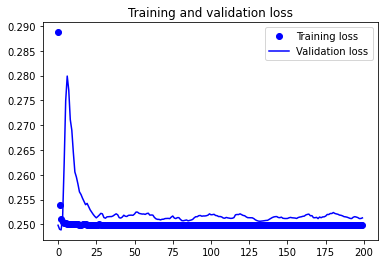

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### DL-2